<a href="https://colab.research.google.com/github/hp-t00ls/Gait_cycle_classification/blob/main/Motion_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For questions to this code please write at david.cremer@student.kit.edu.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.signal import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold, LeaveOneGroupOut
plt.style.use("seaborn")


<ipython-input-1-b3789e67e508>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


Function to load the needed columns out of pandas dataframe, where walking_data is the pandas frame and it is possible to give an extracor via kwargs to load only special columns if none is given all columns are loaded. Only the data of one person is loadad. The walking_data is expected to be an data frame of an excel file produced by the theia marker less headline where the headers were cleaned and all speeds are in one excel file. Returns an array of the angles as pandas frames in an array for the different speeds.

In [ ]:
def load_data_angles(walking_data, **kwargs):
  columns = 48 * 3
  walking_data = walking_data.iloc[:,1:]
  #print(walking_data)
  persons_recorded = int((len(walking_data.columns)) / columns)
  print(persons_recorded)

  walking_2 = walking_data.iloc[:,0:48]
  start = 48 * persons_recorded

  walking_4 = walking_data.iloc[:,start:start + 48]
  start = start * 2
  walking_6 = walking_data.iloc[:,start:start + 48]


  extractor = kwargs.get("extract", [])


  if len(extractor) != 0:
    walking_2 = walking_2[extractor[0]]
    walking_4 = walking_4[extractor[1]]
    walking_6 = walking_6[extractor[2]]

  return [walking_2, walking_4, walking_6]

The same function as load_data_angles but to load position of one person out of a poisiton pandas_data frame.

In [ ]:
def load_data_positions(walking_data,**kwargs):
  walking_data = walking_data.iloc[:,1:]
  walking_2 = walking_data.iloc[:,0:42]
  walking_4 = walking_data.iloc[:,42:84]
  walking_6 = walking_data.iloc[:,84:126]


  extractor = kwargs.get("extract", [])
  if len(extractor) != 0:
    walking_2 = walking_2[extractor[0]]
    walking_4 = walking_4[extractor[1]]
    walking_6 = walking_6[extractor[2]]

  return [walking_2, walking_4, walking_6]

Building an exctracror which can later be used to extract data out of pandas frame. Person has to be the number of ther person for which the extractor should be build. Via kwargs it can be specified which parameters should be in the ectractor, otherwise all parameters are extrcated. An array of extratcors is returned with 3 elements for the 3 different speeds


In [ ]:
def build_extractor(person, **kwargs):
  axes = kwargs.get("axes", ["X", "Y", "Z"])
  sites = kwargs.get("site", ["L","R"])
  person_str = "P" + str(person + 1)
  wanted_parameters= kwargs.get("parameters", ["ANKLE_ANGLE", "KNEE_ANGLE", "HIP_ANGLE", "SHOULDER_ANGLE", "ELBOW_ANGLE", "TORSO_ANGLE_wrt_PELVIS", "MTP_POSITION", "ANKLE_POSITION", "KNEE_POSITION", "HIP_POSITION", "SHOULDER_POSITION", "ELBOW_POSITION", "WRIST_POSITION"])
  walking_speeds = kwargs.get("speed", ["2", "4", "6"])

  return_array = []
  for w in walking_speeds:
    walking_array = []

    path = "/" + person_str + "/Walking_" + w + "_posfilt0_"

    for parameter in wanted_parameters:
      path2 =  parameter + "_"
      if  parameter == "TORSO_ANGLE_wrt_PELVIS":
          path3 = path + path2
          for axe in axes:
            path4 = path3 + axe
            walking_array.append(path4)
      else:

        for site in sites:
          path3 = path + site + "_" + path2
          for axe in axes:
            path4 = path3 + axe
            walking_array.append(path4)
    return_array.append(walking_array)


  return return_array


All angles and positions are loaded out of the csv files which are in the folders JointAngles and JointPositions. The dictionary walking_data contains all the walking data for all persons.

In [ ]:

data_dir = os.path.realpath('JointAngles')
files = os.listdir(data_dir)
files.sort()
print(files)
walking_data = {}
if files[0] == ".ipynb_checkpoints":
  files = files[1:]

data_dir_2 = os.path.realpath("JointPositions")
joint_positions = os.listdir(data_dir_2)
joint_positions.sort()
if joint_positions[0] == ".ipynb_checkpoints":
  joint_positions = joint_positions[1:]


for i in range(len(files)):
  extractor  = build_extractor(i)
  extractor = np.array(extractor)
  extractor_angles = extractor[:,:(5*2*3 + 3)]
  angle_data =  load_data_angles(pd.read_csv(os.path.join(data_dir, files[i]), delimiter =";", decimal=","), extract = extractor_angles)
  extractor_positions = extractor[:,(5*2*3+3):]

  position_data = load_data_positions(pd.read_csv(os.path.join(data_dir_2, joint_positions[i]), delimiter =";", decimal=","), extract = extractor_positions)

  data =  [pd.concat([angle_data[0], position_data[0]], axis = 1), pd.concat([angle_data[1], position_data[1]], axis = 1), pd.concat([angle_data[2], position_data[2]], axis = 1)]
  walking_data[i] = data



['P1_JointAngles.csvconverted.csv', 'P2_JointAngles.csvconverted.csv', 'P3_JointAngles.csvconverted.csv', 'P4_JointAngles.csvconverted.csv', 'P5_JointAngles.csvconverted.csv', 'P6_JointAngles.csvconverted.csv', 'P7_JointAngles.csvconverted.csv', 'P8_JointAngles.csvconverted.csv', 'P9_JointAngles.csvconverted.csv']
1
1
1
1
1
1
1
1
1


NOT USED

Via this function all gait cycles are seperated based on the x knee angle, which has to be given via the extractor parameter and the pandas frame are the walking data. It returns the mimimum gait length found. And an array with all gait cycles

In [ ]:
def find_gait_cycles_knee(pandas_frame, extractor, **kwargs):
  knee_angle_np = pandas_frame[extractor].to_numpy()

  wanted = kwargs.get("wanted_parameters", None)
  if wanted != None:
    pandas_frame = pandas_frame[wanted]

  all_angles = pandas_frame.to_numpy()

  #print(extractor)

  cycles_splits = np.array([], dtype=int)

  for i in range(10, (len(knee_angle_np) - 10)):

    if ((knee_angle_np[i] <= knee_angle_np[(i-10):(i+10)]).all()) and knee_angle_np[i] < -40:
      cycles_splits = np.append(cycles_splits, int(i))


  cycles = np.split(knee_angle_np, cycles_splits)[2:-1]
  all_angle_cycles = np.split(all_angles, cycles_splits)[2:-1]


  minimum_gait_length = float('inf')

  for c in cycles:
    if len(c) <= minimum_gait_length:
      minimum_gait_length = len(c)

  return minimum_gait_length, all_angle_cycles

Get all gait cycles based on the lowest z ankle position. The extractor for the ankle z position has to be given. The pandas frame is the walking data. It returrns the minimum gait length seen. The gait cycles as array as all_angle_cycles. Cycles_splits gives the points at which the data was split.

In [ ]:
def find_gait_cycles_ankle_position(pandas_frame, extractor, **kwargs):
  ankle_position_np = pandas_frame[extractor].to_numpy()

  wanted = kwargs.get("wanted_parameters", None)
  if wanted != None:
    pandas_frame = pandas_frame[wanted]
  all_angles = pandas_frame.to_numpy()
  cycles_splits = np.array([], dtype=int)
  for i in range(50, (len(ankle_position_np))):
    if ((ankle_position_np[i] >= ankle_position_np[(i-25):(i+25)]).all()) and ankle_position_np[i] > 0.34:
      cycles_splits = np.append(cycles_splits, int(i))


  cycles = np.split(ankle_position_np, cycles_splits)[1:-1]
  all_angle_cycles = np.split(all_angles, cycles_splits)[1:-1]
  minimum_gait_length = float('inf')

  for c in cycles:
    if len(c) <= minimum_gait_length:
      minimum_gait_length = len(c)

  return minimum_gait_length, all_angle_cycles, cycles_splits

In the following the number of cycles is counted and what the shortest cycle overall is

In [ ]:
shortest_cycle = 1000
cycle_counts = []


for key, value in walking_data.items():
  #extract = build_extractor(key, site =(["R"]), parameters = ["KNEE_ANGLE"], axes=["X"])
  extract = build_extractor(key, site =(["R"]), parameters = ["ANKLE_POSITION"], axes=["Z"])
  for i in range(0,len(value)):
    #minimum, all_cycles = find_gait_cycles_knee(value[i], extract[i])
    minimum, all_cycles, c = find_gait_cycles_ankle_position(value[i], extract[i])
    cycle_counts.append(len(all_cycles))
    if minimum < shortest_cycle:
      shortest_cylce = minimum

cycle_count = np.sum(cycle_counts)


In the following, all gait cycles are extracted out of the data. As the gait cycles are varying in number of data points (gait cycles at faster walking speeds have less data points, but also the gait cycles at one walking speed vary) they are resampled to 100 points, so that each gait cycle has the same amount of data points.

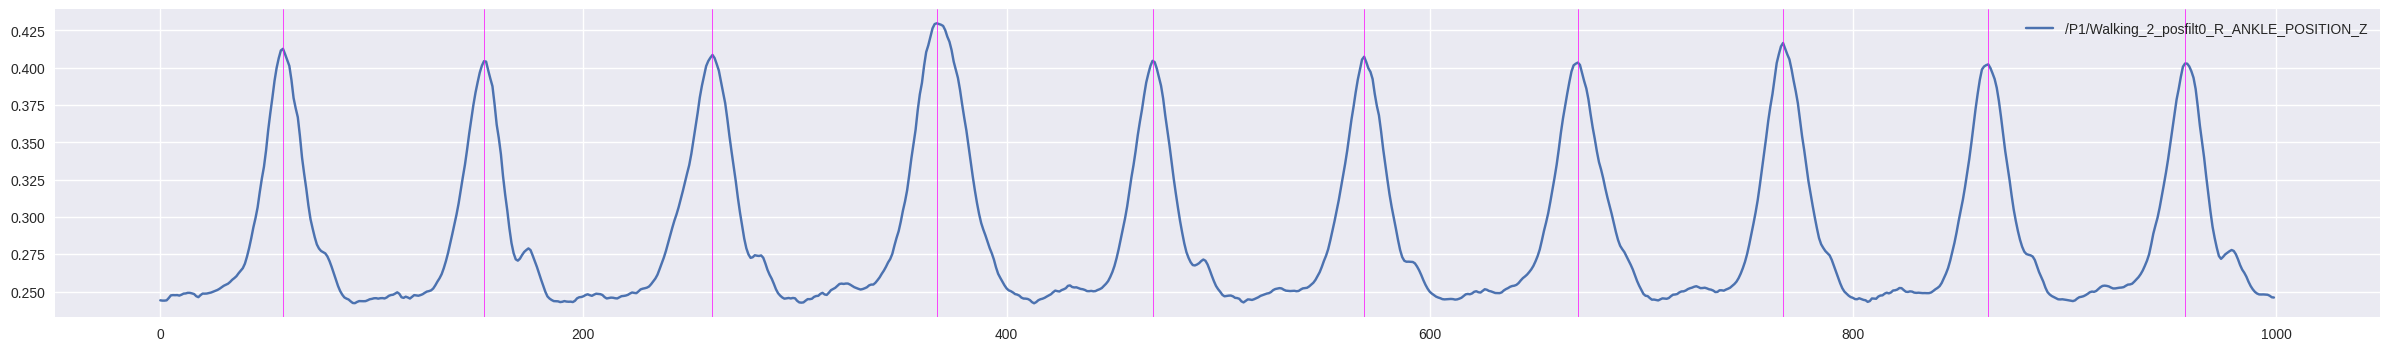

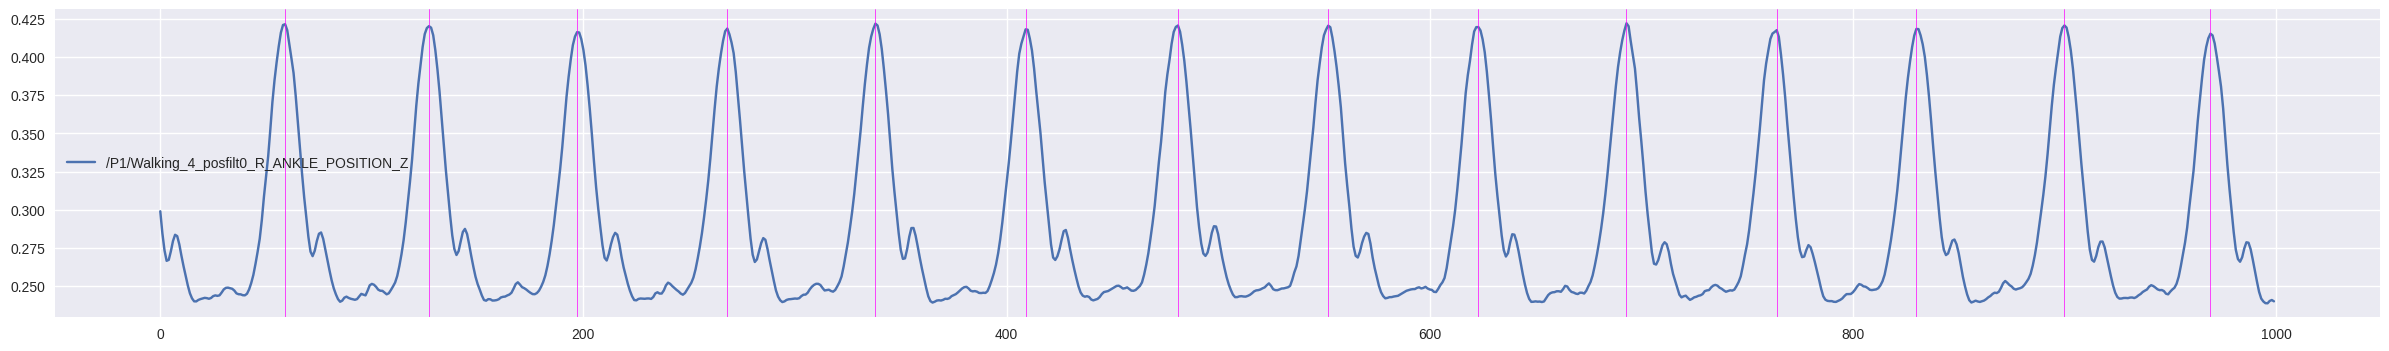

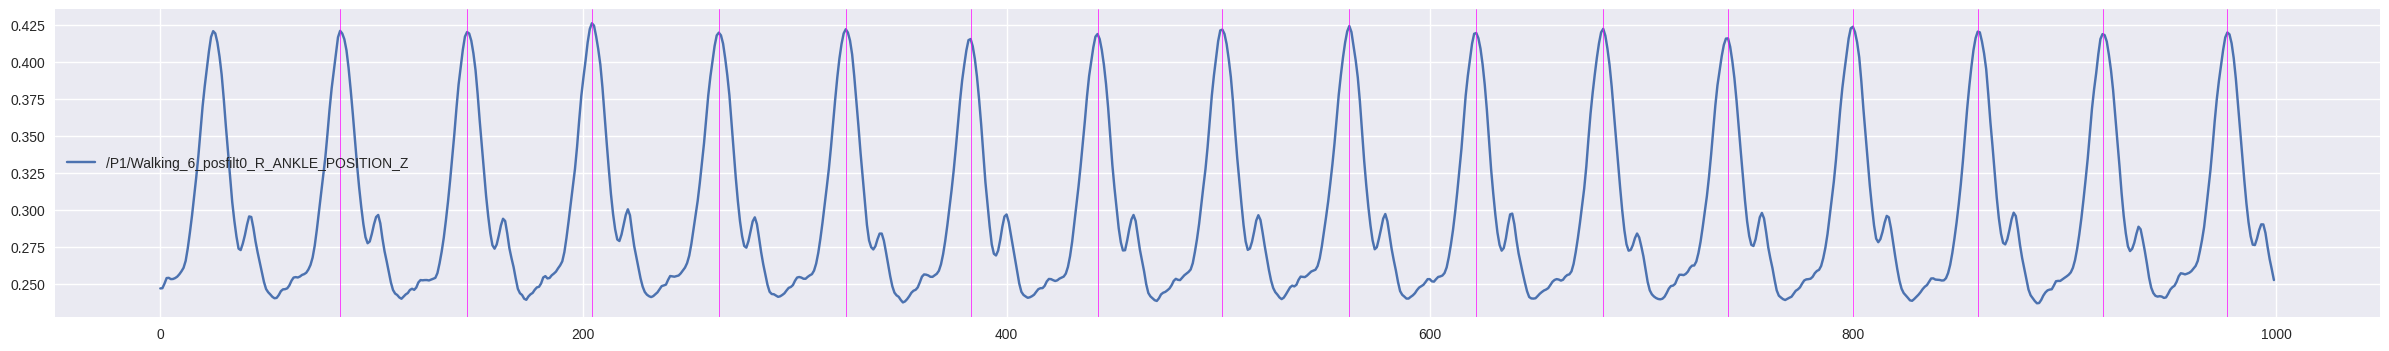

In [ ]:
resample_points = 100

cutting_points = [0]

results = np.empty((cycle_count,resample_points,75), dtype=np.float128)
speed_cutting_points = [0]
#test_results = np.empty((50,21), dtype=np.float128)

plot = True
plot2 = False
cutpoint = 0

plotcount = 0
if plot2 == True:
  #fig, axs = plt.subplots(len(walking_data),3, figsize=(16,16))
  fig, axs = plt.subplots(1,3, figsize=(8,8))
  axs = axs.flatten()
for key, value in walking_data.items():

  #extract = build_extractor(key, site =(["R"]), parameters = ["KNEE_ANGLE"], axes=["X"])
  extract = build_extractor(key, site =(["R"]), parameters = ["ANKLE_POSITION"], axes=["Z"])
  #print(extract)

  #wanted = build_extractor(key, parameters = ["ANKLE_ANGLE", "KNEE_ANGLE", "HIP_ANGLE"])
  for i in range(len(value)):
    #minimum, all_cycles = find_gait_cycles_knee(value[i], extract[i])
    minimum, all_cycles, splits = find_gait_cycles_ankle_position(value[i], extract[i]) #, wanted_parameters = wanted[i])

    if plot == True and key == 0:
      ankle_position = value[i][extract[i]][:1000]
      ankle_position.plot(figsize=(30,4))
      for split in splits:
        if split < 1000:
          plt.axvline(x=split, color='magenta', linestyle='-', linewidth=0.5)
      plt.show()


    for cycle in all_cycles:
      resampled_cycle = resample(cycle, resample_points)

      #test_results = np.dstack((test_results, resampled_cycle))
      results[cutpoint] = resampled_cycle
      #print(resampled_cycle)
      cutpoint += 1

    if plot2 == True and key == 0:
      #print(cycle.shape)
      #extract2 = build_extractor(key, site =(["R"]), parameters = ["KNEE_ANGLE"], axes=["X"])
      ankle_index = value[i].columns.get_loc(extract[i][0])

      axs[plotcount].plot(cycle[:,ankle_index], '.-')
      axs[plotcount].plot(resampled_cycle[:,ankle_index], '.-')
      axs[plotcount].set_xticks([0,10,20,30,40,50,60,70,80, 90, 100])
      axs[plotcount].set_yticks([0.24,0.26,0.28,0.30,0.32,0.34,0.36,0.38,0.40])

      plotcount +=1

    speed_cutting_points.append(cutpoint)

  cutting_points.append(cutpoint)

if plot2 == True:
  plt.show()


In the following all positional data is centered over the average of the hip position

In [ ]:

column_names = walking_data[0][0]
hip_r_x = column_names.columns.get_loc(build_extractor(0, site =(["R"]), parameters = ["HIP_POSITION"], axes=["X"])[0][0])
hip_r_y = column_names.columns.get_loc(build_extractor(0, site =(["R"]), parameters = ["HIP_POSITION"], axes=["Y"])[0][0])
hip_r_z = column_names.columns.get_loc(build_extractor(0, site =(["R"]), parameters = ["HIP_POSITION"], axes=["Z"])[0][0])
hip_l_x = column_names.columns.get_loc(build_extractor(0, site =(["L"]), parameters = ["HIP_POSITION"], axes=["X"])[0][0])
hip_l_y = column_names.columns.get_loc(build_extractor(0, site =(["L"]), parameters = ["HIP_POSITION"], axes=["Y"])[0][0])
hip_l_z = column_names.columns.get_loc(build_extractor(0, site =(["L"]), parameters = ["HIP_POSITION"], axes=["Z"])[0][0])
params = ["MTP_POSITION", "ANKLE_POSITION", "KNEE_POSITION", "HIP_POSITION", "SHOULDER_POSITION", "ELBOW_POSITION", "WRIST_POSITION"]
values_to_update_x = build_extractor(0, parameters=params, axes = ["X"])[0]
values_to_update_y = build_extractor(0, parameters=params, axes = ["Y"])[0]
values_to_update_z = build_extractor(0, parameters=params, axes = ["Z"])[0]


for i in range(len(results)):
  cycle = results[i]
  mean_hip_x = ((cycle.mean(axis = 0)[hip_r_x] + cycle.mean(axis = 0)[hip_l_x])/2)
  mean_hip_y = ((cycle.mean(axis = 0)[hip_r_y] + cycle.mean(axis = 0)[hip_l_y])/2)
  mean_hip_z = ((cycle.mean(axis = 0)[hip_r_z] + cycle.mean(axis = 0)[hip_l_z])/2)

  #print(cycle[:,0].shape)

  for value in values_to_update_x:
    position = column_names.columns.get_loc(value)
    results[i,:,position] = results[i,:,position] - mean_hip_x


  for value in values_to_update_y:
    position = column_names.columns.get_loc(value)
    results[i,:,position] = results[i,:,position] - mean_hip_y


  for value in values_to_update_z:
    position = column_names.columns.get_loc(value)
    results[i,:,position] = results[i,:,position] - mean_hip_z




Building labels for visualization

In [ ]:
print(results.shape)

result_reshape = np.reshape(results,(results.shape[0],(results.shape[1]*results.shape[2])))
print(result_reshape.shape)

angle_labels = build_extractor(-1)[0]
for i in range(len(angle_labels)):
  angle_labels[i] = angle_labels[i].replace("/P0/Walking_2_posfilt0","")

all_angle_labels = []
for i in range(results.shape[1]):
  all_angle_labels.append(angle_labels)

all_angle_labels_2 = np.array(all_angle_labels).flatten()

(3631, 100, 75)
(3631, 7500)


In [ ]:
"""print(test_results.shape)
test_result_reshape = (np.reshape(test_results,(test_results.shape[0]*test_results.shape[1], test_results.shape[2])).T)[1:]
print(test_result_reshape.shape)"""


'print(test_results.shape)\ntest_result_reshape = (np.reshape(test_results,(test_results.shape[0]*test_results.shape[1], test_results.shape[2])).T)[1:]\nprint(test_result_reshape.shape)'

Scaling data

In [ ]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(result_reshape)

NOT USED
Possibility to plot pca decompisition components


In [ ]:
pca_2 = PCA(n_components=0.9)
print(results.shape)
pca_matrix = np.reshape(results, (results.shape[0]* results.shape[1], results.shape[2]))
print(pca_matrix.shape)
pca_transformed_2 = pca_2.fit_transform(pca_matrix)
print(pca_transformed_2.shape)
print(angle_labels)
print(pca_2.components_.shape)

pca_transformed_2 = np.reshape(pca_transformed_2, (results.shape[0], 100*8))
#X_train, X_test, y_train, y_test = train_test_split(pca_transformed, labels, test_size=0.2, random_state=21)

def plot_component(component, labels):
  #print(component)
  plt.bar(range(len(labels)),np.abs(component), tick_label = labels)
  ax = plt.gca()
  #ax.xaxis.get_label().set_fontsize(20)
  for tick in ax.get_xticklabels():
      tick.set_rotation(90)
      tick.set_fontsize(5)
  plt.show()
"""
test = 0
number = 0
ratio = pca_2.explained_variance_ratio_
for component in pca_2.components_:
  print(ratio[number])
  plot_component(component, angle_labels)

  test += ratio[number]
  number +=1
print(test)"""

(3631, 100, 75)
(363100, 75)
(363100, 8)
['_L_ANKLE_ANGLE_X', '_L_ANKLE_ANGLE_Y', '_L_ANKLE_ANGLE_Z', '_R_ANKLE_ANGLE_X', '_R_ANKLE_ANGLE_Y', '_R_ANKLE_ANGLE_Z', '_L_KNEE_ANGLE_X', '_L_KNEE_ANGLE_Y', '_L_KNEE_ANGLE_Z', '_R_KNEE_ANGLE_X', '_R_KNEE_ANGLE_Y', '_R_KNEE_ANGLE_Z', '_L_HIP_ANGLE_X', '_L_HIP_ANGLE_Y', '_L_HIP_ANGLE_Z', '_R_HIP_ANGLE_X', '_R_HIP_ANGLE_Y', '_R_HIP_ANGLE_Z', '_L_SHOULDER_ANGLE_X', '_L_SHOULDER_ANGLE_Y', '_L_SHOULDER_ANGLE_Z', '_R_SHOULDER_ANGLE_X', '_R_SHOULDER_ANGLE_Y', '_R_SHOULDER_ANGLE_Z', '_L_ELBOW_ANGLE_X', '_L_ELBOW_ANGLE_Y', '_L_ELBOW_ANGLE_Z', '_R_ELBOW_ANGLE_X', '_R_ELBOW_ANGLE_Y', '_R_ELBOW_ANGLE_Z', '_TORSO_ANGLE_wrt_PELVIS_X', '_TORSO_ANGLE_wrt_PELVIS_Y', '_TORSO_ANGLE_wrt_PELVIS_Z', '_L_MTP_POSITION_X', '_L_MTP_POSITION_Y', '_L_MTP_POSITION_Z', '_R_MTP_POSITION_X', '_R_MTP_POSITION_Y', '_R_MTP_POSITION_Z', '_L_ANKLE_POSITION_X', '_L_ANKLE_POSITION_Y', '_L_ANKLE_POSITION_Z', '_R_ANKLE_POSITION_X', '_R_ANKLE_POSITION_Y', '_R_ANKLE_POSITION_Z', '_L_KNE

'\ntest = 0\nnumber = 0\nratio = pca_2.explained_variance_ratio_\nfor component in pca_2.components_:\n  print(ratio[number])\n  plot_component(component, angle_labels)\n\n  test += ratio[number]\n  number +=1\nprint(test)'

In [ ]:

pca = PCA(n_components = 0.9)
#scaled_data = np.vstack((all_angle_labels_2,scaled_data))


pca_transformed = pca.fit_transform(scaled_data)
#print(pca.get_feature_names_out(input_features = all_angle_labels_2))
#X_train, X_test, y_train, y_test = train_test_split(pca_transformed, labels, test_size=0.2, random_state=21)

print(scaled_data.shape)
print(pca_transformed.shape)

print(angle_labels)


(3631, 7500)
(3631, 48)
['_L_ANKLE_ANGLE_X', '_L_ANKLE_ANGLE_Y', '_L_ANKLE_ANGLE_Z', '_R_ANKLE_ANGLE_X', '_R_ANKLE_ANGLE_Y', '_R_ANKLE_ANGLE_Z', '_L_KNEE_ANGLE_X', '_L_KNEE_ANGLE_Y', '_L_KNEE_ANGLE_Z', '_R_KNEE_ANGLE_X', '_R_KNEE_ANGLE_Y', '_R_KNEE_ANGLE_Z', '_L_HIP_ANGLE_X', '_L_HIP_ANGLE_Y', '_L_HIP_ANGLE_Z', '_R_HIP_ANGLE_X', '_R_HIP_ANGLE_Y', '_R_HIP_ANGLE_Z', '_L_SHOULDER_ANGLE_X', '_L_SHOULDER_ANGLE_Y', '_L_SHOULDER_ANGLE_Z', '_R_SHOULDER_ANGLE_X', '_R_SHOULDER_ANGLE_Y', '_R_SHOULDER_ANGLE_Z', '_L_ELBOW_ANGLE_X', '_L_ELBOW_ANGLE_Y', '_L_ELBOW_ANGLE_Z', '_R_ELBOW_ANGLE_X', '_R_ELBOW_ANGLE_Y', '_R_ELBOW_ANGLE_Z', '_TORSO_ANGLE_wrt_PELVIS_X', '_TORSO_ANGLE_wrt_PELVIS_Y', '_TORSO_ANGLE_wrt_PELVIS_Z', '_L_MTP_POSITION_X', '_L_MTP_POSITION_Y', '_L_MTP_POSITION_Z', '_R_MTP_POSITION_X', '_R_MTP_POSITION_Y', '_R_MTP_POSITION_Z', '_L_ANKLE_POSITION_X', '_L_ANKLE_POSITION_Y', '_L_ANKLE_POSITION_Z', '_R_ANKLE_POSITION_X', '_R_ANKLE_POSITION_Y', '_R_ANKLE_POSITION_Z', '_L_KNEE_POSITION_X', '_

Do a pca where first every gait cycle is flattened to a vector and then the pca is done

In [ ]:
def pca_vector(data):
  data_reshape = np.reshape(data,(data.shape[0],(data.shape[1]*data.shape[2])))
  print(data_reshape.shape)
  scaler = StandardScaler()
  scaled_data = scaler.fit_transform(data_reshape)
  pca = PCA(n_components = 0.9)
  pca_transformed = pca.fit_transform(scaled_data)
  return pca_transformed, pca


Do a pca where first the pca is done and then the result is flatened to an input vector

In [ ]:
def pca_all(data):
  data_reshape = np.reshape(data, (data.shape[0]* data.shape[1], data.shape[2]))
  scaler = StandardScaler()
  scaled_data = scaler.fit_transform(data_reshape)
  pca = PCA(n_components = 0.9)
  pca_transformed = pca.fit_transform(scaled_data)
  pca_transformed = np.reshape(pca_transformed, (results.shape[0], 100*len(pca.components_)))
  return pca_transformed, pca


Possibility to plot the three first components

In [ ]:

def plot_first_pca_components(pca_transformed, cutting_points):
  component_0 = pca_transformed[:,0]
  component_1 = pca_transformed[:,1]
  component_2 = pca_transformed[:,2]

  xs = np.split(component_0, cutting_points)[:-1]
  ys = np.split(component_1, cutting_points)[:-1]
  zs = np.split(component_2, cutting_points)[:-1]
  fig = plt.figure(figsize=(13,13))
  ax = fig.add_subplot(projection='3d')

  for i in range(len(xs)):
    legend = "P" + str(i+1)
    ax.scatter(xs[i], ys[i], zs[i], label = legend)


  ax.set_title("First three PCA components")
  ax.set_xlabel("PCA Component 0")
  ax.set_ylabel("PCA Component 1")
  ax.set_zlabel("PCA Component 2")
  plt.legend()
  plt.show()

Plot the PCA components, and how each variable contributes to the pca component

0.9004437810156334
0.18076481586435683


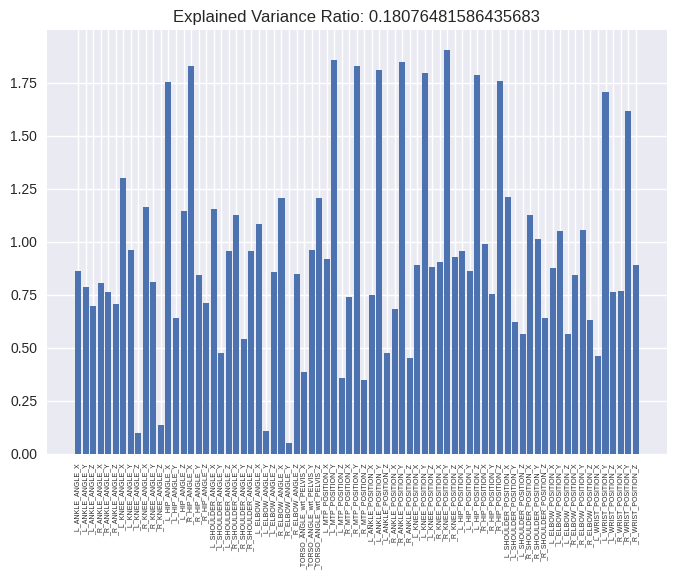

0.152291712577225


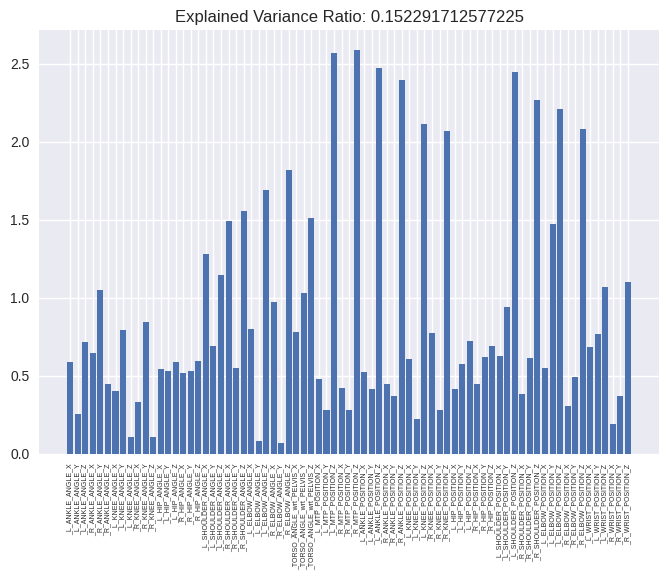

0.10605845003612235


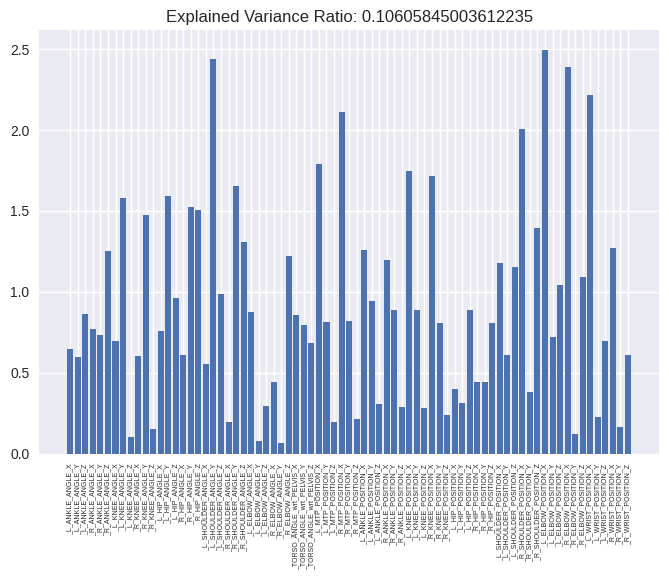

0.07470006321696408


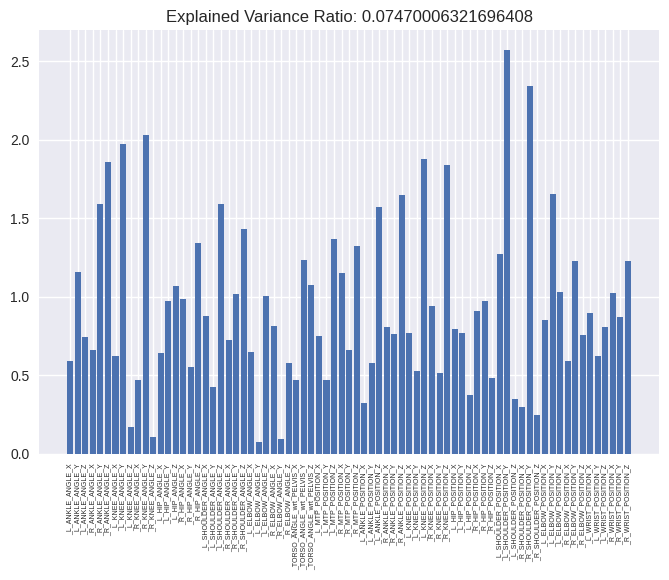

0.05538605145566562


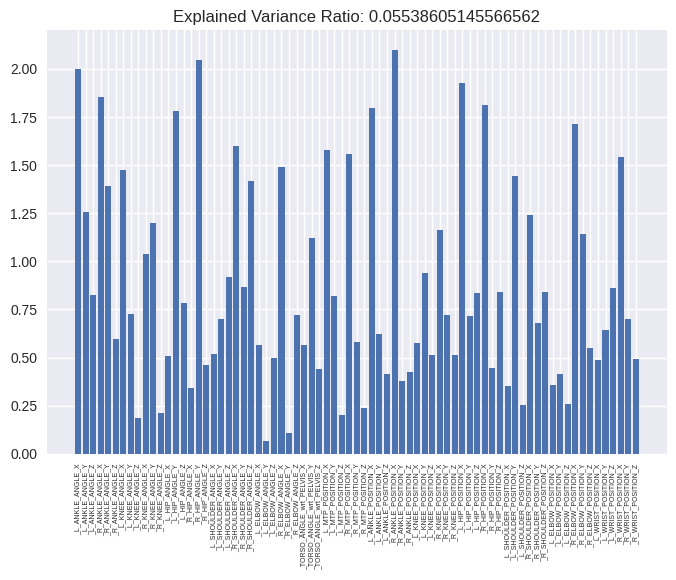

0.044173682532265064


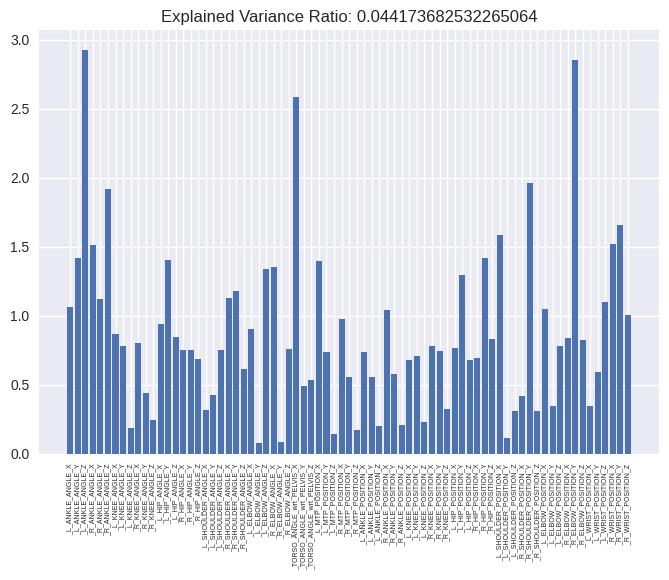

0.0426928559422428


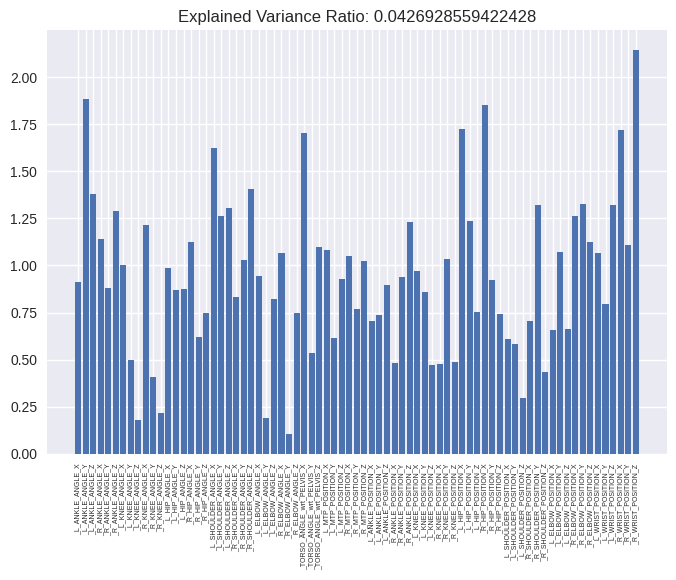

0.032629723143261645


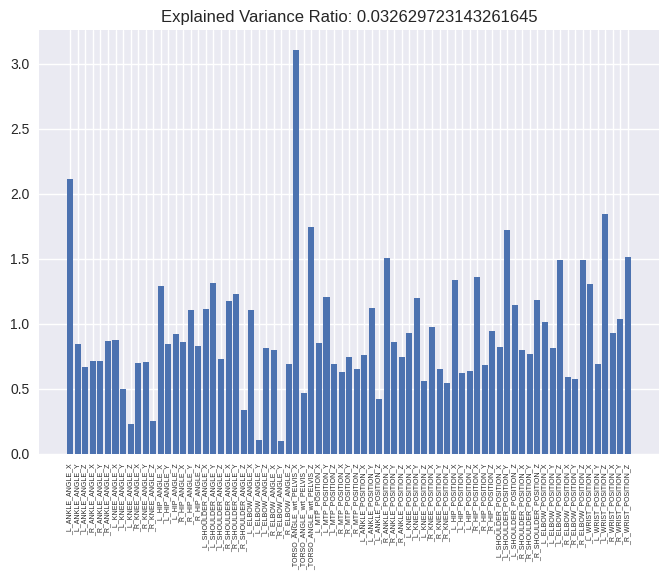

0.026787627258982205


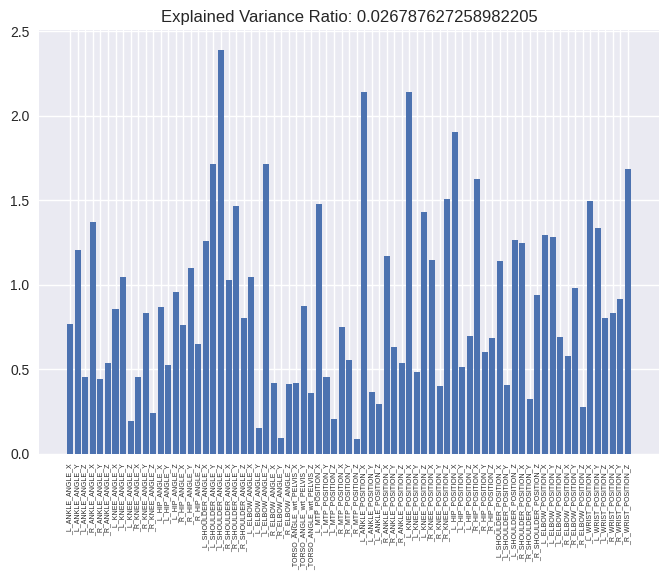

0.021428941024492925


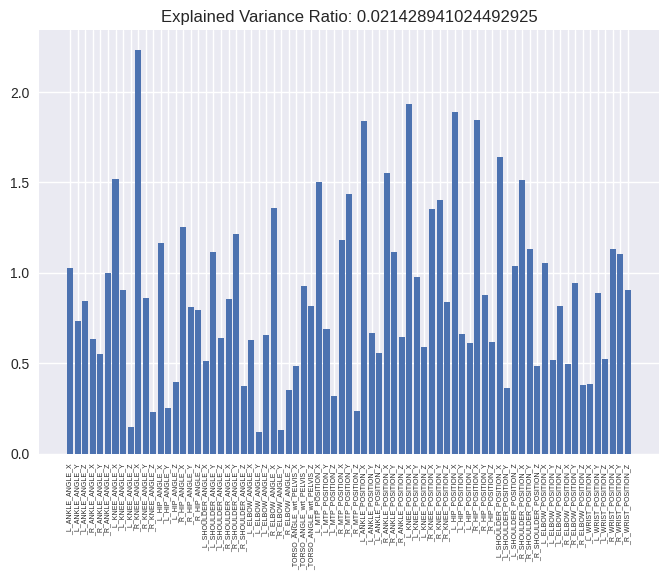

0.018968267829662093


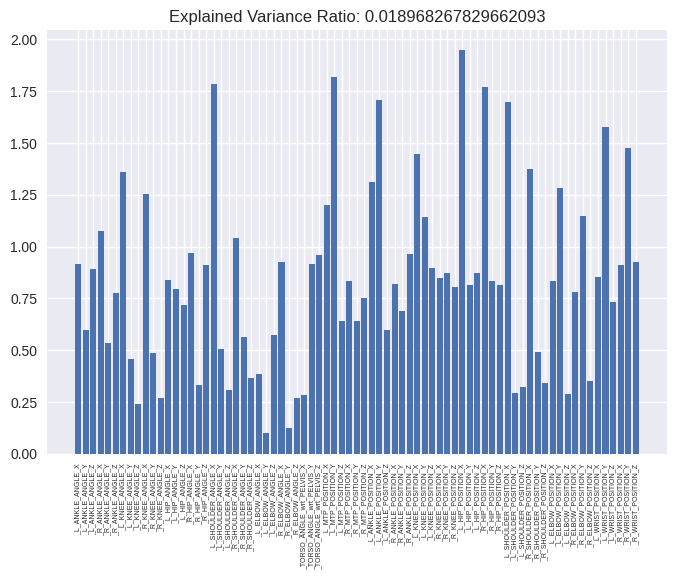

0.016431219596083475


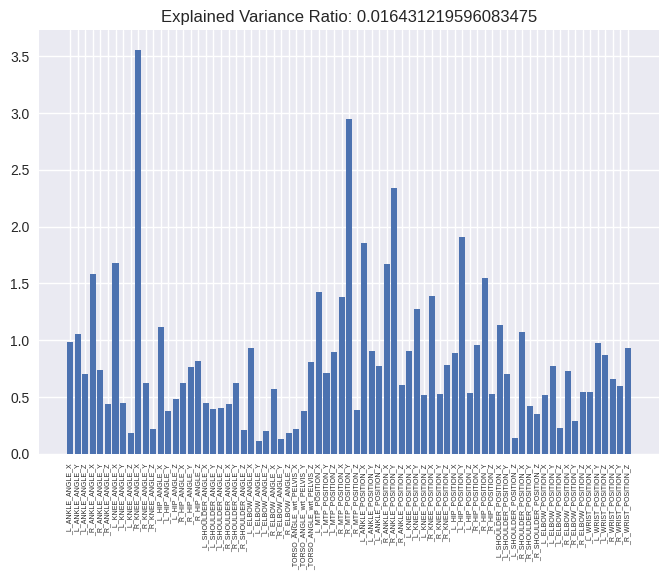

0.013777029010990278


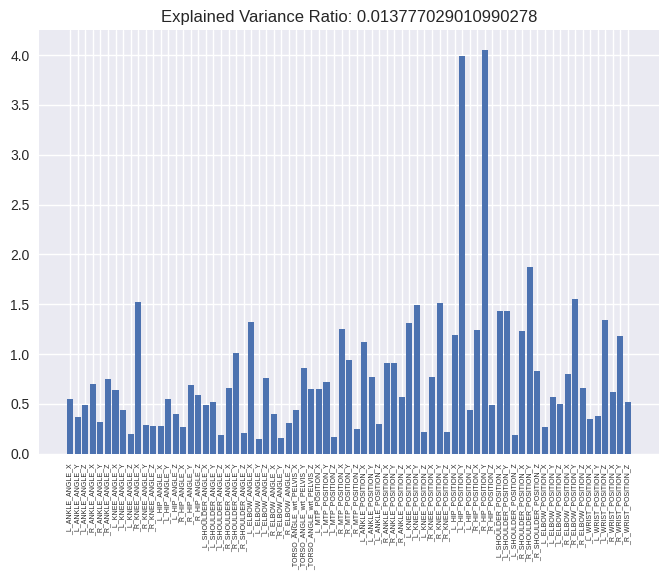

0.010178969127788299


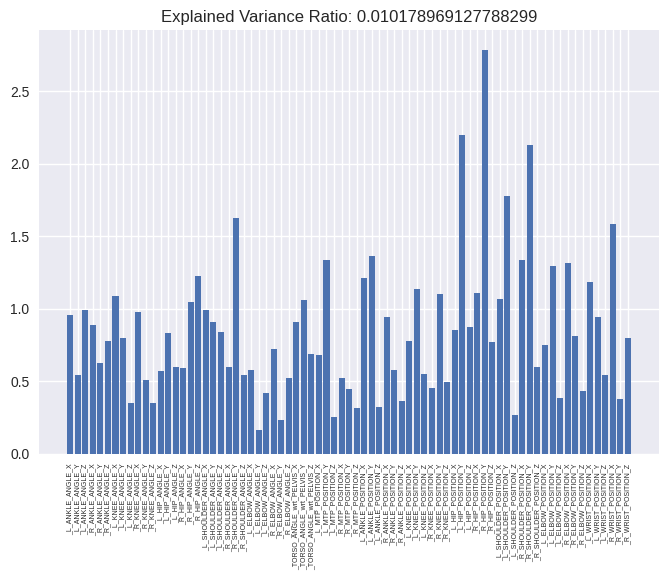

0.009799486485625359


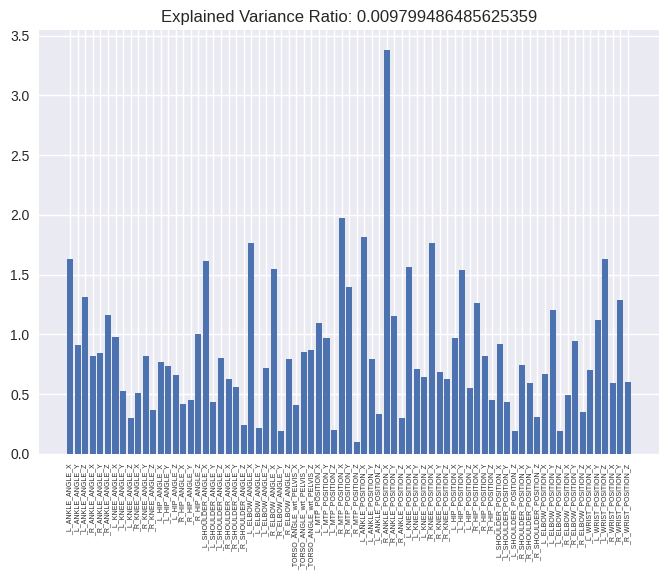

0.00847431056199894


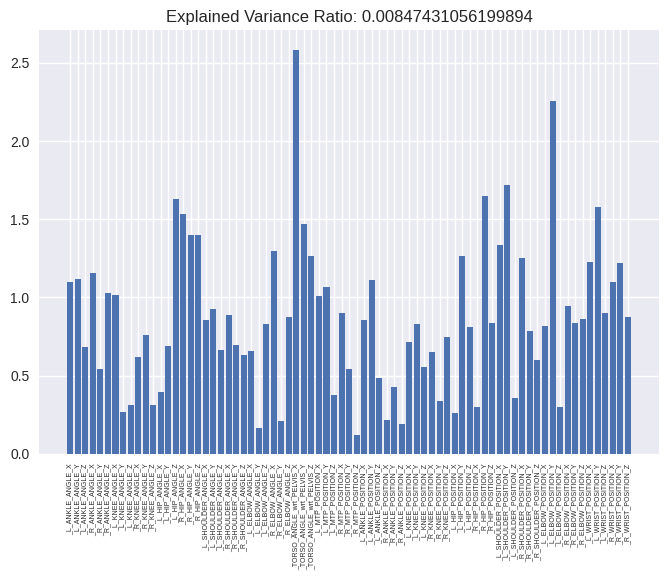

0.0080139229432482


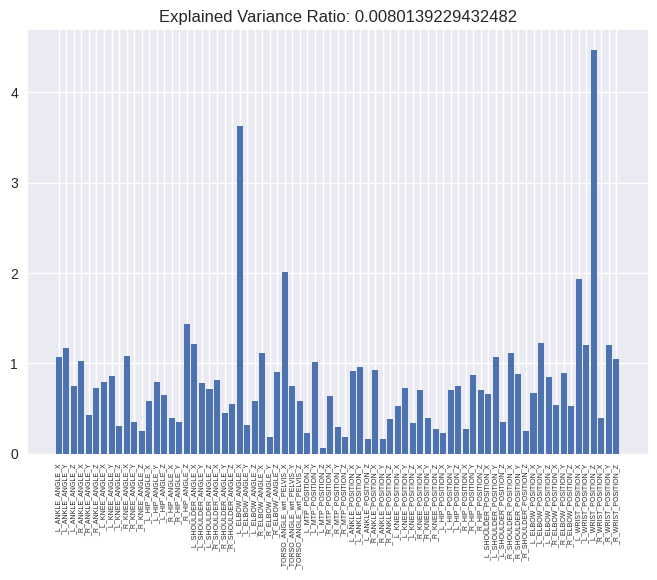

0.007163059314159349


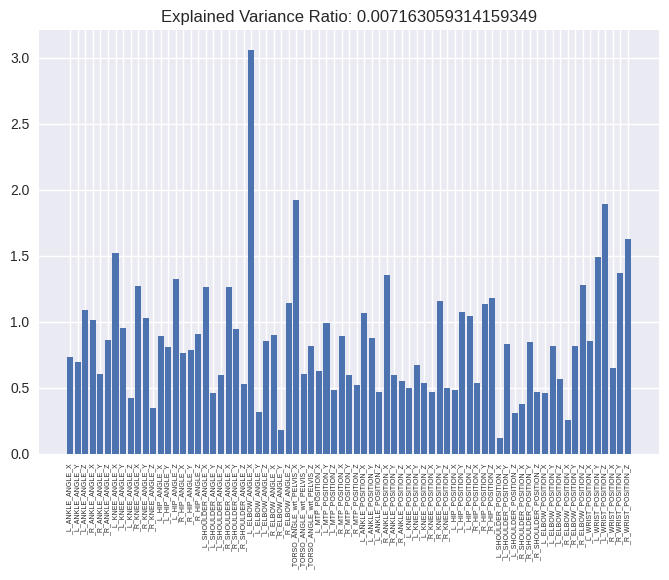

0.006573398010089964


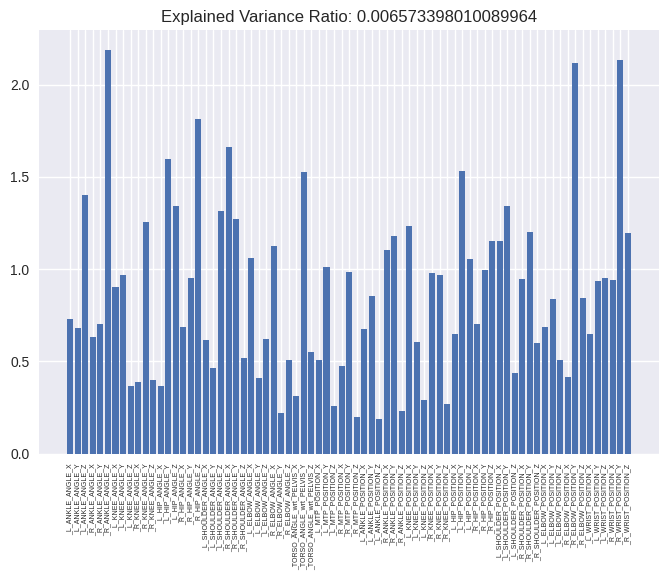

0.005358338212969852


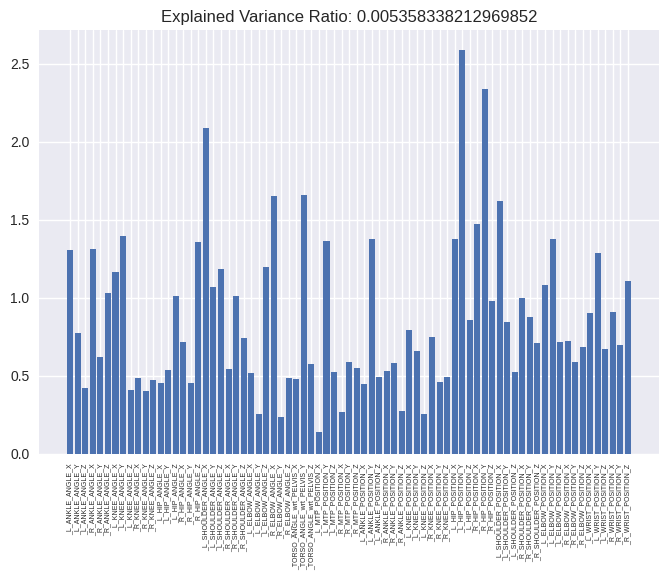

0.00476761379903932


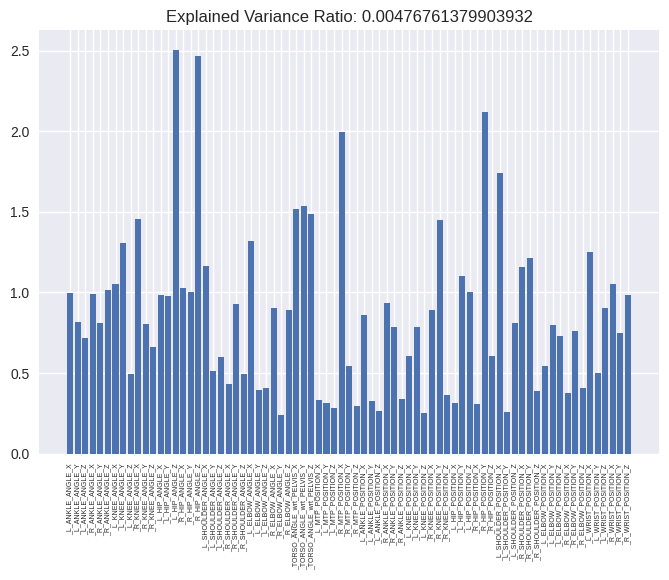

0.004309516698052469


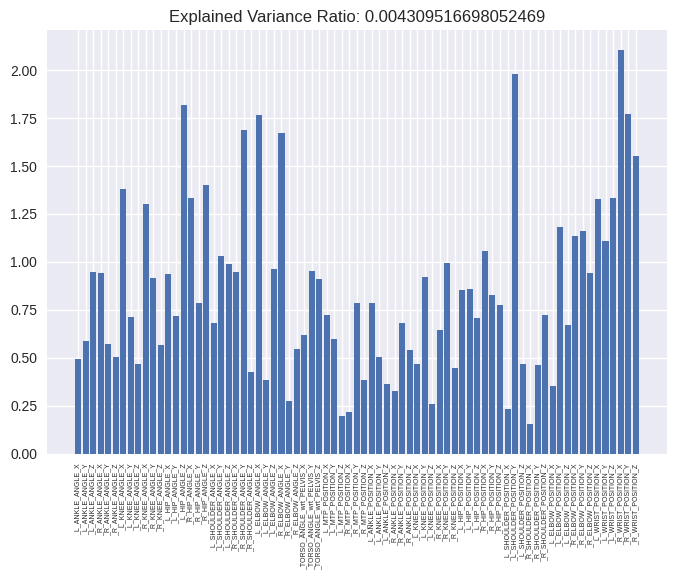

0.004020029107385579


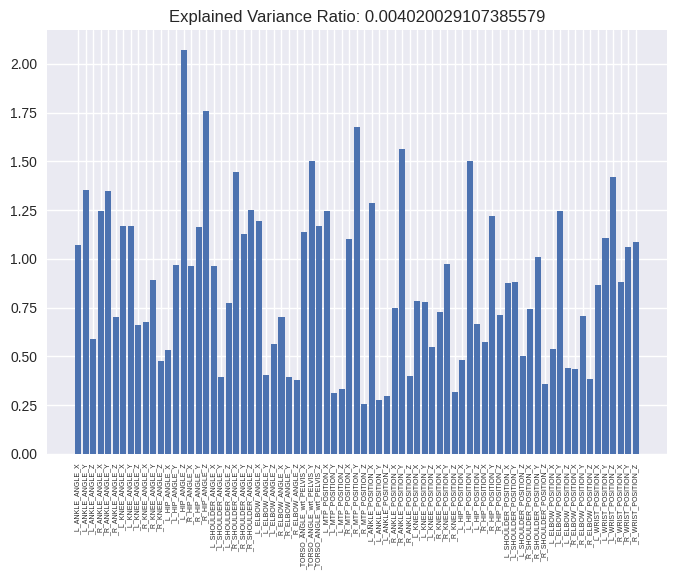

0.0036325646448244825


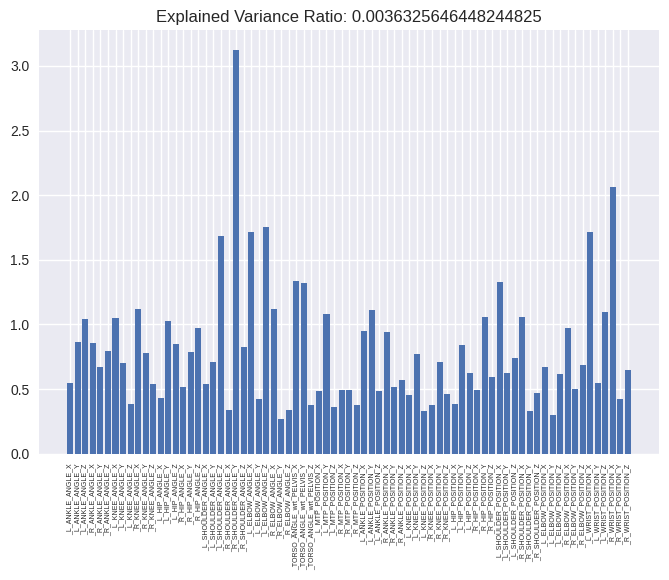

0.0036070597704698113


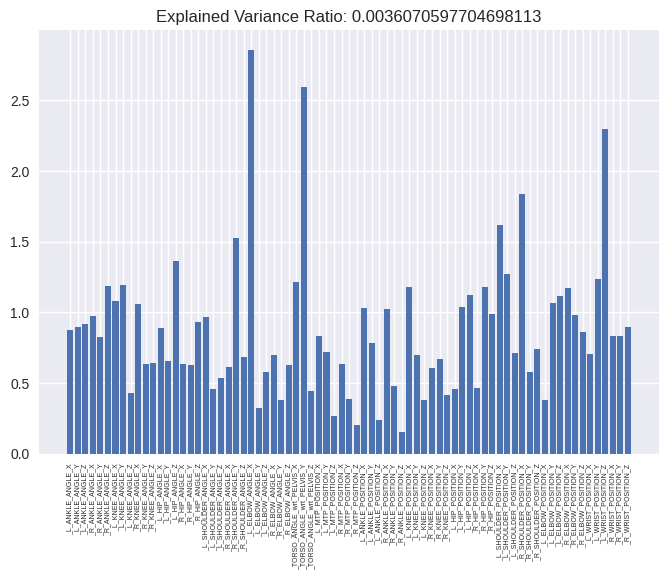

0.003439827672529932


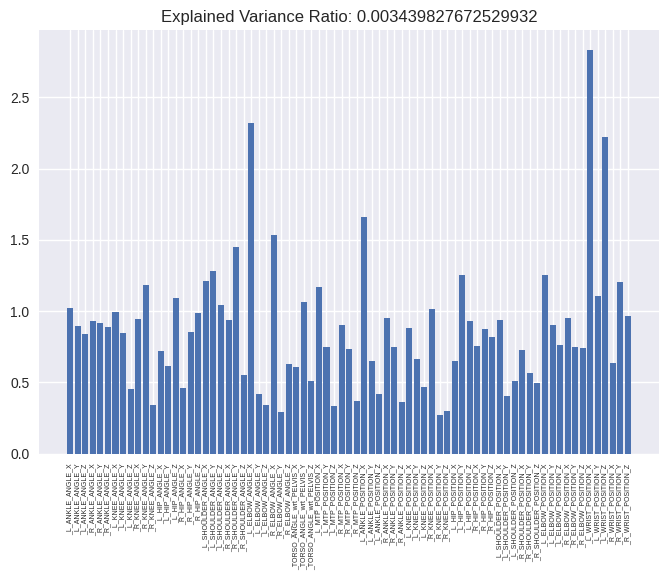

0.003028744775193319


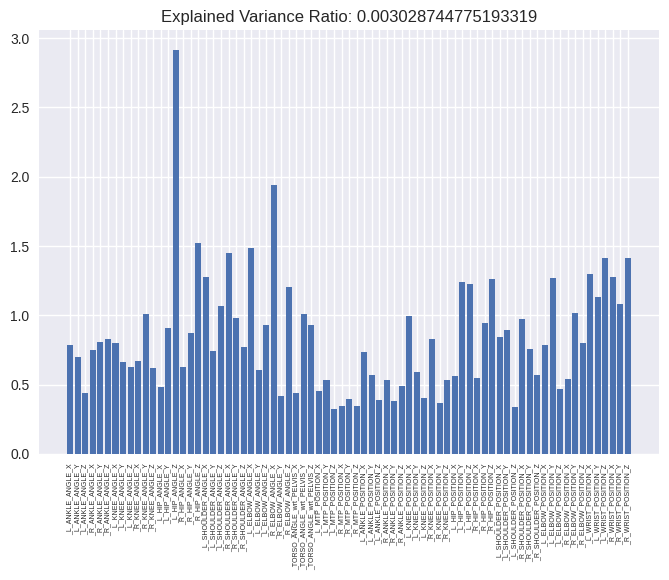

0.00274305931412744


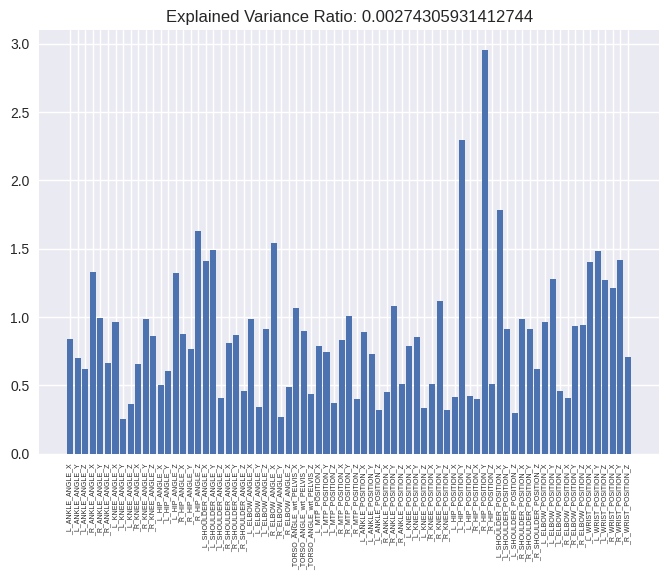

0.0025240668857174305


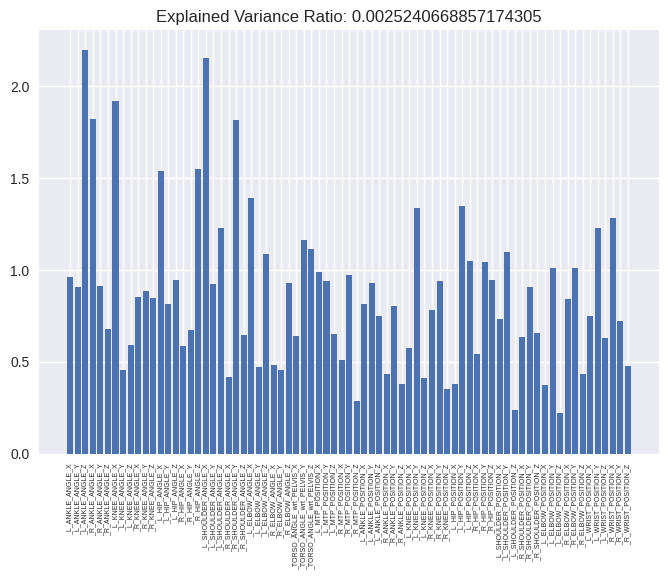

0.002227618563718076


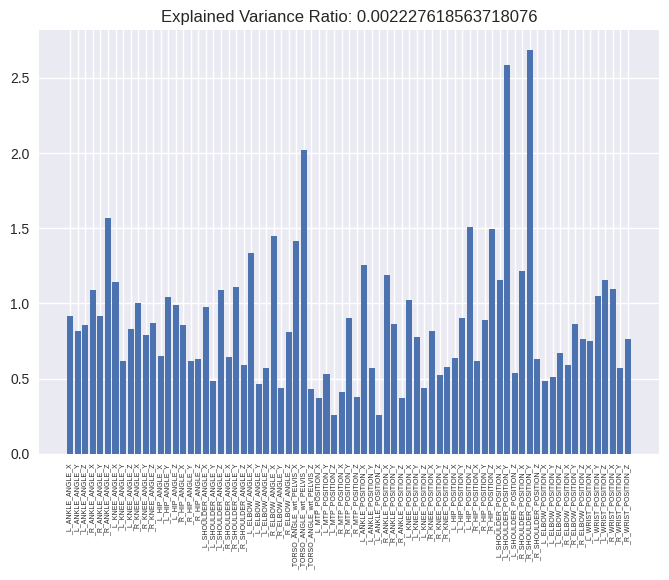

0.002018861742420326


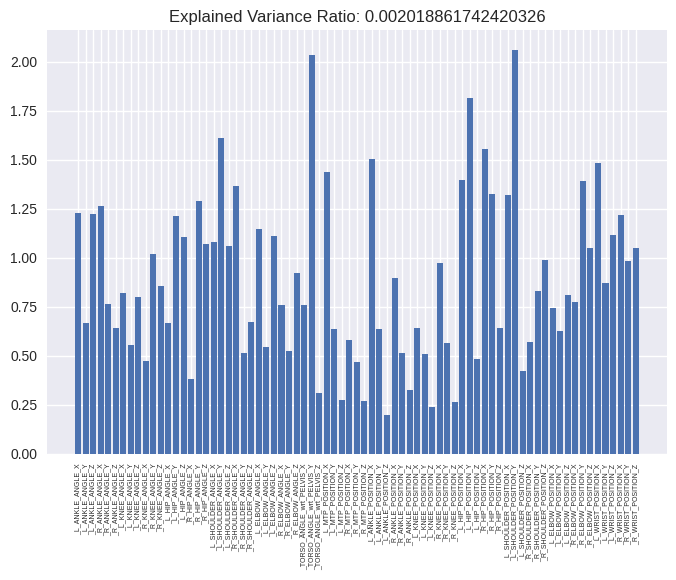

0.001883015365369266


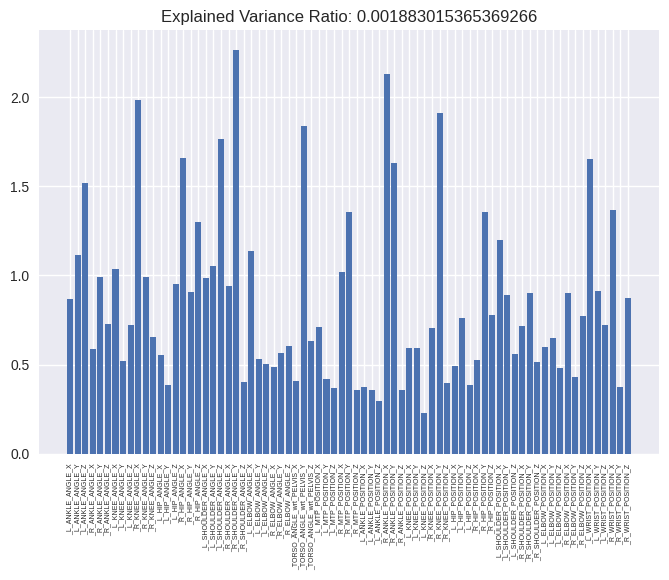

0.0017278138428305288


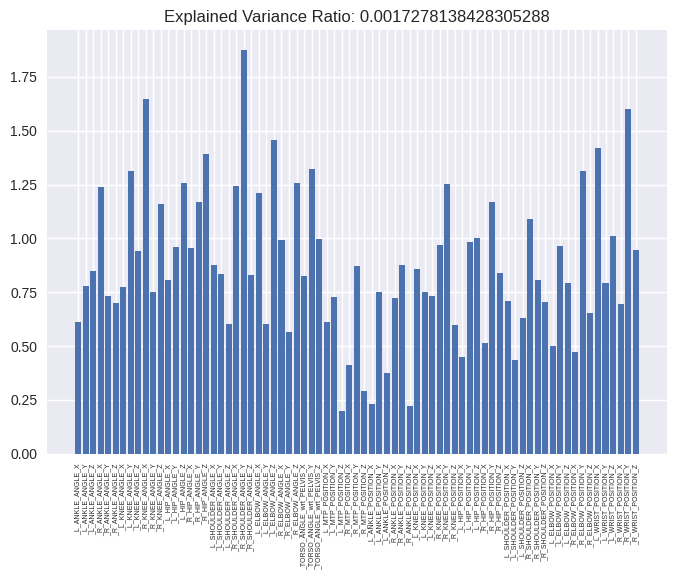

0.0016868078418474325


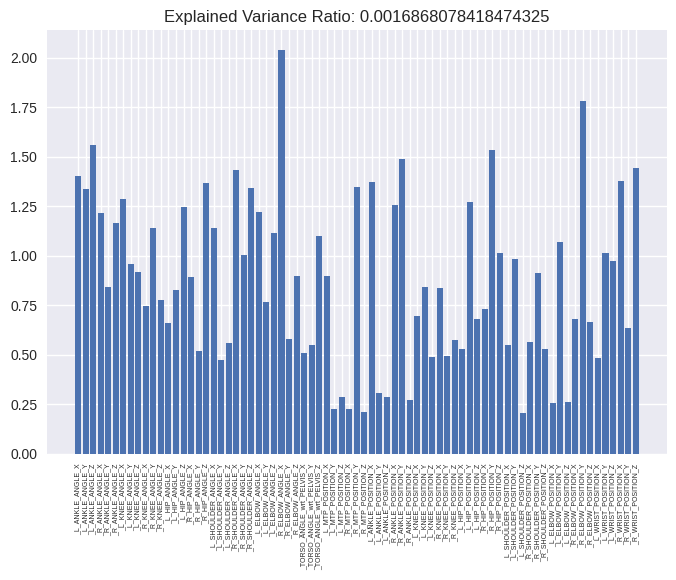

0.0016085676508799458


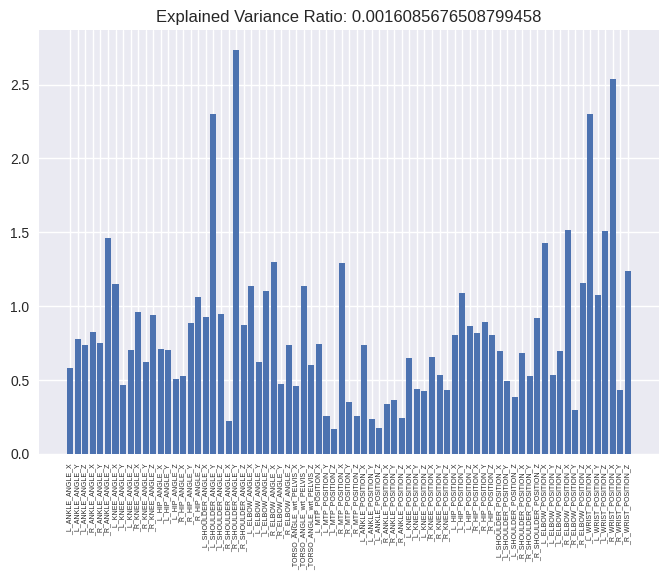

0.0015176143250292319


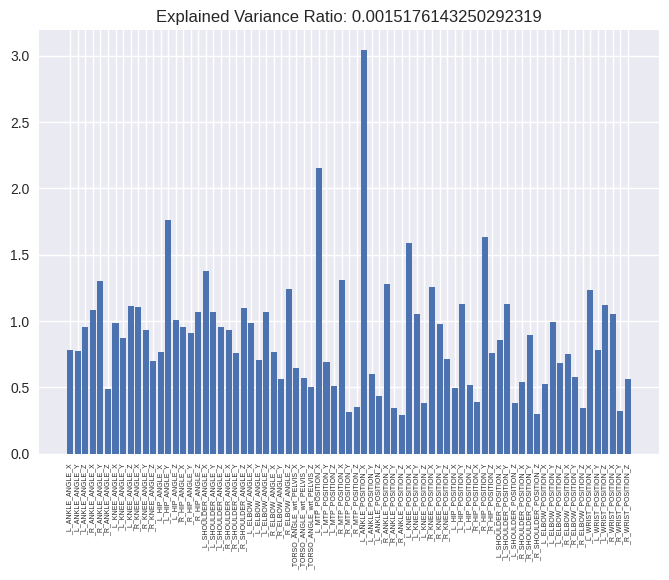

0.001431858504675516


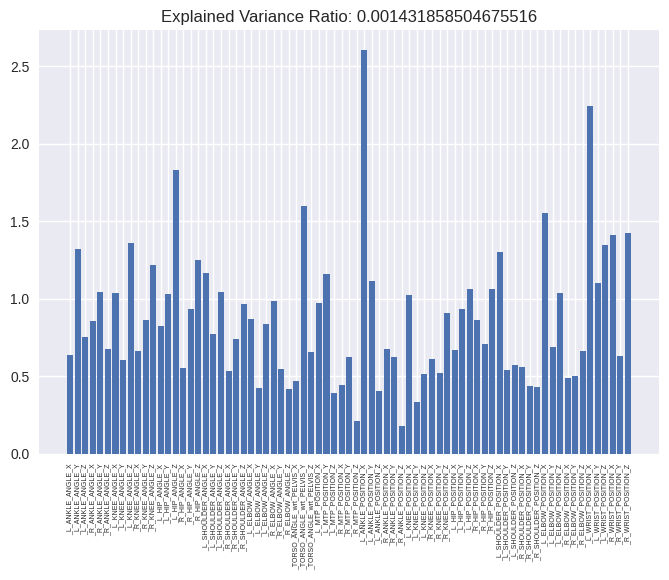

0.0013949639027697896


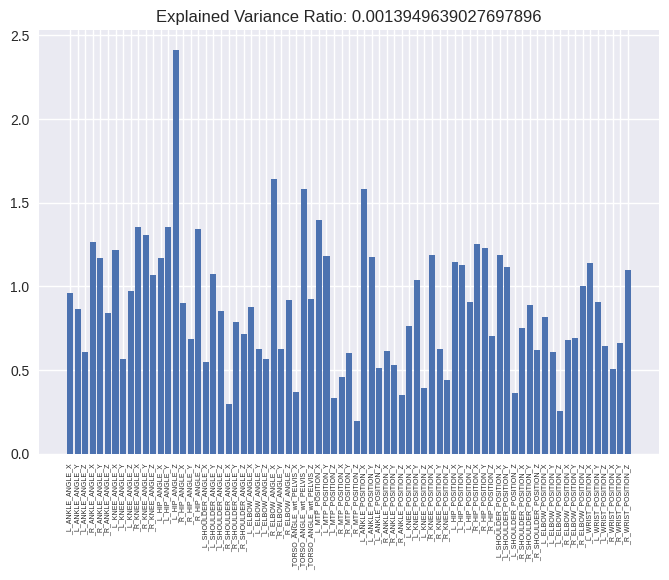

0.0013371837696334694


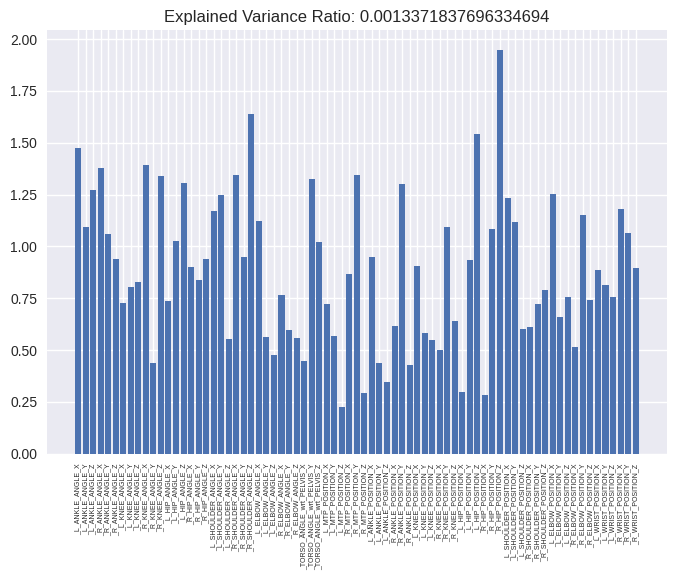

0.001323321926228418


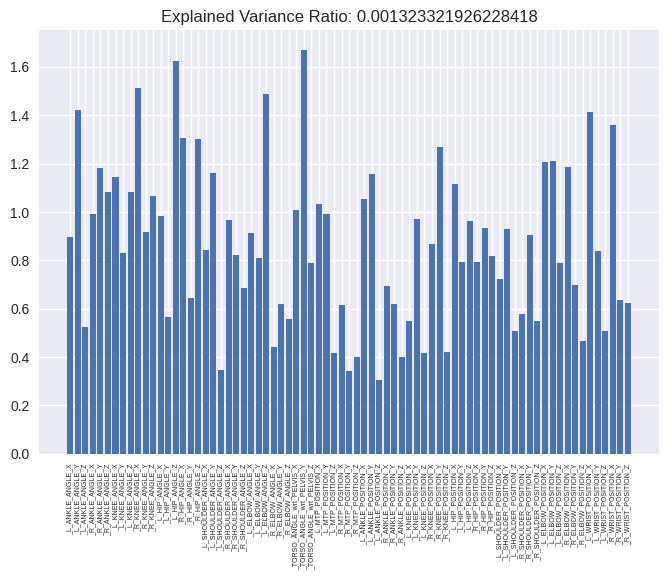

0.0012175827556917876


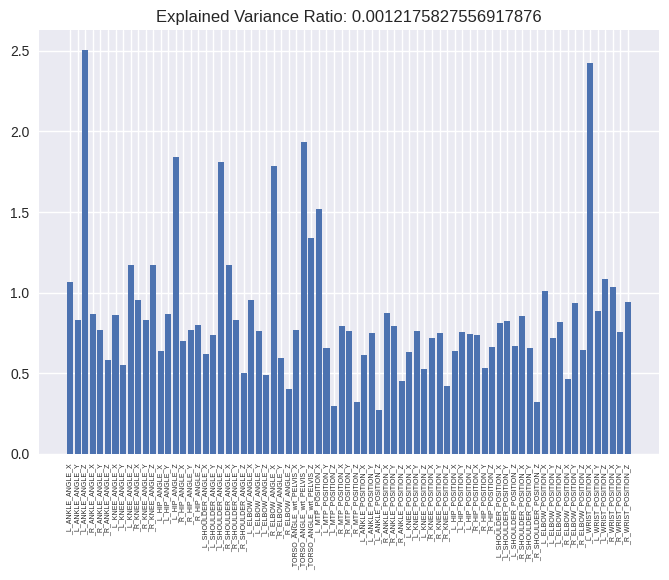

0.001127469560983243


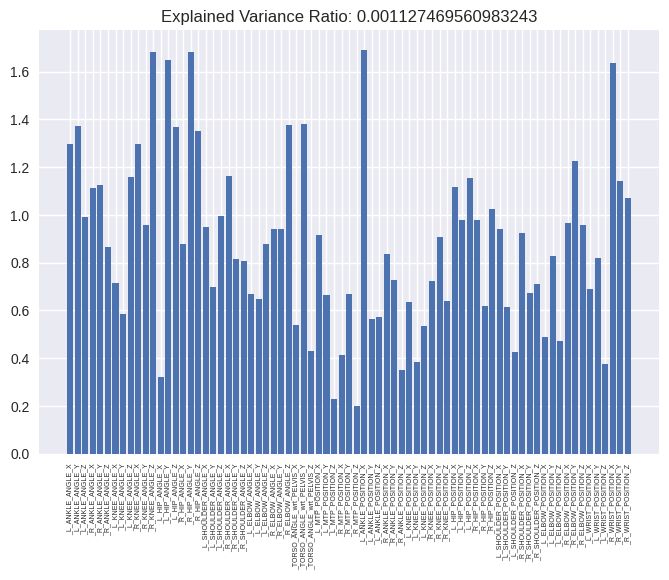

0.001118817222551789


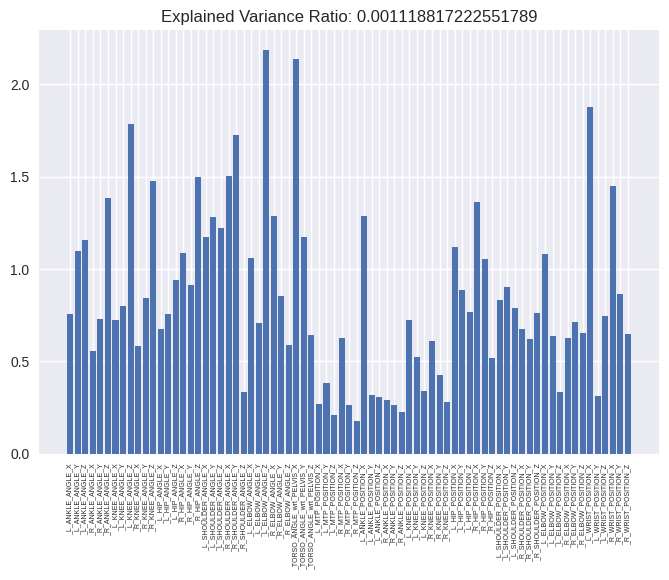

0.0010899782037112503


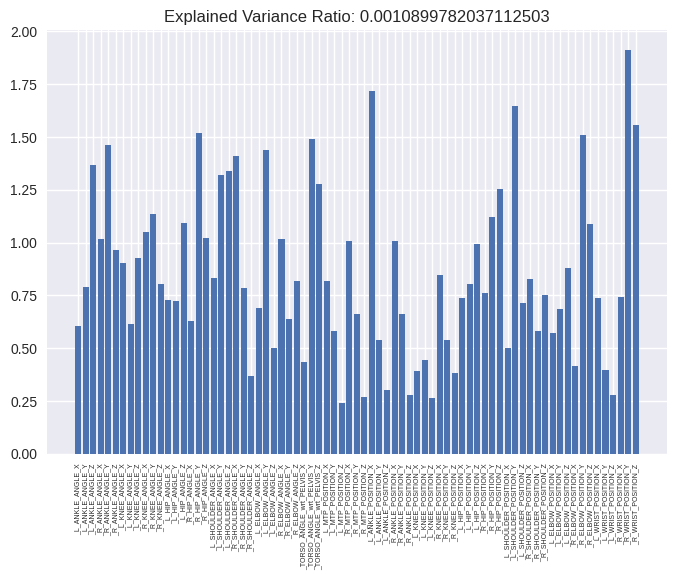

0.001055384973319383


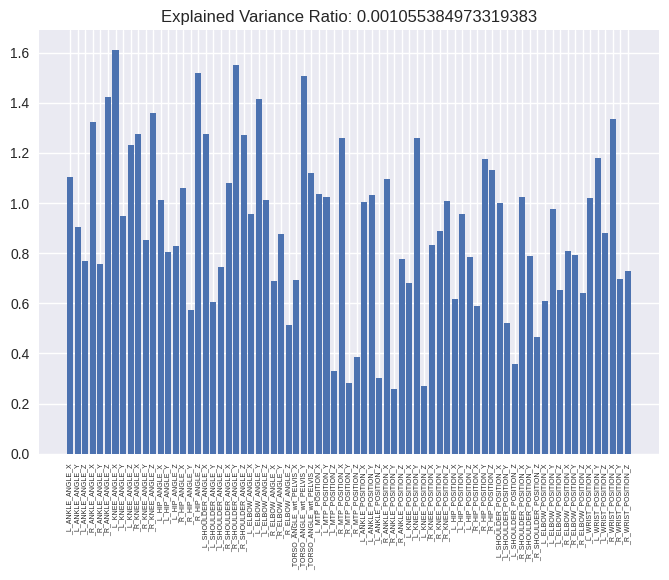

0.00101532918206905


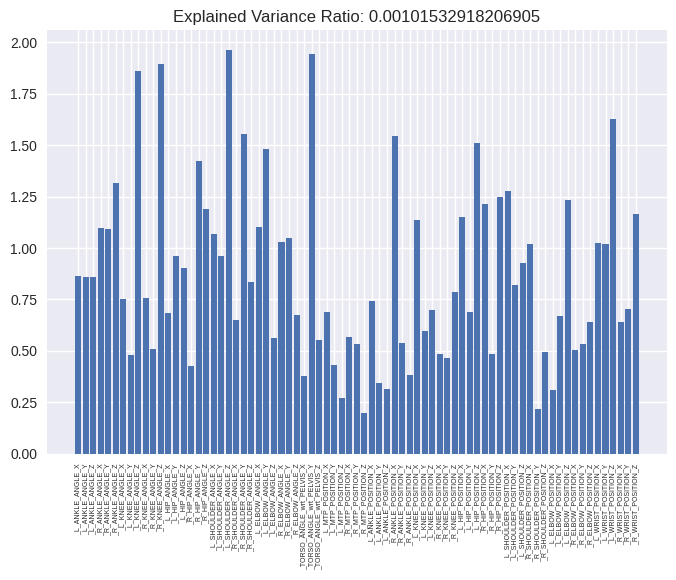

0.000981077148166753


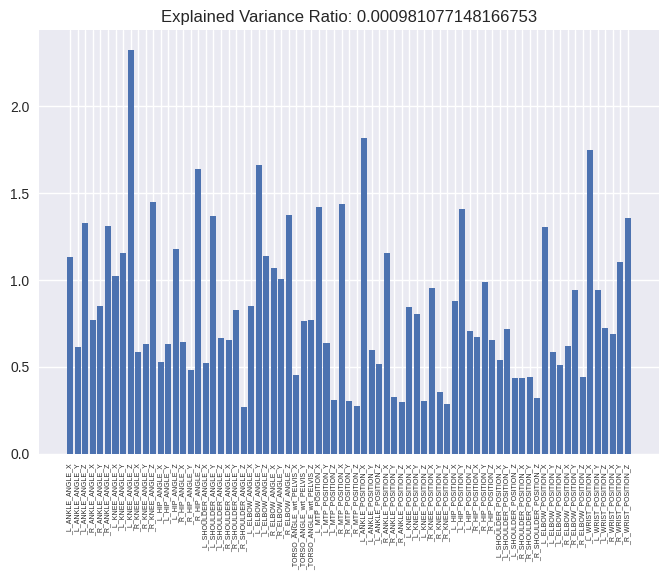

0.0009561077222040136


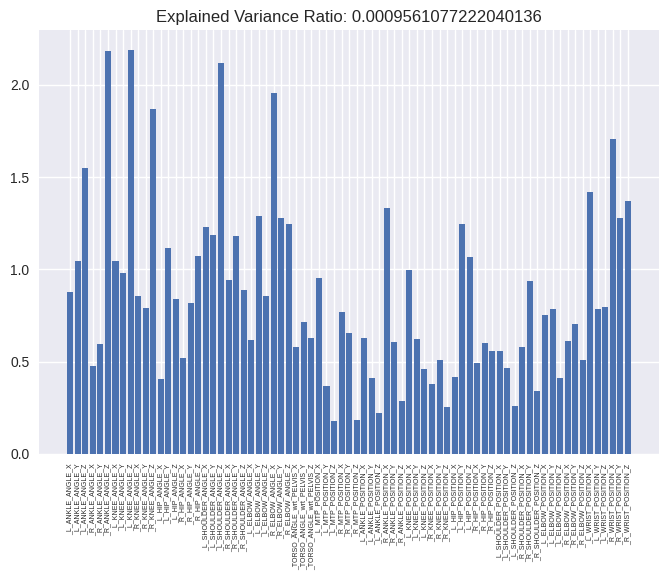

In [ ]:
def plot_pca_components(labels, pca_component, ratio):
  pca_dict = {}
  for i in range(len(pca_component)):
    if all_angle_labels_2[i] not in pca_dict.keys():
      pca_dict[all_angle_labels_2[i]] = abs(pca_component[i])
    else:
      pca_dict[all_angle_labels_2[i]] += abs(pca_component[i])

  """for key,value in pca_dict.items():
    print(key)
    print(value)"""

  print(ratio)
  names = list(pca_dict.keys())
  values = list(pca_dict.values())

  plt.bar(range(len(pca_dict)), values, tick_label=names)
  title = "Explained Variance Ratio: " + str(ratio)
  plt.title(title)
  #plt.xticks(rotation=45, ha='right')
  ax = plt.gca()
  #ax.xaxis.get_label().set_fontsize(20)
  for tick in ax.get_xticklabels():
      tick.set_rotation(90)
      tick.set_fontsize(5)
  plt.show()


component_number = 0

ratio = pca.explained_variance_ratio_
print(np.sum(ratio))
for component in pca.components_:
  plot_pca_components(all_angle_labels_2, component, ratio[component_number])

  component_number+=1

Do a pca where a pca is done on each individual parameter and in the mean 90 percent of the explained variance is kept. The output is flattened to an input vector

In [ ]:
def pca_per_variable(data, labels):
  # data shape is (2095, 100, 57)
  pca = PCA()
  value_count = data.shape[2]
  result_pca = np.zeros((value_count, data.shape[0], data.shape[1]))

  result_components = np.zeros((value_count, data.shape[1], data.shape[1]))

  result_explained_variance_ratio = np.zeros((value_count, data.shape[1]))

  for i in range(value_count):

    value = data[:,:,i]
    scaler = StandardScaler()
    value_scaled =scaler.fit_transform(value)
    result_pca[i] = pca.fit_transform(value_scaled)
    result_components[i] = pca.components_


    result_explained_variance_ratio[i] = pca.explained_variance_ratio_



  for i in range(1,value_count):
    ratio = np.sum(result_explained_variance_ratio[:,0:i], axis = 1)
    if np.mean(ratio) >= 0.9:
      needed_components = i
      break


  result = result_pca[:,:,0:needed_components]
  result = np.swapaxes(result,0,1)
  result = np.reshape(result, (result.shape[0],(result.shape[1]*result.shape[2])))

  print(result_pca.shape)
  print(result.shape)



  feature_names = []
  for label in labels:
    for i in range(needed_components):
      feature_names.append(label+"_Component_" +str(i))

  print(feature_names)


  return result, feature_names, result_components

#test = pca_per_variable(results, angle_labels)

Based on the cutting points the labels for each person are calculated which can be directly used as labels for supervised learning

In [ ]:
def get_person_labels(cutting_points):
  labels = np.array([])

  for i in range(1,len(cutting_points)):

    mult = np.ones(cutting_points[i] - cutting_points[i-1]) * int(i - 1)
    labels = np.concatenate((labels, mult))
  return labels

Based on the spped cutting points the labels for each speed are calculated which can directly be used as labels for supervised learning

In [ ]:

def get_speed_labels(speed_cutting_points):
  labels = np.array([])

  for i in range(1,int((len(speed_cutting_points))/ 3) + 1):

    labels = np.concatenate((labels, np.zeros(speed_cutting_points[i*3-2] - speed_cutting_points[i*3-3])))
    labels = np.concatenate((labels, np.ones(speed_cutting_points[i*3-1] - speed_cutting_points[i*3-2])))
    labels = np.concatenate((labels, np.ones(speed_cutting_points[i*3] - speed_cutting_points[i*3-1])*2))

  return labels


Train a SVM, Random forest and Multi LAyer perceptron for the speed classification task and print the results.

In [ ]:
def leave_one_out(data, speed_labels, person_labels):
  svc = SVC()
  logo = LeaveOneGroupOut()
  parameters = {"kernel":["rbf"]}
  clf_svc = GridSearchCV(svc,parameters,cv=logo, n_jobs=-1)
  clf_svc.fit(data, speed_labels, groups=person_labels)
  df = pd.DataFrame(clf_svc.cv_results_)
  print(df)



  parameters = {"n_estimators":(100, 200), "max_depth":(5,10)}
  rfc = RandomForestClassifier()
  clf_rfc = GridSearchCV(rfc, parameters, cv=logo, n_jobs = -1)
  clf_rfc.fit(data, speed_labels, groups = person_labels)
  df = pd.DataFrame(clf_rfc.cv_results_)
  print(df)


  mlpc = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(4), random_state=1, max_iter = 1500)
  parameters = {"hidden_layer_sizes":(3,6,10)}
  clf_mlpc = GridSearchCV(mlpc, parameters,cv=logo, n_jobs=-1)
  clf_mlpc.fit(data, speed_labels, groups=person_labels)
  df = pd.DataFrame(clf_mlpc.cv_results_)
  print(df)


  return clf_svc, clf_rfc, clf_mlpc

NOT USED
Do training with leave one out classification, used for walking speed classification.

In [ ]:
def leave_one_out_classification(data, speed_labels, cutting_points, classifier):
  """svc = SVC()
  rfc = RandomForestClassifier(max_depth=10, random_state=11)
  mlpc = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(4), random_state=1, max_iter = 1500)
  parameters = {"n_estimators":(100, 200), "max_depth":(5,10)}
  clf = GridSearchCV(rfc, parameters)"""
  feature_importances = np.zeros((len(cutting_points)-1, data.shape[1]))
  print(feature_importances.shape)


  #accuracys_svc = []
  #accuracys_rfc = []
  #accuracys_mlpc = []
  accuracys = []
  print(speed_labels)

  for i in range(1, len(cutting_points)):
    test_data = data[cutting_points[i-1]:cutting_points[i]]
    front_data = data[0:cutting_points[i-1]]
    back_data = data[cutting_points[i]:cutting_points[len(cutting_points)-1]]
    train_data = np.concatenate((front_data, back_data), axis = 0)

    test_labels = speed_labels[cutting_points[i-1]:cutting_points[i]]
    front_labels = speed_labels[0:cutting_points[i-1]]
    back_labels = speed_labels[cutting_points[i]:cutting_points[len(cutting_points)-1]]
    train_labels = np.concatenate((front_labels, back_labels), axis = 0)

    classifier.fit(train_data,train_labels)
    feature_importances[i-1] = classifier.feature_importances_
    y_predicted= classifier.predict(test_data)
    #print(y_predicted)
    accuracy = accuracy_score(test_labels, y_predicted)
    accuracys.append(accuracy)

  print(accuracys)
  return np.mean(accuracys), feature_importances


#leave_one_out_classification(pca_transformed, get_speed_labels(speed_cutting_points),cutting_points)
#leave_one_out_classification(pca_transformed_2, get_speed_labels(speed_cutting_points),cutting_points)

Show the influence of different timepoints for different pca components ordered by the feature importance of the random forest. Using the individual pca preprocessing

(75, 100, 100)
(300,)
(300,)
0
_R_MTP_POSITION_Y_Component_0
0.07292196102644377
_R_ANKLE_POSITION_Y_Component_0
0.07087207079311666
_L_MTP_POSITION_Y_Component_0
0.06385298611404544
_L_ANKLE_POSITION_Y_Component_0
0.05531295102670483
_L_HIP_ANGLE_X_Component_0
0.04939618646165612
_R_HIP_ANGLE_X_Component_0
0.0483940198748633
_R_KNEE_POSITION_Y_Component_0
0.03823059127842809
_L_HIP_POSITION_Z_Component_0
0.03540381826982549
_R_MTP_POSITION_Z_Component_1
0.033390681007023464
_R_KNEE_ANGLE_X_Component_1
0.03286796538216713
_R_HIP_POSITION_Z_Component_0
0.03138750937759289
_L_MTP_POSITION_Z_Component_1
0.028944877775351725
_L_ELBOW_ANGLE_X_Component_1
0.025865683276446068
_L_ANKLE_POSITION_Z_Component_1
0.024401270566602414
_R_ANKLE_POSITION_Z_Component_1
0.023061846446635916
_L_KNEE_POSITION_Y_Component_0
0.02302828282989728
_R_SHOULDER_POSITION_Z_Component_1
0.022507157047491413
_L_SHOULDER_POSITION_Z_Component_1
0.019781705731463872
_TORSO_ANGLE_wrt_PELVIS_Z_Component_1
0.018694487846

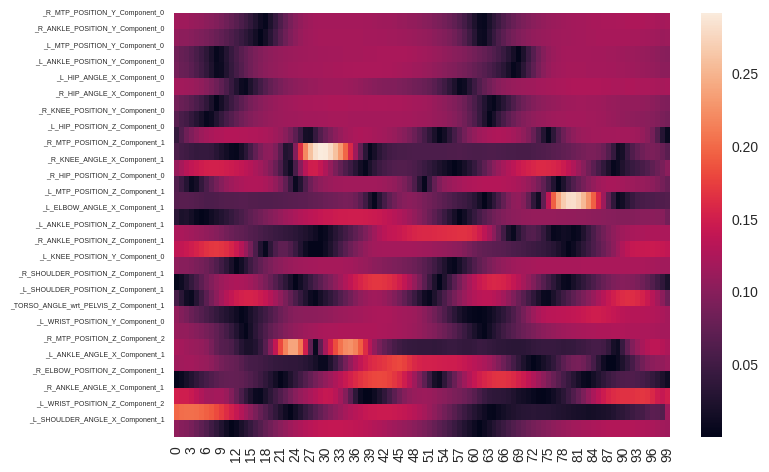

In [ ]:
def plot_forest(pca_components, feature_names, importance, argsort, relevant_features):
  print(pca_components.shape)
  print(importance.shape)
  print(argsort.shape)
  print(np.min(argsort))
  used_components = int(importance.shape[0] / pca_components.shape[0])
  heat = np.zeros((relevant_features, pca_components.shape[2]))

  tick_labels = []
  i = 0
  for a in argsort[0:relevant_features]:
    print(feature_names[a])
    print(importance[a])
    component_number = int(a/used_components)
    component_number_inside = (int(a%used_components))
    component= pca_components[component_number,component_number_inside]
    heat[i] = component
    tick_labels.append(feature_names[a])
    i +=1


  print(heat.shape)

  """ax = sns.heatmap(
    (np.abs(heat)),
    vmin=-0.5, vmax=0.5, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False
    )"""
  ax = sns.heatmap(np.abs(heat))


  ax.set_yticks(range(0,relevant_features), labels=tick_labels)
  for tick in ax.get_yticklabels():
    tick.set_rotation(0)
    tick.set_fontsize(5)
  plt.show()

plot_forest(pca_components, feature_names, importance, argsort, relevant_features)

NOT USED
Train a Random Forest for the walking speed classification task and show the most important features


(75, 3631, 100)
(3631, 300)
['_L_ANKLE_ANGLE_X_Component_0', '_L_ANKLE_ANGLE_X_Component_1', '_L_ANKLE_ANGLE_X_Component_2', '_L_ANKLE_ANGLE_X_Component_3', '_L_ANKLE_ANGLE_Y_Component_0', '_L_ANKLE_ANGLE_Y_Component_1', '_L_ANKLE_ANGLE_Y_Component_2', '_L_ANKLE_ANGLE_Y_Component_3', '_L_ANKLE_ANGLE_Z_Component_0', '_L_ANKLE_ANGLE_Z_Component_1', '_L_ANKLE_ANGLE_Z_Component_2', '_L_ANKLE_ANGLE_Z_Component_3', '_R_ANKLE_ANGLE_X_Component_0', '_R_ANKLE_ANGLE_X_Component_1', '_R_ANKLE_ANGLE_X_Component_2', '_R_ANKLE_ANGLE_X_Component_3', '_R_ANKLE_ANGLE_Y_Component_0', '_R_ANKLE_ANGLE_Y_Component_1', '_R_ANKLE_ANGLE_Y_Component_2', '_R_ANKLE_ANGLE_Y_Component_3', '_R_ANKLE_ANGLE_Z_Component_0', '_R_ANKLE_ANGLE_Z_Component_1', '_R_ANKLE_ANGLE_Z_Component_2', '_R_ANKLE_ANGLE_Z_Component_3', '_L_KNEE_ANGLE_X_Component_0', '_L_KNEE_ANGLE_X_Component_1', '_L_KNEE_ANGLE_X_Component_2', '_L_KNEE_ANGLE_X_Component_3', '_L_KNEE_ANGLE_Y_Component_0', '_L_KNEE_ANGLE_Y_Component_1', '_L_KNEE_ANGLE_Y_

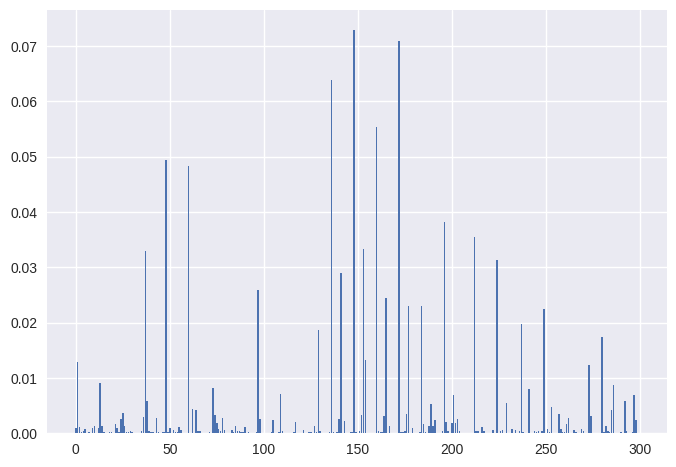

In [ ]:
def train_random_forest_speeds(data, speed_labels, cutting_points, feature_names):

  parameters = {"n_estimators":(100, 200), "max_depth":(5,10)}
  rfc = RandomForestClassifier(n_estimators=200, max_depth=10)
  score, feature_importances = leave_one_out_classification(data,speed_labels, cutting_points, rfc)

  print(data.shape)

  importance = np.mean(feature_importances, axis = 0)



  argsort = np.flip(np.argsort(importance))
  sorted_importance = np.flip(np.sort(importance))

  importance_sum = 1

  for i in range(1,len(sorted_importance)):
    if np.sum(sorted_importance[0:i]) >= 0.8:
      relevant_features = i
      break

  plt.bar(range(len(importance)), importance)
  plt.show()

  """for a in argsort[0:relevant_features]:
    print(feature_names[a])
    print(importance[a])"""

  return importance, argsort, relevant_features

#train_random_forest_speeds(pca_transformed, get_speed_labels(speed_cutting_points), cutting_points)

pca_per, feature_names, pca_components = pca_per_variable(results,angle_labels)


importance, argsort, relevant_features = train_random_forest_speeds(pca_per, get_speed_labels(speed_cutting_points), cutting_points, feature_names)

Plot the contribution of the right ankle position y over time to its pca component and its value over time.

(3631, 100, 75)
(3631, 100)
(100,)


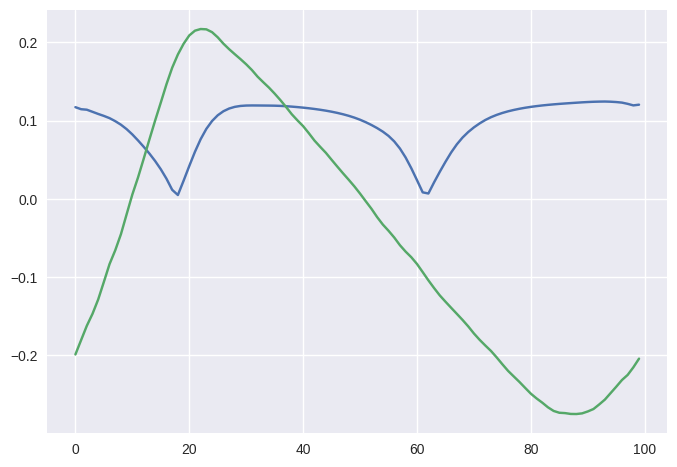

In [ ]:
left_ankle_y = column_names.columns.get_loc(build_extractor(0, site =(["R"]), parameters = ["ANKLE_POSITION"], axes=["Y"])[0][0])
print(results.shape)
test = results[:,:,left_ankle_y]
print(test.shape)
a = argsort[0]
used_components = int(importance.shape[0] / pca_components.shape[0])
component_number = int(a/used_components)
component_number_inside = (int(a%used_components))
component= pca_components[component_number,component_number_inside]
print(component.shape)
plt.plot(np.abs(component))
plt.plot(test[0])
plt.show()


The training of the three classifiers for the person classification task.

In [ ]:
def train_svc(X_train, X_test, y_train, y_test):
  svc = SVC()

  svc.fit(X_train, y_train)

  y_predicted_svc = svc.predict(X_test)
  accuracy_svc = accuracy_score(y_test, y_predicted_svc)
  print("Accuracy SVC: " + str(accuracy_svc))
  return y_predicted_svc

def train_random_forest(X_train, X_test, y_train, y_test):
  rfc = RandomForestClassifier(max_depth=10, random_state=11)
  #clf = GridSearch

  rfc.fit(X_train, y_train)
  y_predicted_rfc = rfc.predict(X_test)
  accuracy_rfc = accuracy_score(y_test, y_predicted_rfc)
  print("Accuracy RandomForestClassifier: " + str(accuracy_rfc))
  return y_predicted_rfc

def train_mlpc(X_train, X_test, y_train, y_test):
  mlpc = MLPClassifier(solver='sgd', alpha=1e-5, random_state=1, max_iter = 1500)
  kfold = KFold(shuffle=True)
  parameters = {"hidden_layer_sizes":(5,10,15)}
  clf = GridSearchCV(mlpc, parameters,cv=kfold, n_jobs=-1)


  clf.fit(X_train, y_train)
  df = pd.DataFrame(clf.cv_results_)
  print(df)

  y_predicted_mlpc = clf.predict(X_test)

  accuracy_mlpc = accuracy_score(y_test, y_predicted_mlpc)
  print("Accuracy MultiLayerPerceptron: " + str(accuracy_mlpc))
  return y_predicted_mlpc


Training and plotting of the confusion matrices for the person classification task


In [ ]:
def train_person_classifier(data, cutting_points):
  person_labels = get_person_labels(cutting_points)
  X_train, X_test, y_train, y_test = train_test_split(data, person_labels, test_size=0.2, random_state=21)
  plt.style.use('default')
  fig, ax = plt.subplots(1,3,figsize=(30,10))
  ax = ax.flatten()
  y_predicted_svc = train_svc(X_train, X_test, y_train, y_test)
  y_predicted_rfc = train_random_forest(X_train, X_test, y_train, y_test)
  y_predicted_mlpc = train_mlpc(X_train, X_test, y_train, y_test)
  ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_svc, ax = ax[0])
  ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_rfc, ax = ax[1])
  ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_mlpc, ax = ax[2])


  for a in ax:
    a.plot()

  ax[0].set_title("Confusion Matrix Support Vector Classifier")
  ax[1].set_title("Confusion Matrix Random Forest Classifier")
  ax[2].set_title("Confusion Matrix MLPC Classifier")
  plt.show()


In [ ]:
#train_person_classifier(pca_transformed, cutting_points)
#train_person_classifier(pca_transformed_2, cutting_points)
#train_person_classifier(scaled_data, cutting_points)

Get the just scaled data as input vector

In [ ]:
def normal_data(data):
  scaler = StandardScaler()
  data = np.reshape(data,(data.shape[0], data.shape[1] *data.shape[2]))
  data = scaler.fit_transform(data)
  return data

Function to extract only the walking data needed for a scenario

In [ ]:
def extract_scenario(parameters, data, column_names):
  values = build_extractor(0, parameters=parameters)[0]
  data = np.zeros((results.shape[0], 100, len(values)))
  positions = []
  i=0
  for value in values:
    position = column_names.columns.get_loc(value)
    data[:,:,i] = results[:,:,position]
    i += 1
    positions.append(position)
  return data,positions



In [ ]:
speed_labels = get_speed_labels(speed_cutting_points)
person_labels = get_person_labels(cutting_points)

In the following all preprocessing and training for all scenarios is done. Therefore, the wanted data is loaded, and then the 4 preprocessing methods are applied. Afterwards the person classification task and the speed classification task are executed.

In [ ]:
lower_body_angles, lba_positions= extract_scenario((["ANKLE_ANGLE", "KNEE_ANGLE", "HIP_ANGLE"]), results, column_names)
lba_labels = np.take(angle_labels, lba_positions)
lba_scaled_data = normal_data(lower_body_angles)
lba_pca_all_data, lba_pca_all = pca_all(lower_body_angles)
lba_pca_vector_data,lba_pca_vector = pca_vector(lower_body_angles)
lba_pca_per_variable_data, lba_pca_per_feature_names, lba_pca_per_components = pca_per_variable(lower_body_angles, lba_labels)
#feature_names, result_components

(3631, 1800)
(3631, 1800)
(18, 3631, 100)
(3631, 180)
['_L_ANKLE_ANGLE_X_Component_0', '_L_ANKLE_ANGLE_X_Component_1', '_L_ANKLE_ANGLE_X_Component_2', '_L_ANKLE_ANGLE_X_Component_3', '_L_ANKLE_ANGLE_X_Component_4', '_L_ANKLE_ANGLE_X_Component_5', '_L_ANKLE_ANGLE_X_Component_6', '_L_ANKLE_ANGLE_X_Component_7', '_L_ANKLE_ANGLE_X_Component_8', '_L_ANKLE_ANGLE_X_Component_9', '_L_ANKLE_ANGLE_Y_Component_0', '_L_ANKLE_ANGLE_Y_Component_1', '_L_ANKLE_ANGLE_Y_Component_2', '_L_ANKLE_ANGLE_Y_Component_3', '_L_ANKLE_ANGLE_Y_Component_4', '_L_ANKLE_ANGLE_Y_Component_5', '_L_ANKLE_ANGLE_Y_Component_6', '_L_ANKLE_ANGLE_Y_Component_7', '_L_ANKLE_ANGLE_Y_Component_8', '_L_ANKLE_ANGLE_Y_Component_9', '_L_ANKLE_ANGLE_Z_Component_0', '_L_ANKLE_ANGLE_Z_Component_1', '_L_ANKLE_ANGLE_Z_Component_2', '_L_ANKLE_ANGLE_Z_Component_3', '_L_ANKLE_ANGLE_Z_Component_4', '_L_ANKLE_ANGLE_Z_Component_5', '_L_ANKLE_ANGLE_Z_Component_6', '_L_ANKLE_ANGLE_Z_Component_7', '_L_ANKLE_ANGLE_Z_Component_8', '_L_ANKLE_ANGLE_Z

Accuracy SVC: 0.9972489683631361
Accuracy RandomForestClassifier: 0.9986244841815681
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      17.561315     11.290944         0.008446        0.001499   
1       4.917503      0.654111         0.009562        0.005541   
2       5.676932      1.220035         0.007996        0.000621   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}                1.0   
1                       10  {'hidden_layer_sizes': 10}                1.0   
2                       15  {'hidden_layer_sizes': 15}                1.0   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.996558           0.996558           0.996558           0.998276   
1           1.000000           0.996558           0.998279           0.998276   
2           0.998279           0.998279           0.996558           1.000000   

   mean_test

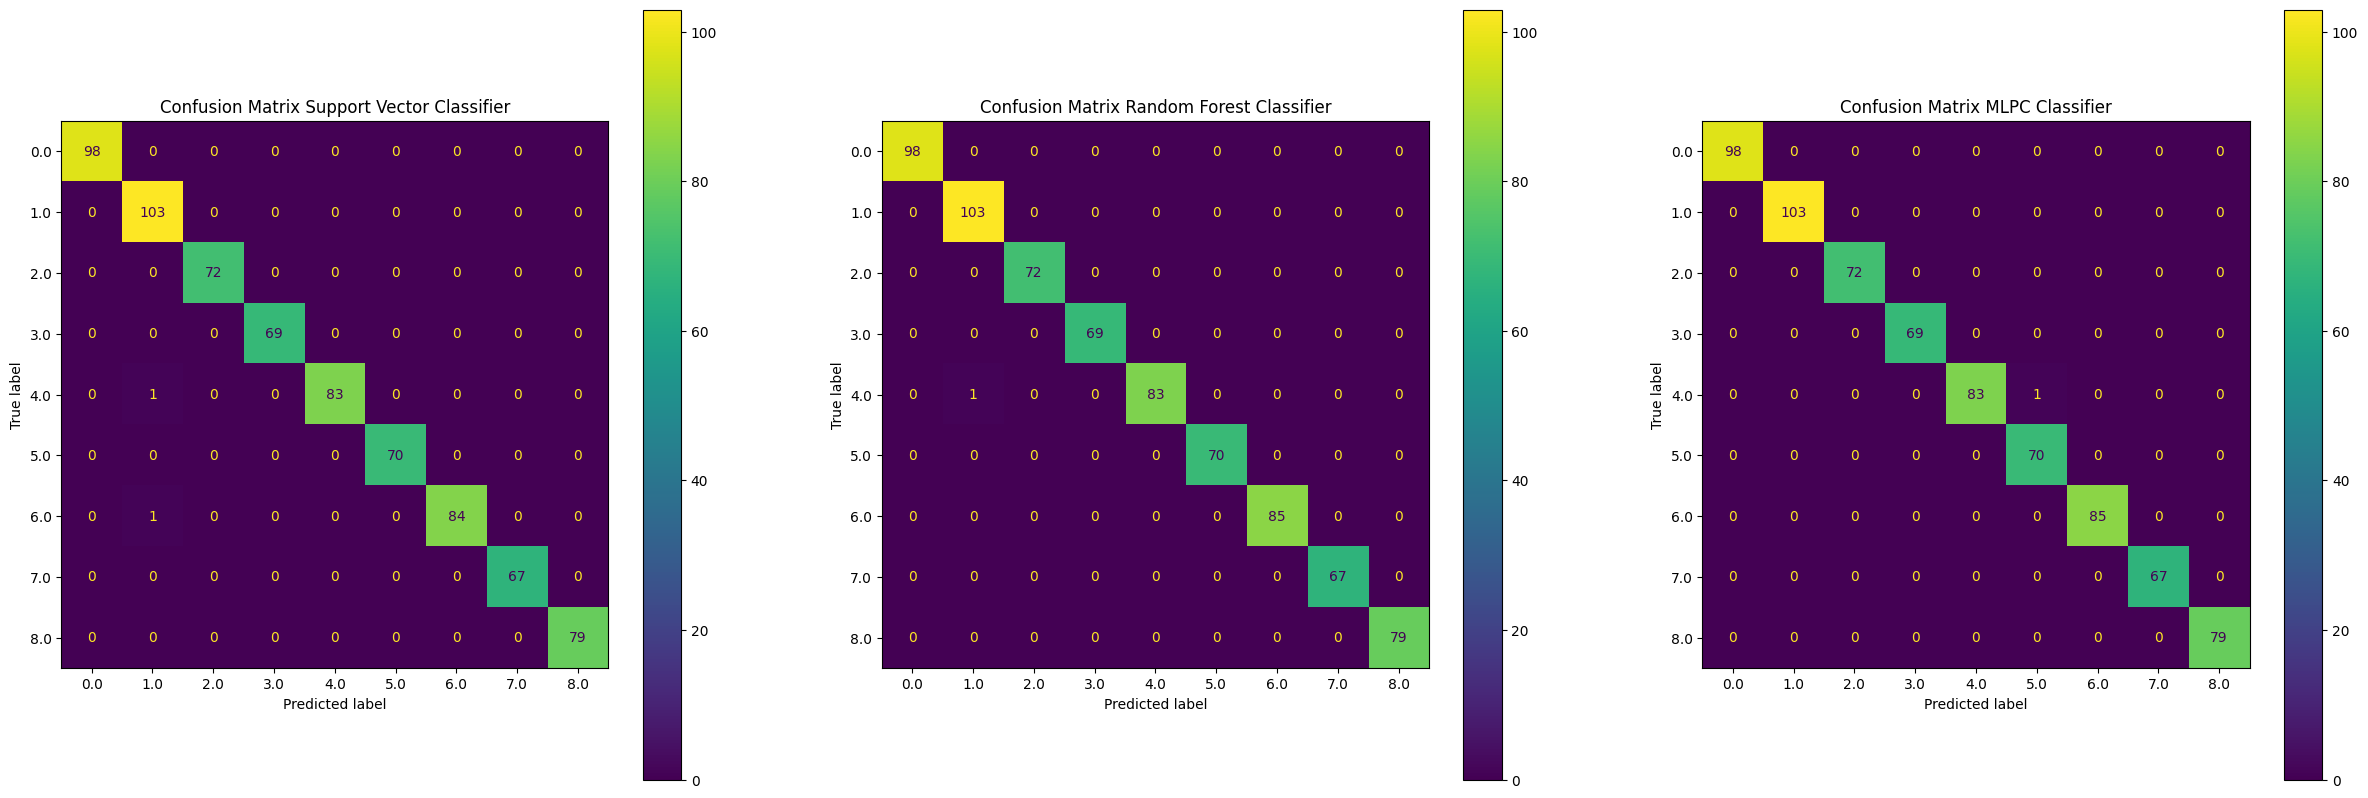

Accuracy SVC: 0.9986244841815681
Accuracy RandomForestClassifier: 0.9986244841815681
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       6.016435      0.851091         0.006670        0.002150   
1       5.442298      0.956977         0.005521        0.000662   
2       4.562394      1.384235         0.005222        0.000919   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.994836   
1                       10  {'hidden_layer_sizes': 10}           0.996558   
2                       15  {'hidden_layer_sizes': 15}           0.998279   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.998279           0.994836           0.998279           0.996552   
1           0.998279           0.994836           1.000000           0.996552   
2           0.998279           0.998279           1.000000           0.998276   

   mean_test

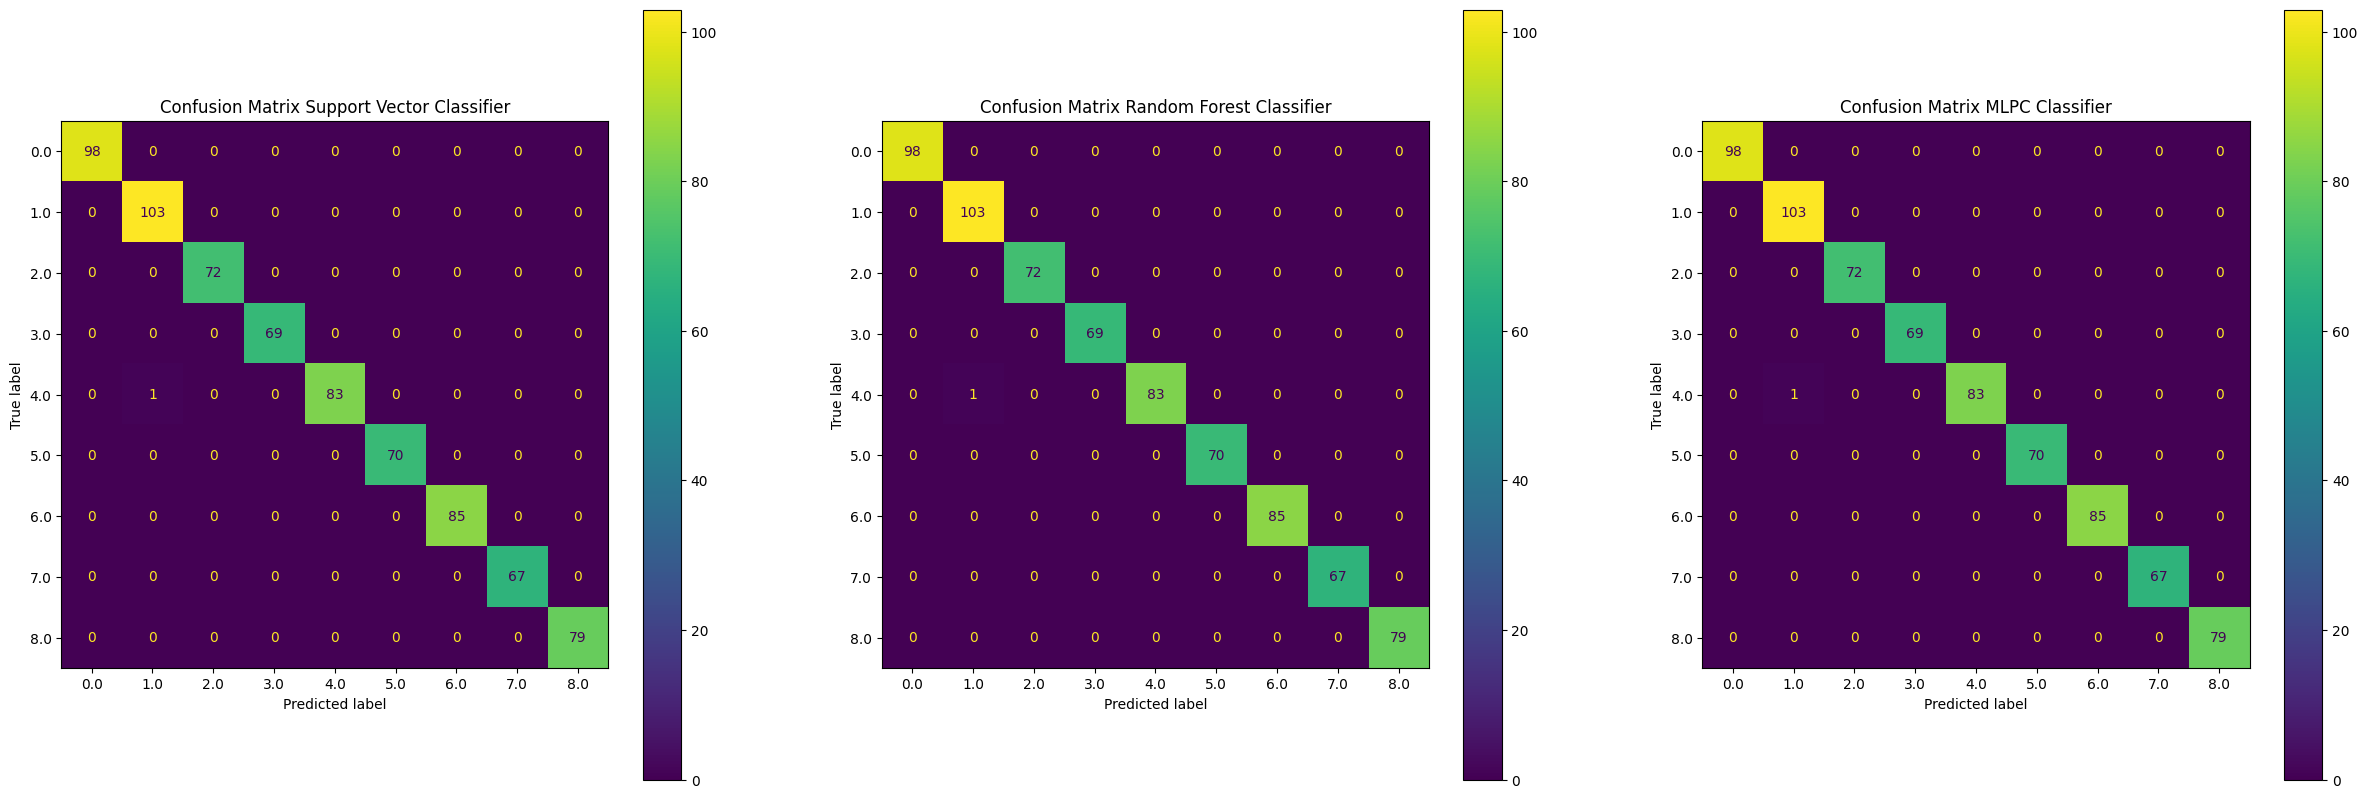

Accuracy SVC: 0.9986244841815681
Accuracy RandomForestClassifier: 0.9986244841815681
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       4.924514      1.321370         0.003015        0.001705   
1       0.916578      0.033239         0.002256        0.000190   
2       0.888460      0.037577         0.002220        0.000072   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.996558   
1                       10  {'hidden_layer_sizes': 10}           0.996558   
2                       15  {'hidden_layer_sizes': 15}           0.996558   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0                1.0           1.000000           0.994836           0.996552   
1                1.0           0.998279           0.994836           0.996552   
2                1.0           0.994836           0.998279           0.998276   

   mean_test

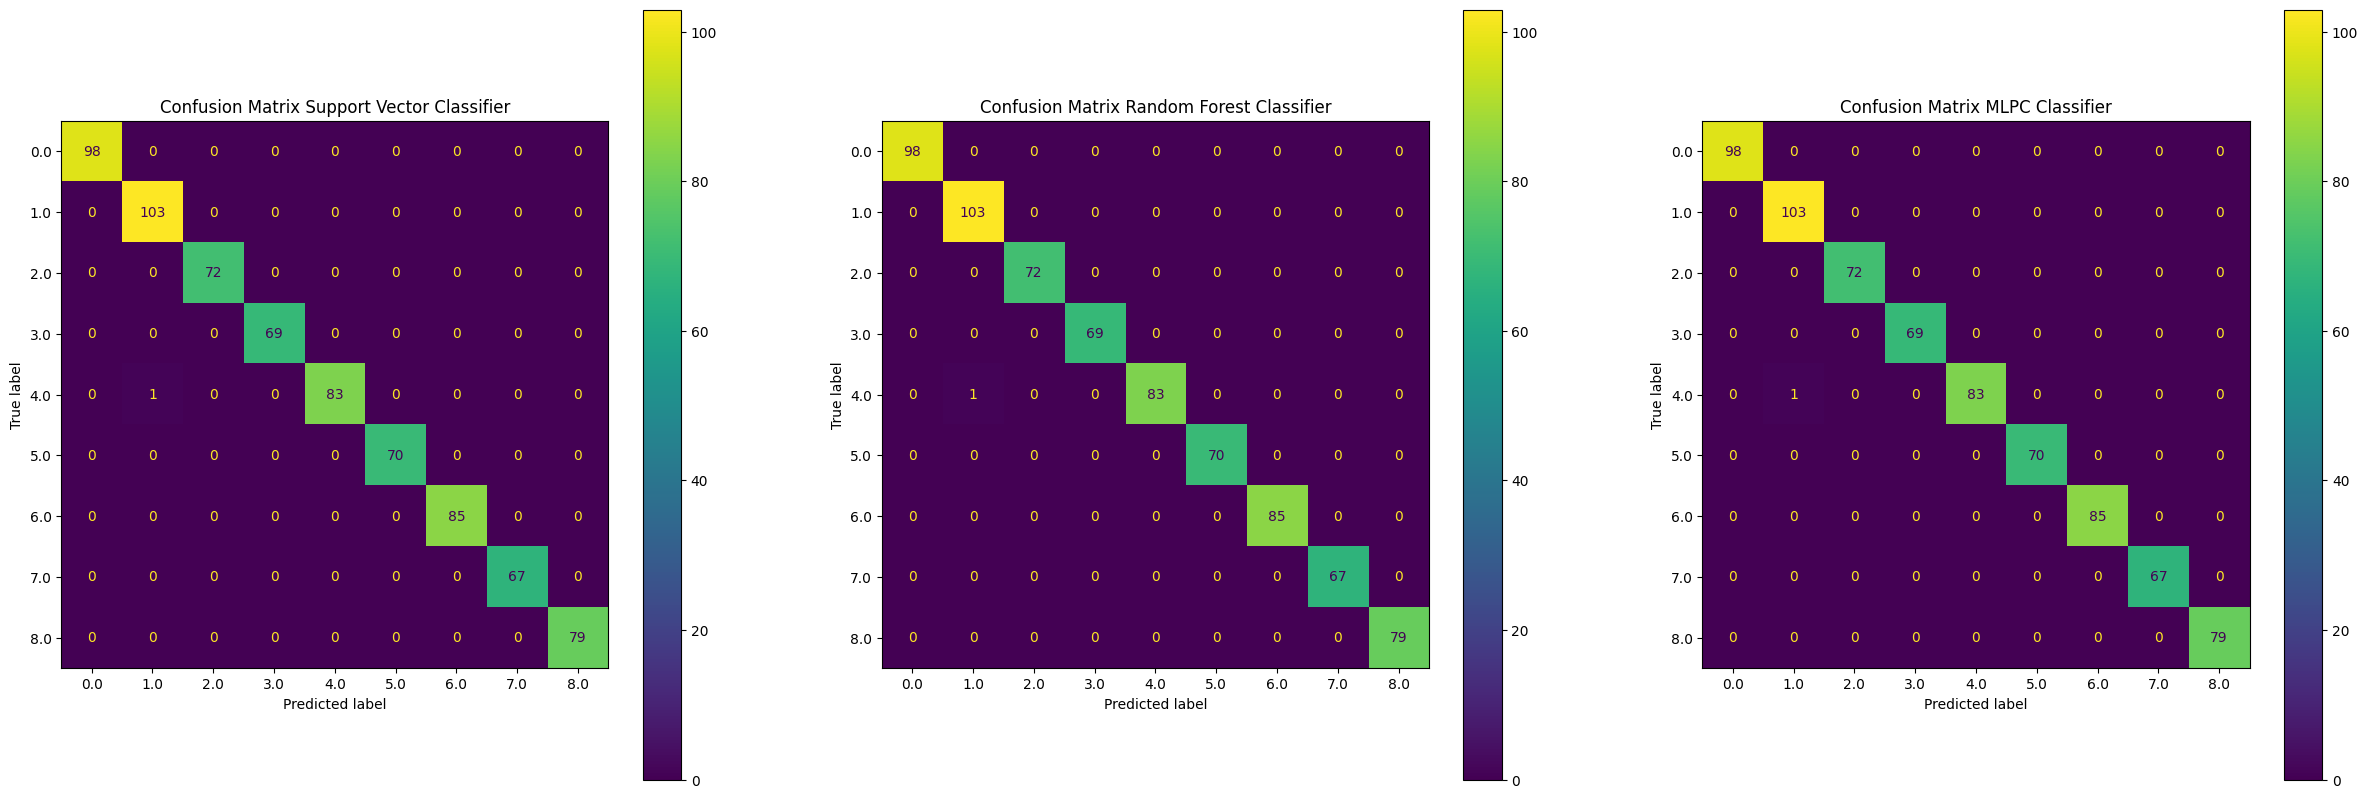

Accuracy SVC: 0.9986244841815681
Accuracy RandomForestClassifier: 0.9986244841815681
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       5.725884      0.816340         0.002914        0.001165   
1       1.559018      0.434107         0.002956        0.001180   
2       0.991020      0.118458         0.002273        0.000348   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.998279   
1                       10  {'hidden_layer_sizes': 10}           0.994836   
2                       15  {'hidden_layer_sizes': 15}           0.996558   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.998279           0.998279           0.996558           0.998276   
1           0.996558           1.000000           1.000000           1.000000   
2           0.998279           1.000000           0.998279           1.000000   

   mean_test

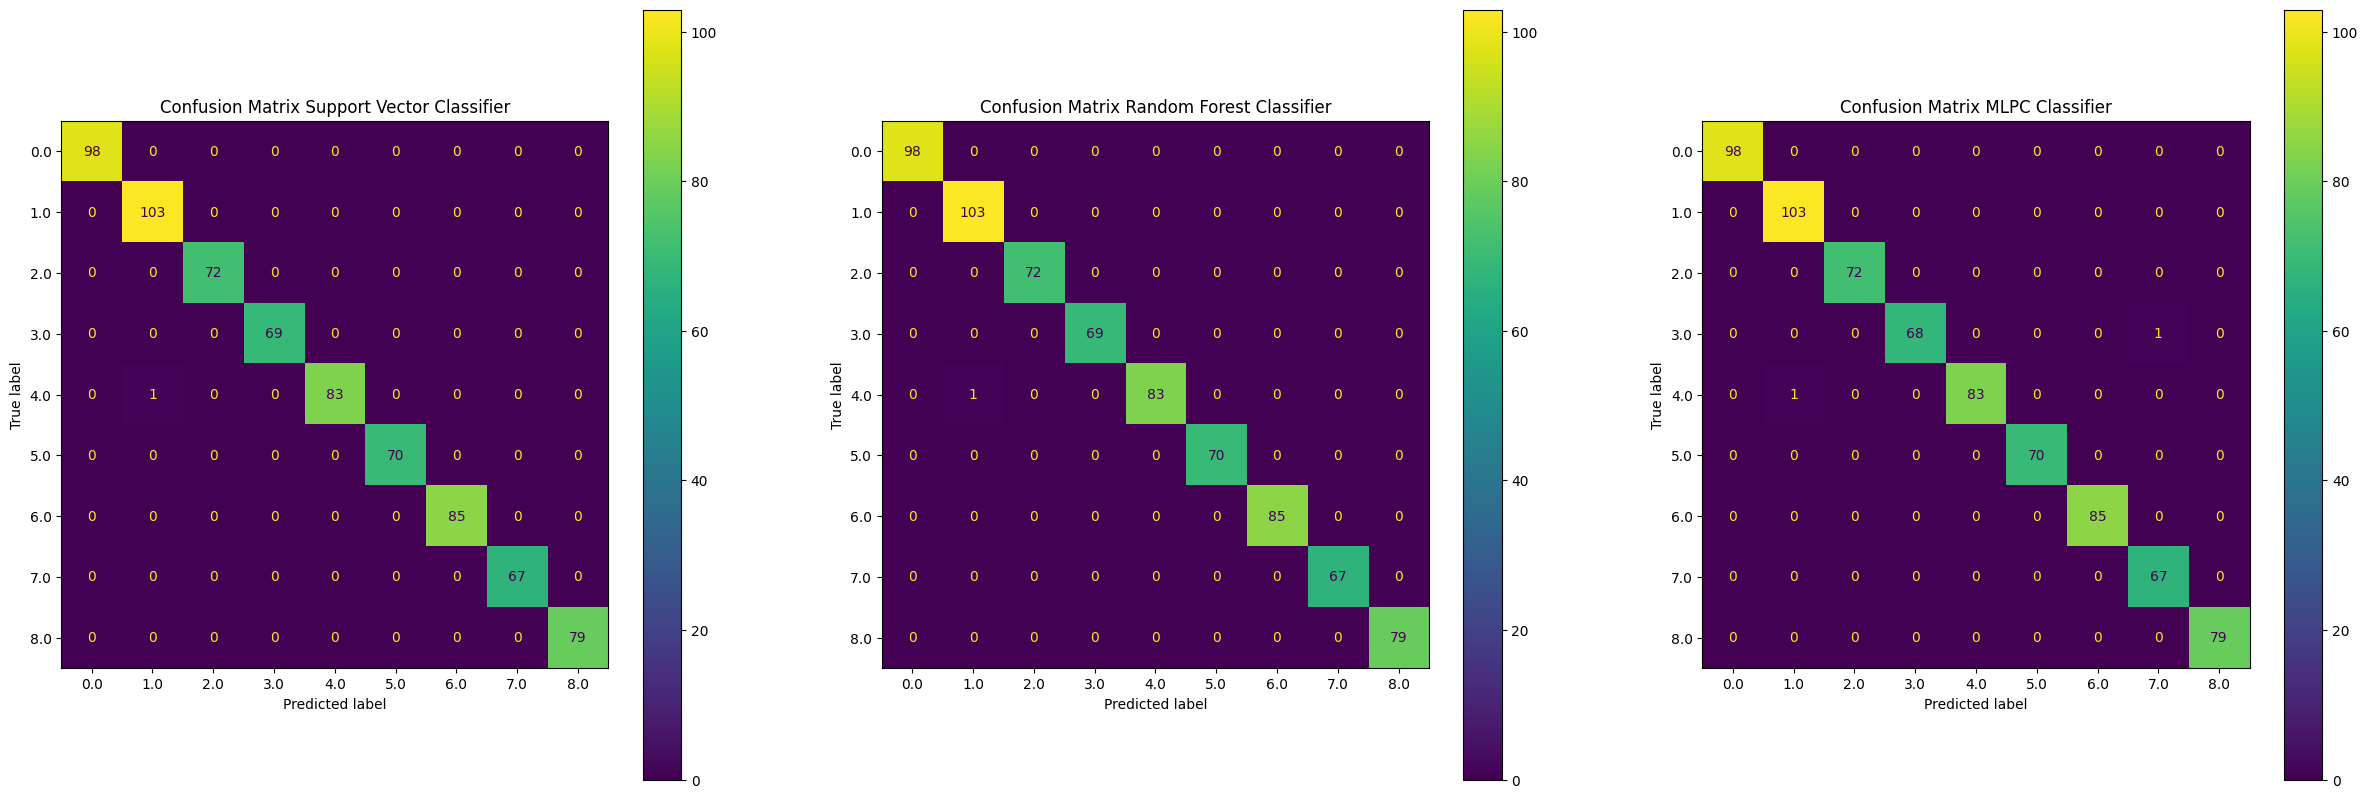

In [ ]:
train_person_classifier(lba_scaled_data, cutting_points)
train_person_classifier(lba_pca_all_data, cutting_points)
train_person_classifier(lba_pca_vector_data, cutting_points)
train_person_classifier(lba_pca_per_variable_data, cutting_points)

In [ ]:
lba_svc_0, lba_rfc_0, lba_mlpc_0 = leave_one_out(lba_scaled_data, get_speed_labels(speed_cutting_points), get_person_labels(cutting_points))
lba_svc_1, lba_rfc_1, lba_mlpc_1 = leave_one_out(lba_pca_all_data, get_speed_labels(speed_cutting_points), get_person_labels(cutting_points))
lba_svc_2, lba_rfc_2, lba_mlpc_2 = leave_one_out(lba_pca_vector_data, get_speed_labels(speed_cutting_points), get_person_labels(cutting_points))
lba_svc_3, lba_rfc_3, lba_mlpc_3 = leave_one_out(lba_pca_per_variable_data, get_speed_labels(speed_cutting_points), get_person_labels(cutting_points))

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_kernel  \
0       4.662153       0.87917          0.94357        0.528588          rbf   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'kernel': 'rbf'}           0.982721           0.995699                1.0   

   split3_test_score  split4_test_score  split5_test_score  split6_test_score  \
0                1.0           0.997608           0.997319           0.888889   

   split7_test_score  split8_test_score  mean_test_score  std_test_score  \
0           0.997368            0.97416         0.981529        0.033796   

   rank_test_score  
0                1  
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      12.711045      1.152344         0.025092        0.006458   
1      25.164147      0.977805         0.067678        0.027208   
2      14.955962      0.730678         0.031884        0.012208   
3      28.740777      2.921235         0.052068   

In [ ]:
lower_body_positions, lbp_positions= extract_scenario((["MTP_POSITION","ANKLE_POSITION", "KNEE_POSITION", "HIP_POSITION"]), results, column_names)
lbp_labels = np.take(angle_labels, lbp_positions)
lbp_scaled_data = normal_data(lower_body_positions)
lbp_pca_all_data, lbp_pca_all = pca_all(lower_body_positions)
lbp_pca_vector_data,lbp_pca_vector = pca_vector(lower_body_positions)
lbp_pca_per_variable_data, lbp_pca_per_feature_names, lbp_pca_per_components = pca_per_variable(lower_body_positions, lbp_labels)
#feature_names, result_components

(3631, 2400)
(3631, 2400)
(24, 3631, 100)
(3631, 72)
['_L_MTP_POSITION_X_Component_0', '_L_MTP_POSITION_X_Component_1', '_L_MTP_POSITION_X_Component_2', '_L_MTP_POSITION_Y_Component_0', '_L_MTP_POSITION_Y_Component_1', '_L_MTP_POSITION_Y_Component_2', '_L_MTP_POSITION_Z_Component_0', '_L_MTP_POSITION_Z_Component_1', '_L_MTP_POSITION_Z_Component_2', '_R_MTP_POSITION_X_Component_0', '_R_MTP_POSITION_X_Component_1', '_R_MTP_POSITION_X_Component_2', '_R_MTP_POSITION_Y_Component_0', '_R_MTP_POSITION_Y_Component_1', '_R_MTP_POSITION_Y_Component_2', '_R_MTP_POSITION_Z_Component_0', '_R_MTP_POSITION_Z_Component_1', '_R_MTP_POSITION_Z_Component_2', '_L_ANKLE_POSITION_X_Component_0', '_L_ANKLE_POSITION_X_Component_1', '_L_ANKLE_POSITION_X_Component_2', '_L_ANKLE_POSITION_Y_Component_0', '_L_ANKLE_POSITION_Y_Component_1', '_L_ANKLE_POSITION_Y_Component_2', '_L_ANKLE_POSITION_Z_Component_0', '_L_ANKLE_POSITION_Z_Component_1', '_L_ANKLE_POSITION_Z_Component_2', '_R_ANKLE_POSITION_X_Component_0', '_

Accuracy SVC: 0.9986244841815681
Accuracy RandomForestClassifier: 0.9986244841815681
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      13.966547      1.065244         0.012292        0.003546   
1       9.317096      1.359983         0.009485        0.001029   
2       9.560669      2.017289         0.012653        0.005005   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.998279   
1                       10  {'hidden_layer_sizes': 10}           0.998279   
2                       15  {'hidden_layer_sizes': 15}           0.998279   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           1.000000           0.998279           0.991394                1.0   
1           0.998279           0.998279           0.996558                1.0   
2           0.998279           0.998279           0.998279                1.0   

   mean_test

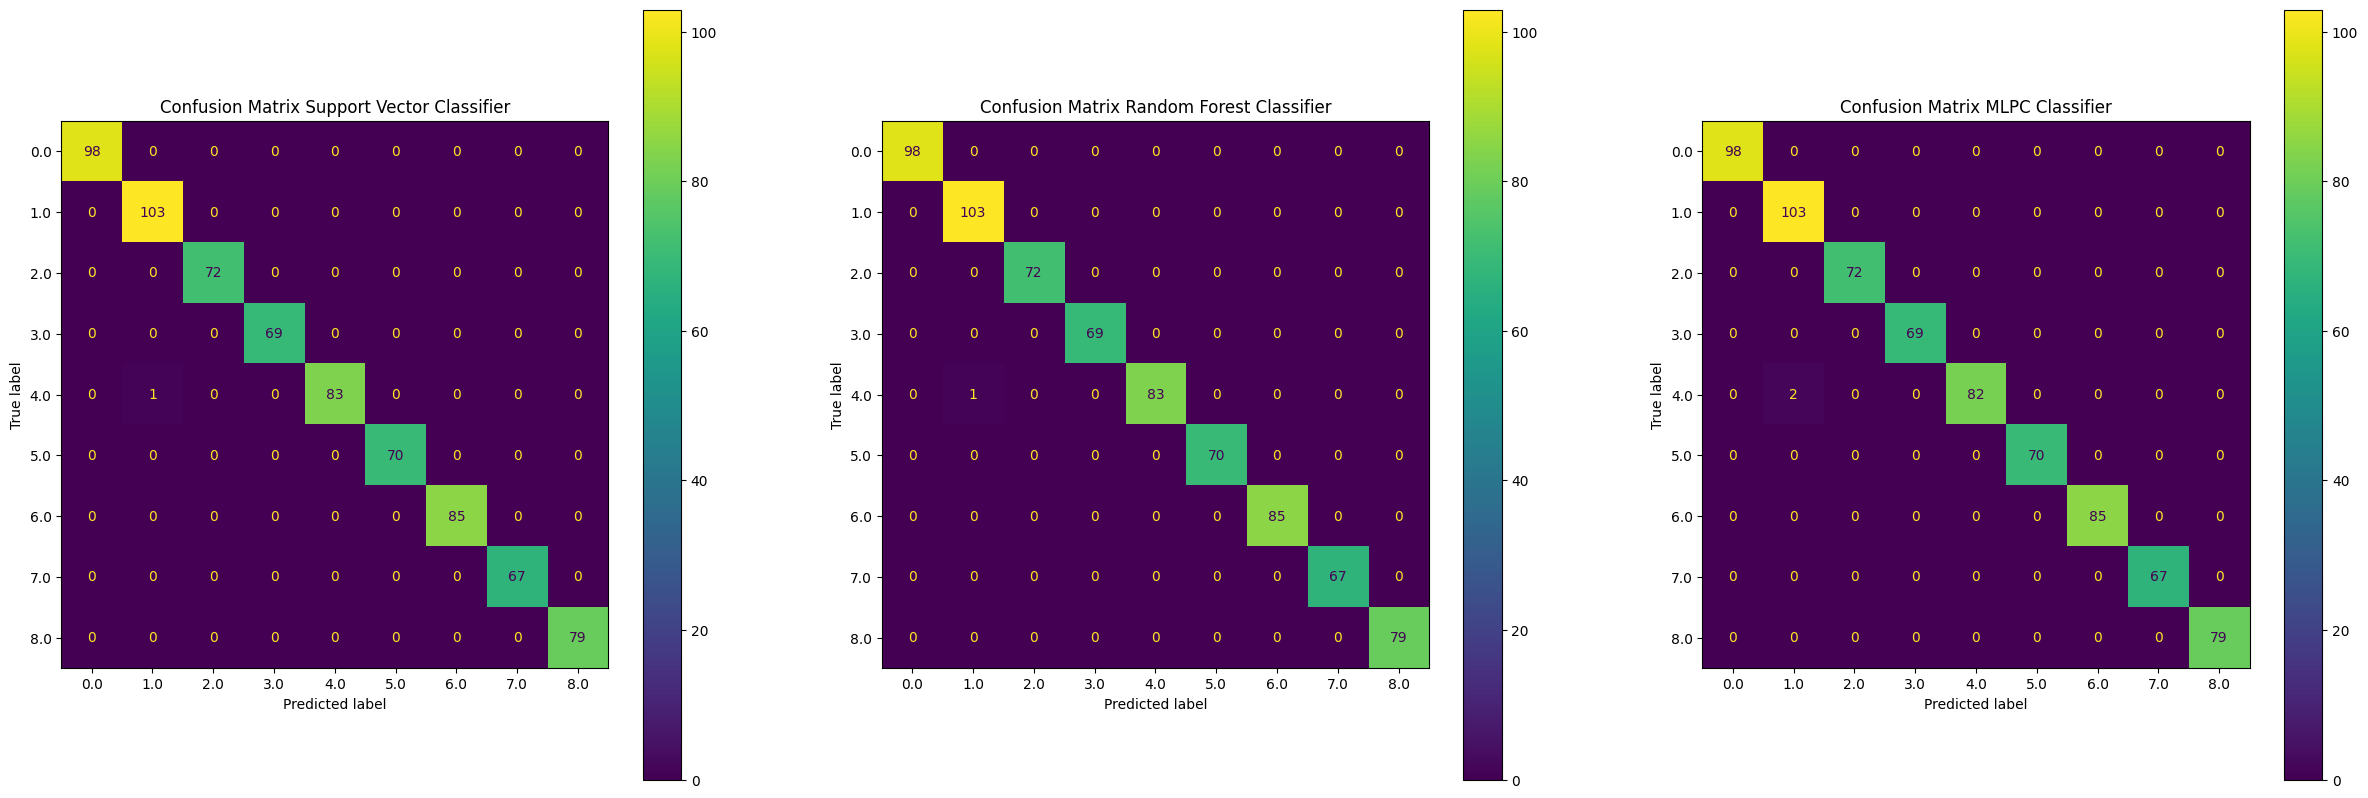

Accuracy SVC: 0.9972489683631361
Accuracy RandomForestClassifier: 0.9986244841815681
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      35.703636     10.712651         0.004497        0.000909   
1       6.176795      0.928451         0.004086        0.000164   
2       6.718686      1.366010         0.007501        0.004119   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.987952   
1                       10  {'hidden_layer_sizes': 10}           1.000000   
2                       15  {'hidden_layer_sizes': 15}           1.000000   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.987952           0.996558           0.981067           0.984483   
1           0.996558           1.000000           0.994836           0.996552   
2           0.996558           0.996558           0.994836           0.998276   

   mean_test

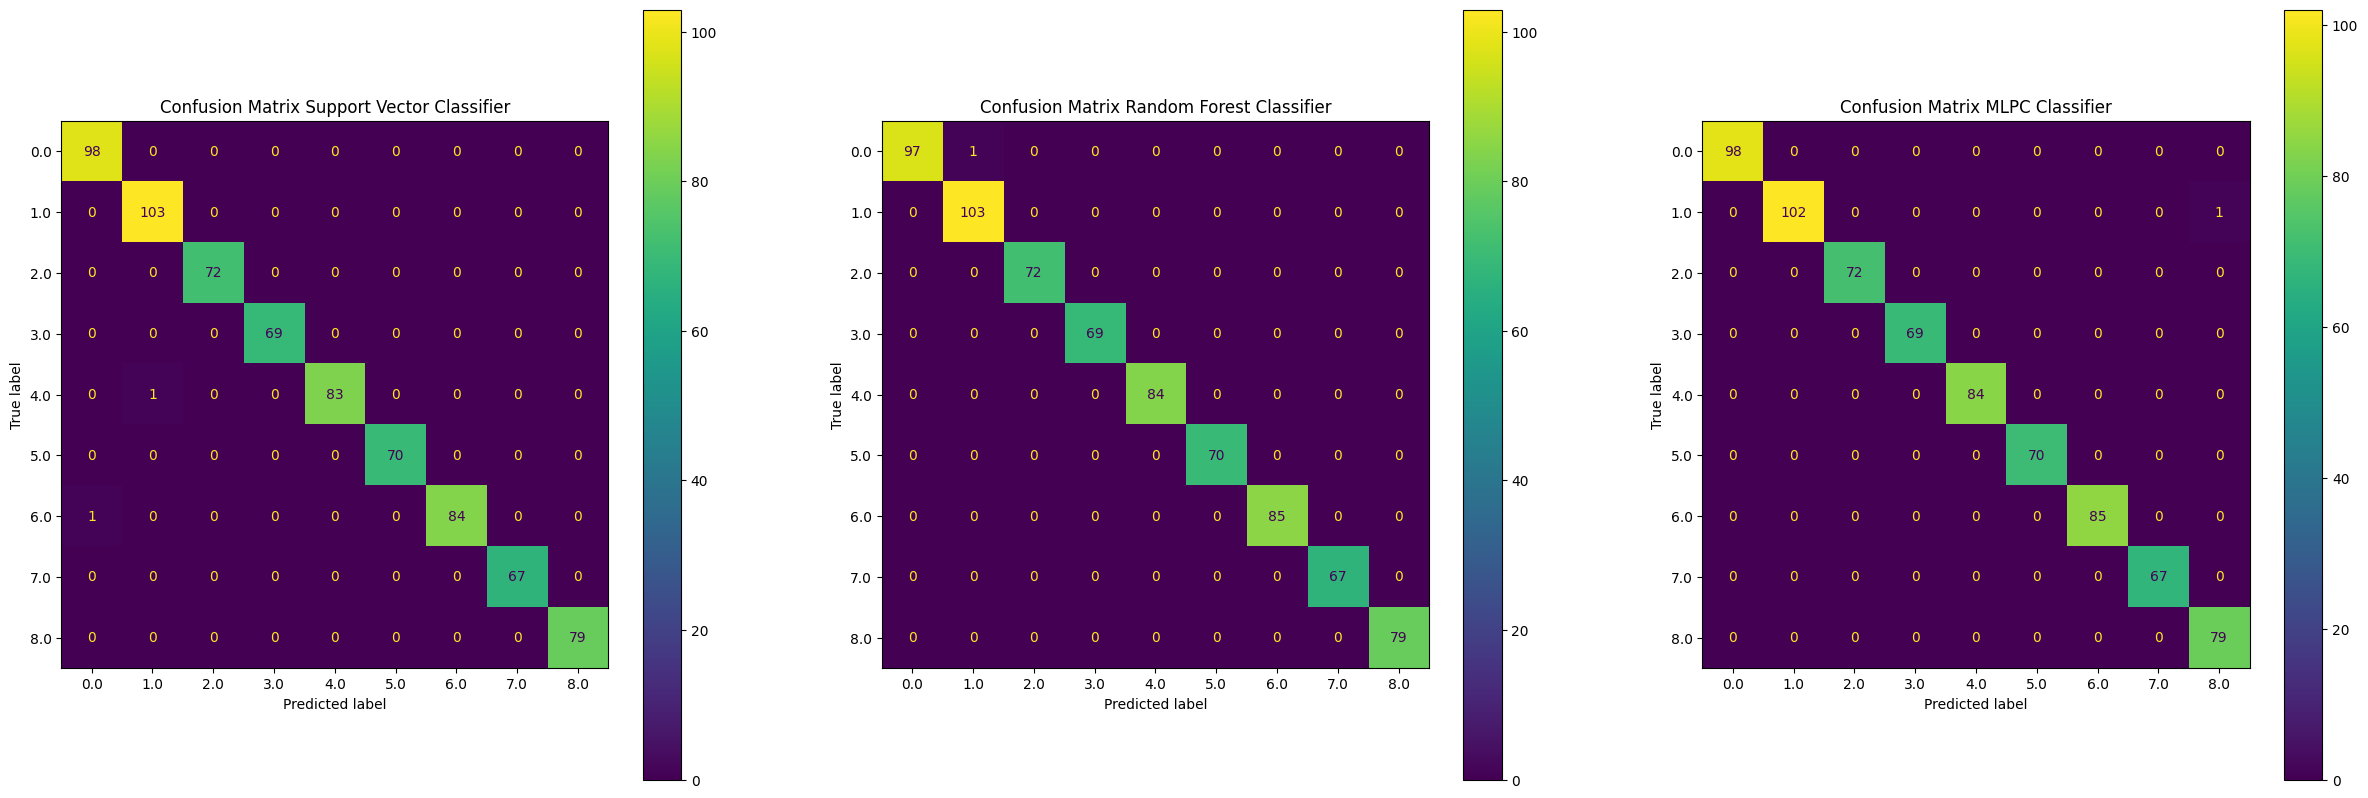

Accuracy SVC: 0.9986244841815681
Accuracy RandomForestClassifier: 0.9917469050894085
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       2.114325      0.253833         0.001830        0.000023   
1       2.000753      0.255871         0.001830        0.000067   
2       2.571262      0.564590         0.003826        0.002849   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.993115   
1                       10  {'hidden_layer_sizes': 10}           0.993115   
2                       15  {'hidden_layer_sizes': 15}           0.996558   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.991394           0.991394           0.994836           0.987931   
1           0.989673           0.986231           0.991394           0.987931   
2           0.994836           0.991394           0.998279           0.994828   

   mean_test

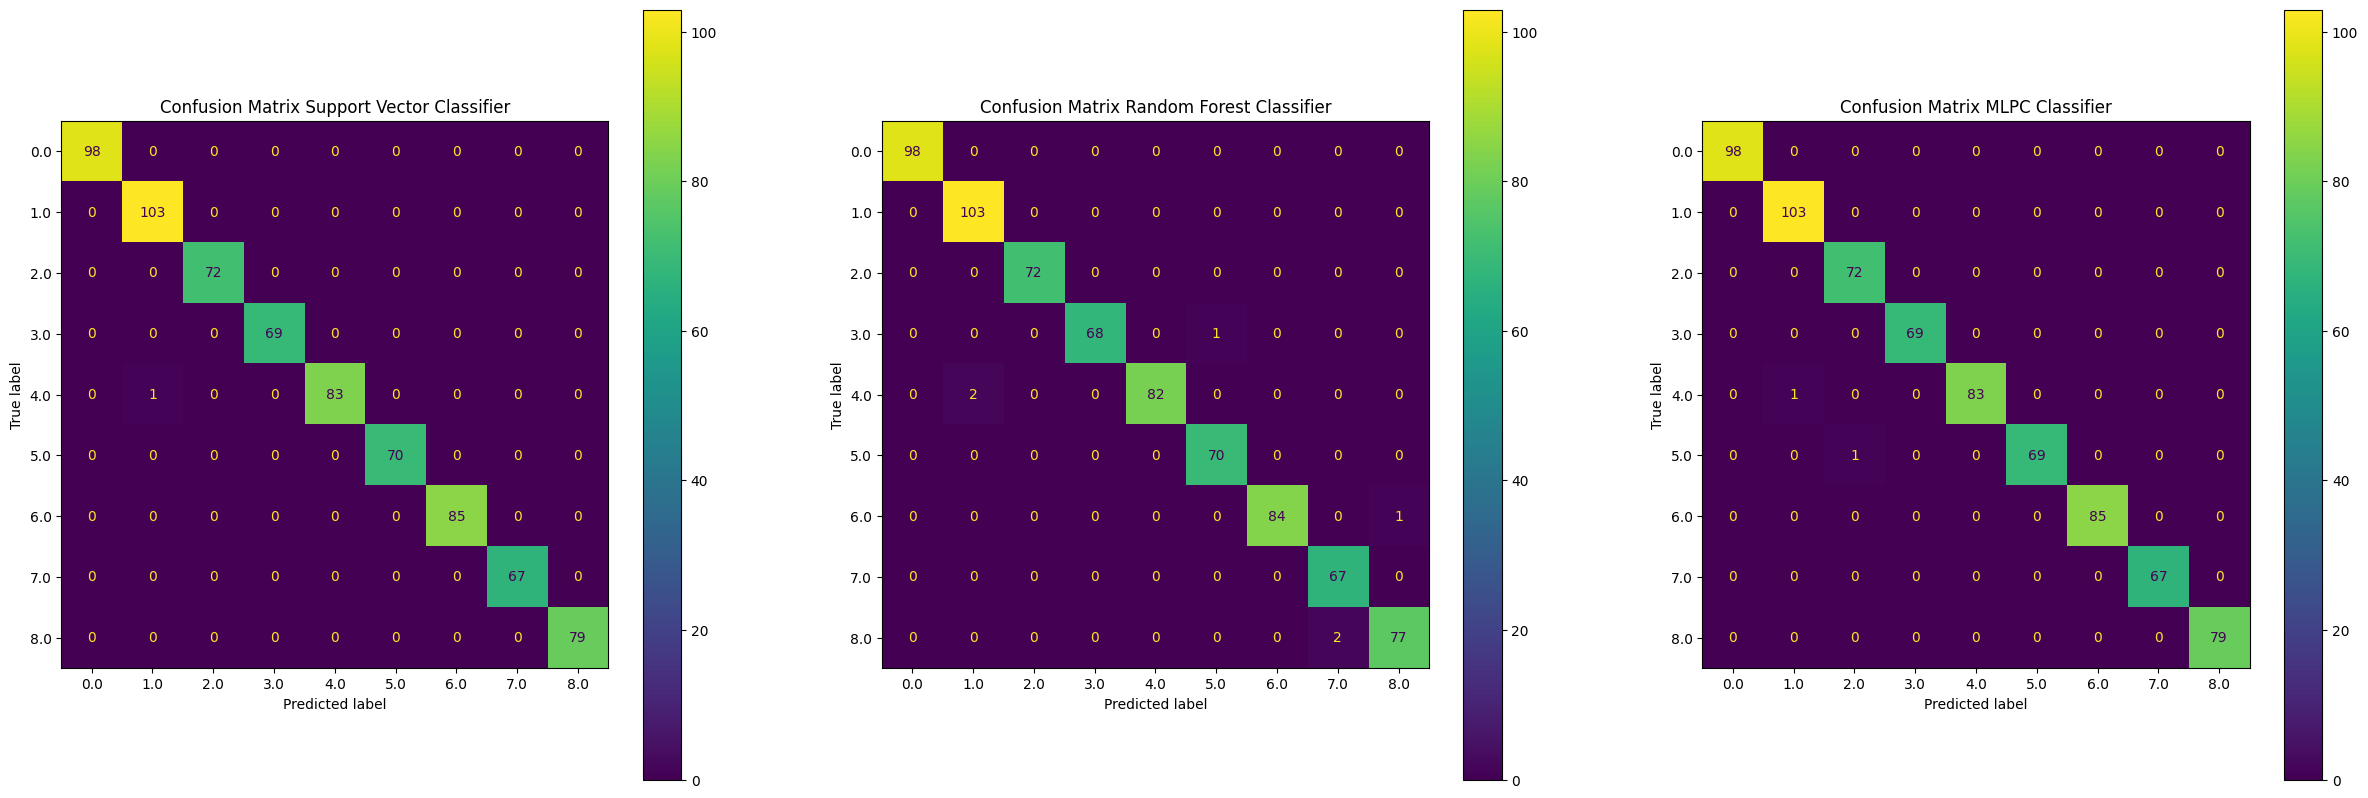

Accuracy SVC: 0.9986244841815681
Accuracy RandomForestClassifier: 0.9972489683631361
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.749126      0.757231         0.002181        0.000229   
1       1.544778      0.354287         0.002869        0.001483   
2       1.799821      0.524395         0.003059        0.002121   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.998279   
1                       10  {'hidden_layer_sizes': 10}           0.998279   
2                       15  {'hidden_layer_sizes': 15}           0.998279   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           1.000000           0.998279           0.996558           0.998276   
1           0.996558           0.998279           0.998279           0.998276   
2           0.996558           0.998279           0.989673           0.998276   

   mean_test

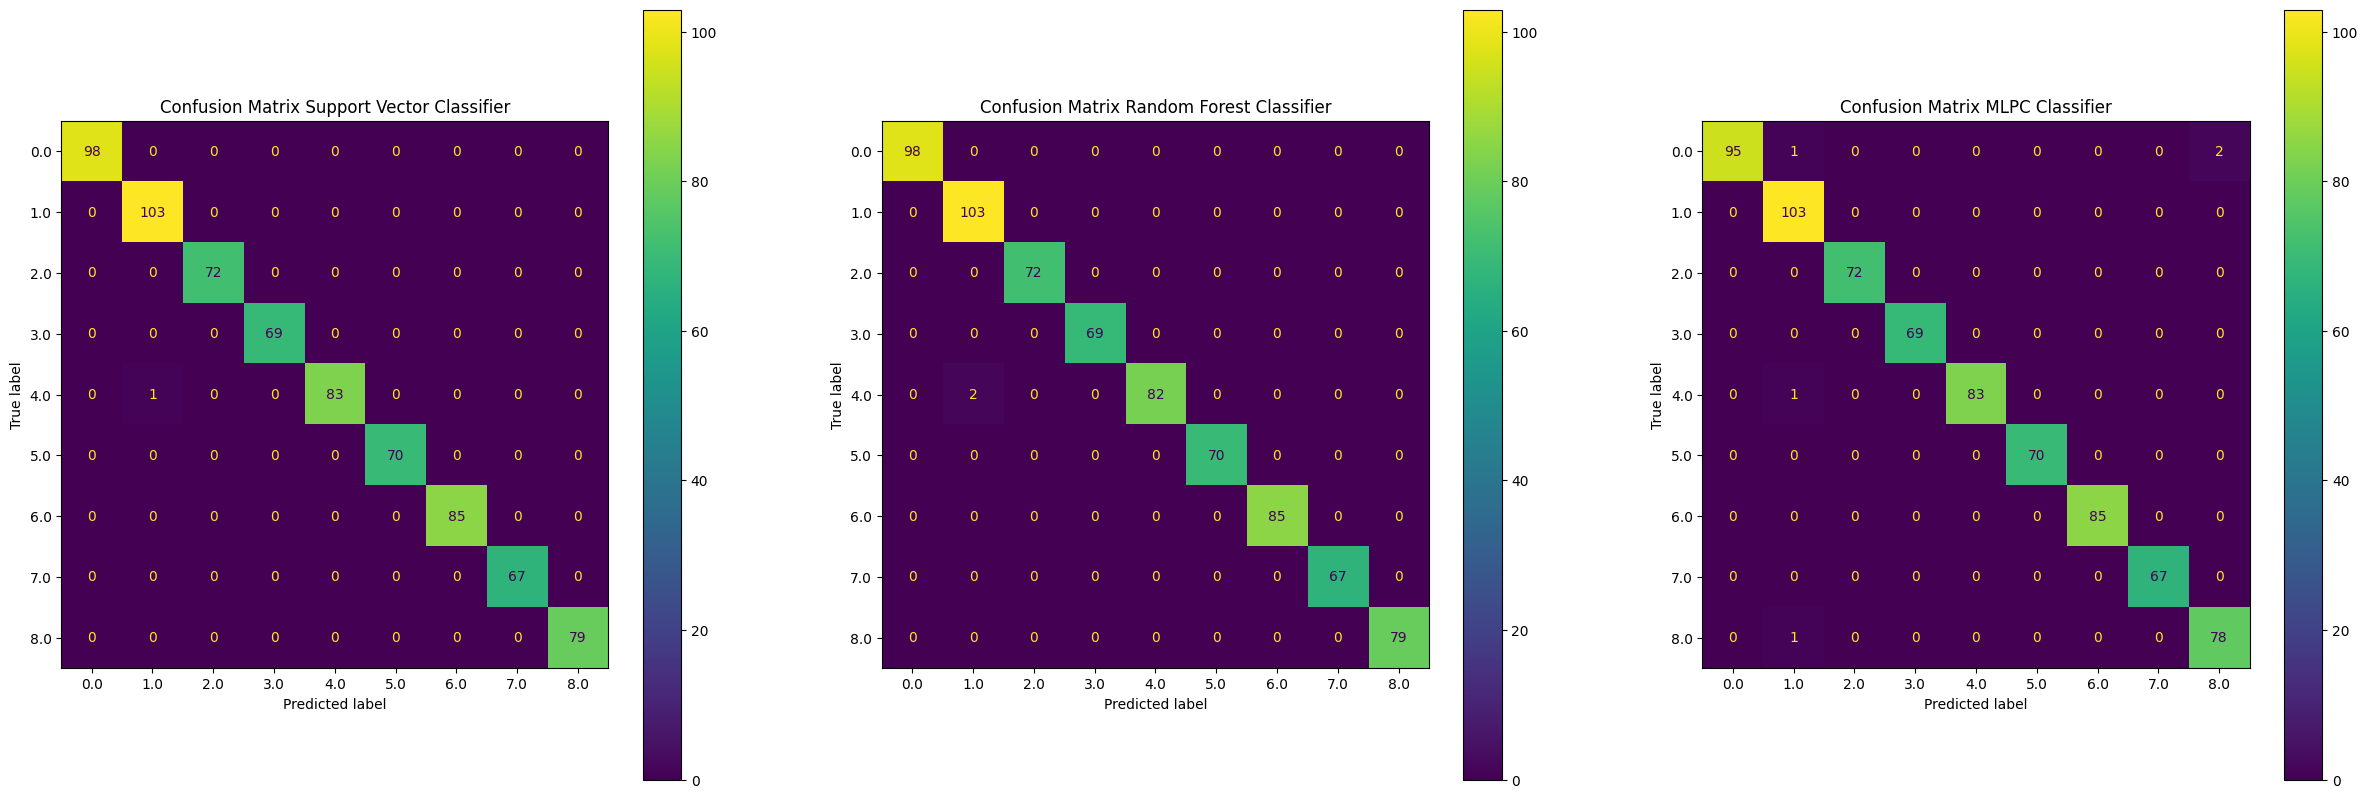

In [ ]:
train_person_classifier(lbp_scaled_data, cutting_points)
train_person_classifier(lbp_pca_all_data, cutting_points)
train_person_classifier(lbp_pca_vector_data, cutting_points)
train_person_classifier(lbp_pca_per_variable_data, cutting_points)

In [ ]:
lbp_svc_0, lbp_rfc_0, lbp_mlpc_0 = leave_one_out(lbp_scaled_data, speed_labels, person_labels)
lbp_svc_1, lbp_rfc_1, lbp_mlpc_1 = leave_one_out(lbp_pca_all_data, speed_labels, person_labels)
lbp_svc_2, lbp_rfc_2, lbp_mlpc_2 = leave_one_out(lbp_pca_vector_data, speed_labels, person_labels)
lbp_svc_3, lbp_rfc_3, lbp_mlpc_3 = leave_one_out(lbp_pca_per_variable_data, speed_labels, person_labels)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_kernel  \
0       3.369157      0.578873         0.537425        0.179602          rbf   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'kernel': 'rbf'}                1.0           0.997849                1.0   

   split3_test_score  split4_test_score  split5_test_score  split6_test_score  \
0            0.99446                1.0                1.0           0.977273   

   split7_test_score  split8_test_score  mean_test_score  std_test_score  \
0           0.997368                1.0         0.996328        0.006971   

   rank_test_score  
0                1  
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      15.161789      2.234893         0.029265        0.011204   
1      22.914049      1.908727         0.053826        0.026009   
2      11.169694      0.545964         0.029742        0.012210   
3      22.607136      2.790257         0.047534   

In [ ]:
lower_body, lb_positions= extract_scenario((["ANKLE_ANGLE", "KNEE_ANGLE", "HIP_ANGLE","MTP_POSITION","ANKLE_POSITION", "KNEE_POSITION", "HIP_POSITION"]), results, column_names)
lb_labels = np.take(angle_labels, lb_positions)
lb_scaled_data = normal_data(lower_body)
lb_pca_all_data, lb_pca_all = pca_all(lower_body)
lb_pca_vector_data,lb_pca_vector = pca_vector(lower_body)
lb_pca_per_variable_data, lb_pca_per_feature_names, lb_pca_per_components = pca_per_variable(lower_body, lb_labels)
#feature_names, result_components

(3631, 4200)
(3631, 4200)
(42, 3631, 100)
(3631, 210)
['_L_ANKLE_ANGLE_X_Component_0', '_L_ANKLE_ANGLE_X_Component_1', '_L_ANKLE_ANGLE_X_Component_2', '_L_ANKLE_ANGLE_X_Component_3', '_L_ANKLE_ANGLE_X_Component_4', '_L_ANKLE_ANGLE_Y_Component_0', '_L_ANKLE_ANGLE_Y_Component_1', '_L_ANKLE_ANGLE_Y_Component_2', '_L_ANKLE_ANGLE_Y_Component_3', '_L_ANKLE_ANGLE_Y_Component_4', '_L_ANKLE_ANGLE_Z_Component_0', '_L_ANKLE_ANGLE_Z_Component_1', '_L_ANKLE_ANGLE_Z_Component_2', '_L_ANKLE_ANGLE_Z_Component_3', '_L_ANKLE_ANGLE_Z_Component_4', '_R_ANKLE_ANGLE_X_Component_0', '_R_ANKLE_ANGLE_X_Component_1', '_R_ANKLE_ANGLE_X_Component_2', '_R_ANKLE_ANGLE_X_Component_3', '_R_ANKLE_ANGLE_X_Component_4', '_R_ANKLE_ANGLE_Y_Component_0', '_R_ANKLE_ANGLE_Y_Component_1', '_R_ANKLE_ANGLE_Y_Component_2', '_R_ANKLE_ANGLE_Y_Component_3', '_R_ANKLE_ANGLE_Y_Component_4', '_R_ANKLE_ANGLE_Z_Component_0', '_R_ANKLE_ANGLE_Z_Component_1', '_R_ANKLE_ANGLE_Z_Component_2', '_R_ANKLE_ANGLE_Z_Component_3', '_R_ANKLE_ANGLE_Z

Accuracy SVC: 0.9986244841815681
Accuracy RandomForestClassifier: 0.9986244841815681
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      77.266788      1.350573         0.014587        0.001632   
1      11.754375      1.065284         0.019836        0.005433   
2       9.929319      1.574099         0.016993        0.006183   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           1.000000   
1                       10  {'hidden_layer_sizes': 10}           1.000000   
2                       15  {'hidden_layer_sizes': 15}           0.998279   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.996558           0.998279           0.998279                1.0   
1           0.996558           0.998279           1.000000                1.0   
2           0.996558           1.000000           1.000000                1.0   

   mean_test

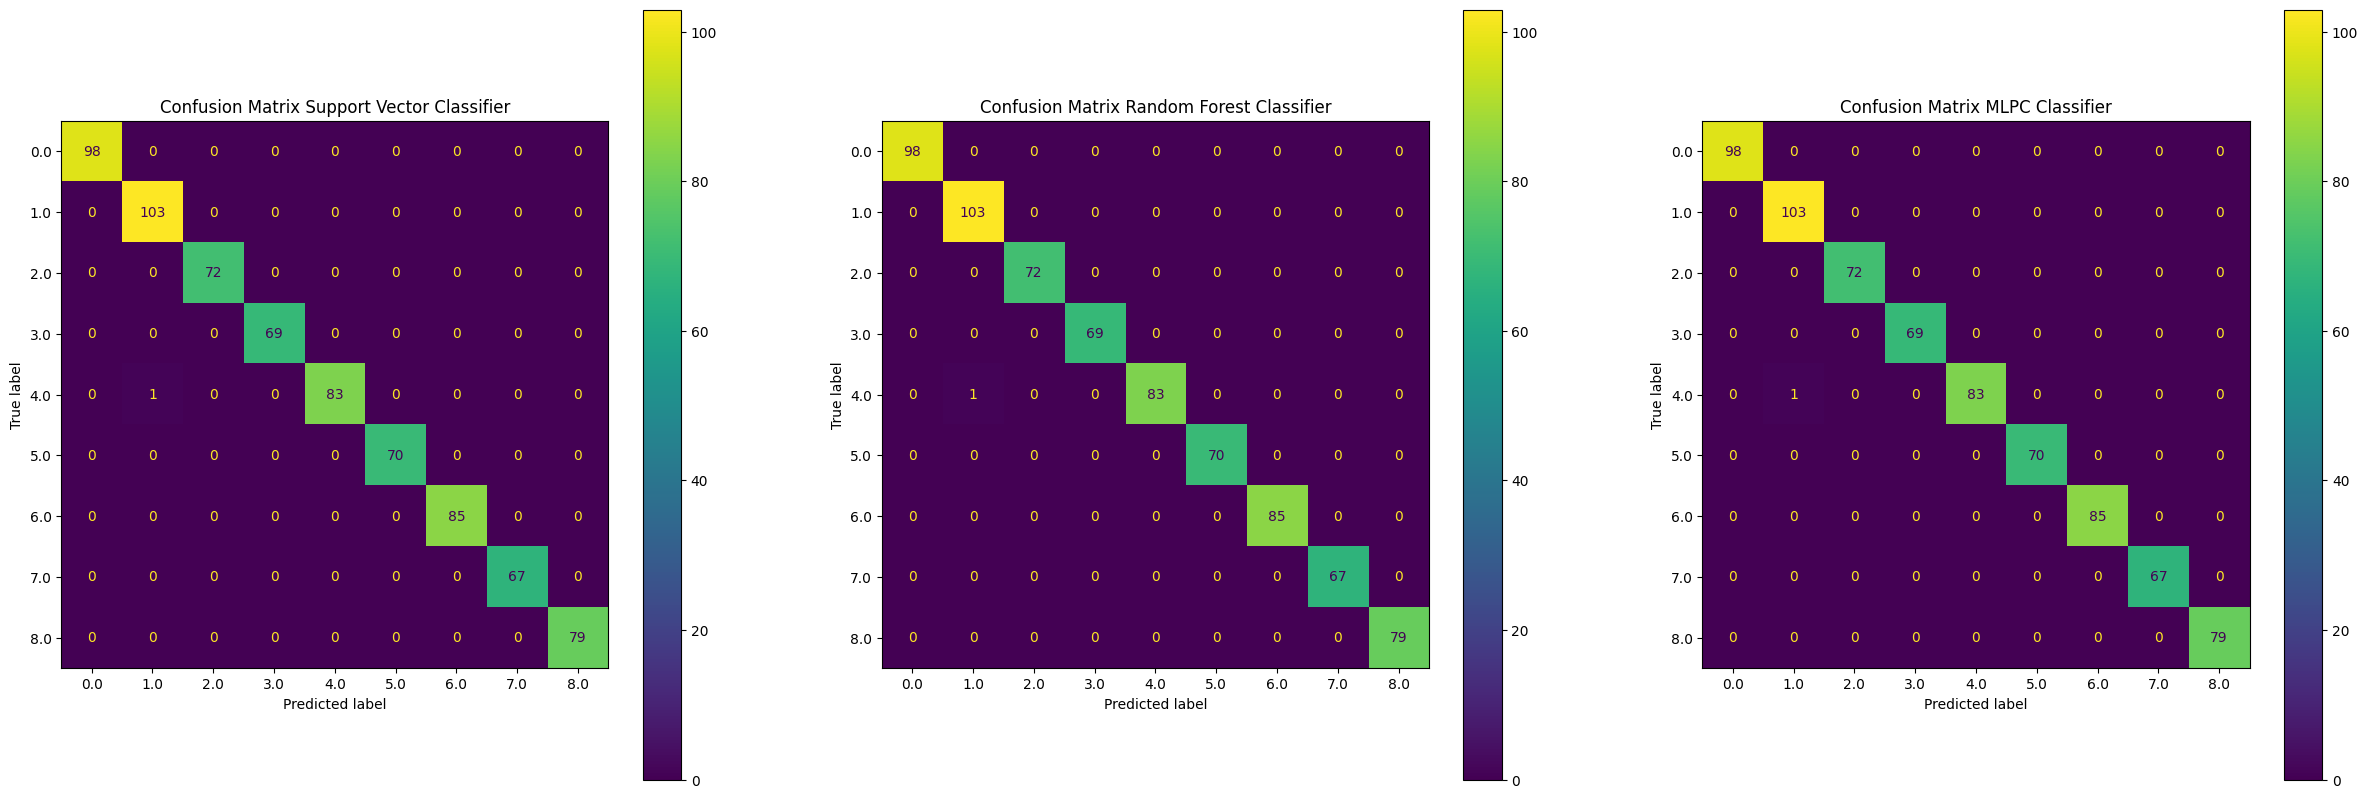

Accuracy SVC: 0.9986244841815681
Accuracy RandomForestClassifier: 0.9986244841815681
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      15.835259      5.091691         0.006399        0.002672   
1       4.595750      1.057399         0.005313        0.000382   
2       5.741875      0.967594         0.007943        0.003734   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.994836   
1                       10  {'hidden_layer_sizes': 10}           0.998279   
2                       15  {'hidden_layer_sizes': 15}           0.996558   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.994836           0.993115           0.998279           0.994828   
1           0.996558           0.998279           1.000000           0.996552   
2           0.998279           0.996558           1.000000           0.998276   

   mean_test

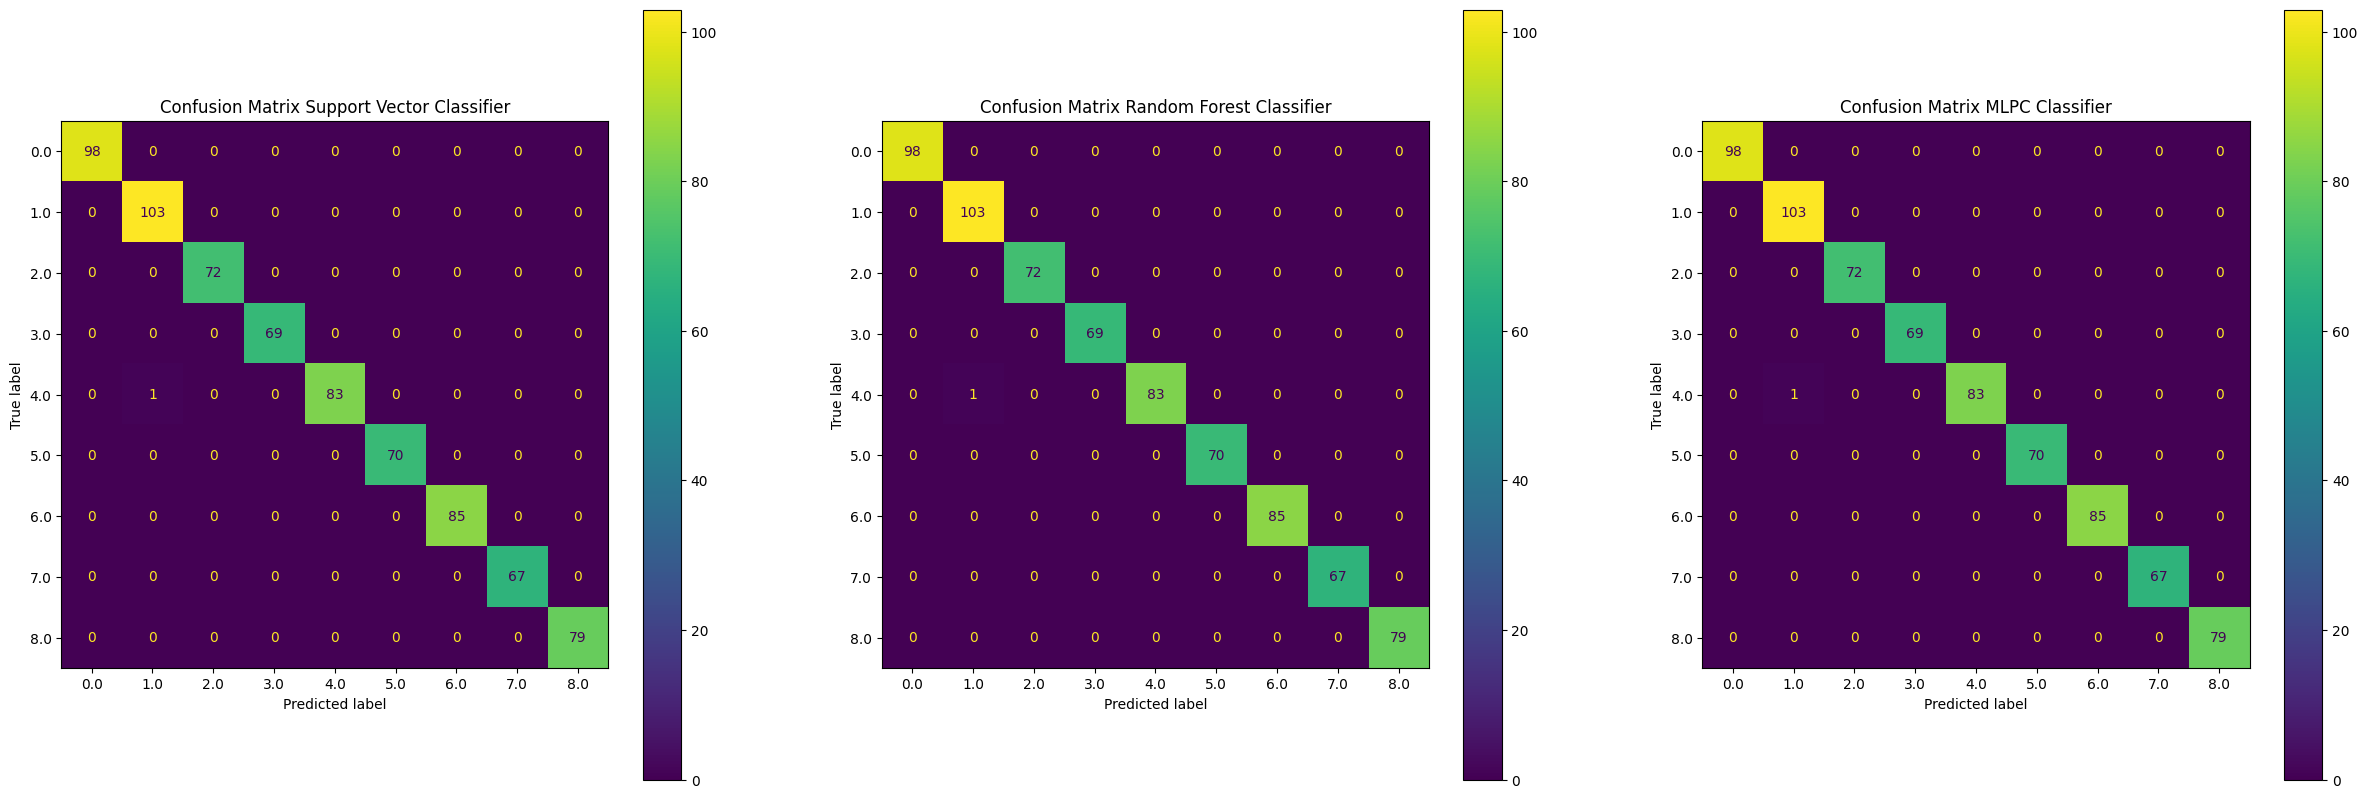

Accuracy SVC: 0.9986244841815681
Accuracy RandomForestClassifier: 0.9986244841815681
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.138710      0.061169         0.001947        0.000069   
1       1.051663      0.361824         0.005500        0.004040   
2       0.922818      0.159588         0.002048        0.000304   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.994836   
1                       10  {'hidden_layer_sizes': 10}           0.993115   
2                       15  {'hidden_layer_sizes': 15}           0.993115   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.994836           0.994836           0.998279           1.000000   
1           0.994836           0.996558           0.994836           0.998276   
2           0.998279           0.998279           0.998279           0.998276   

   mean_test

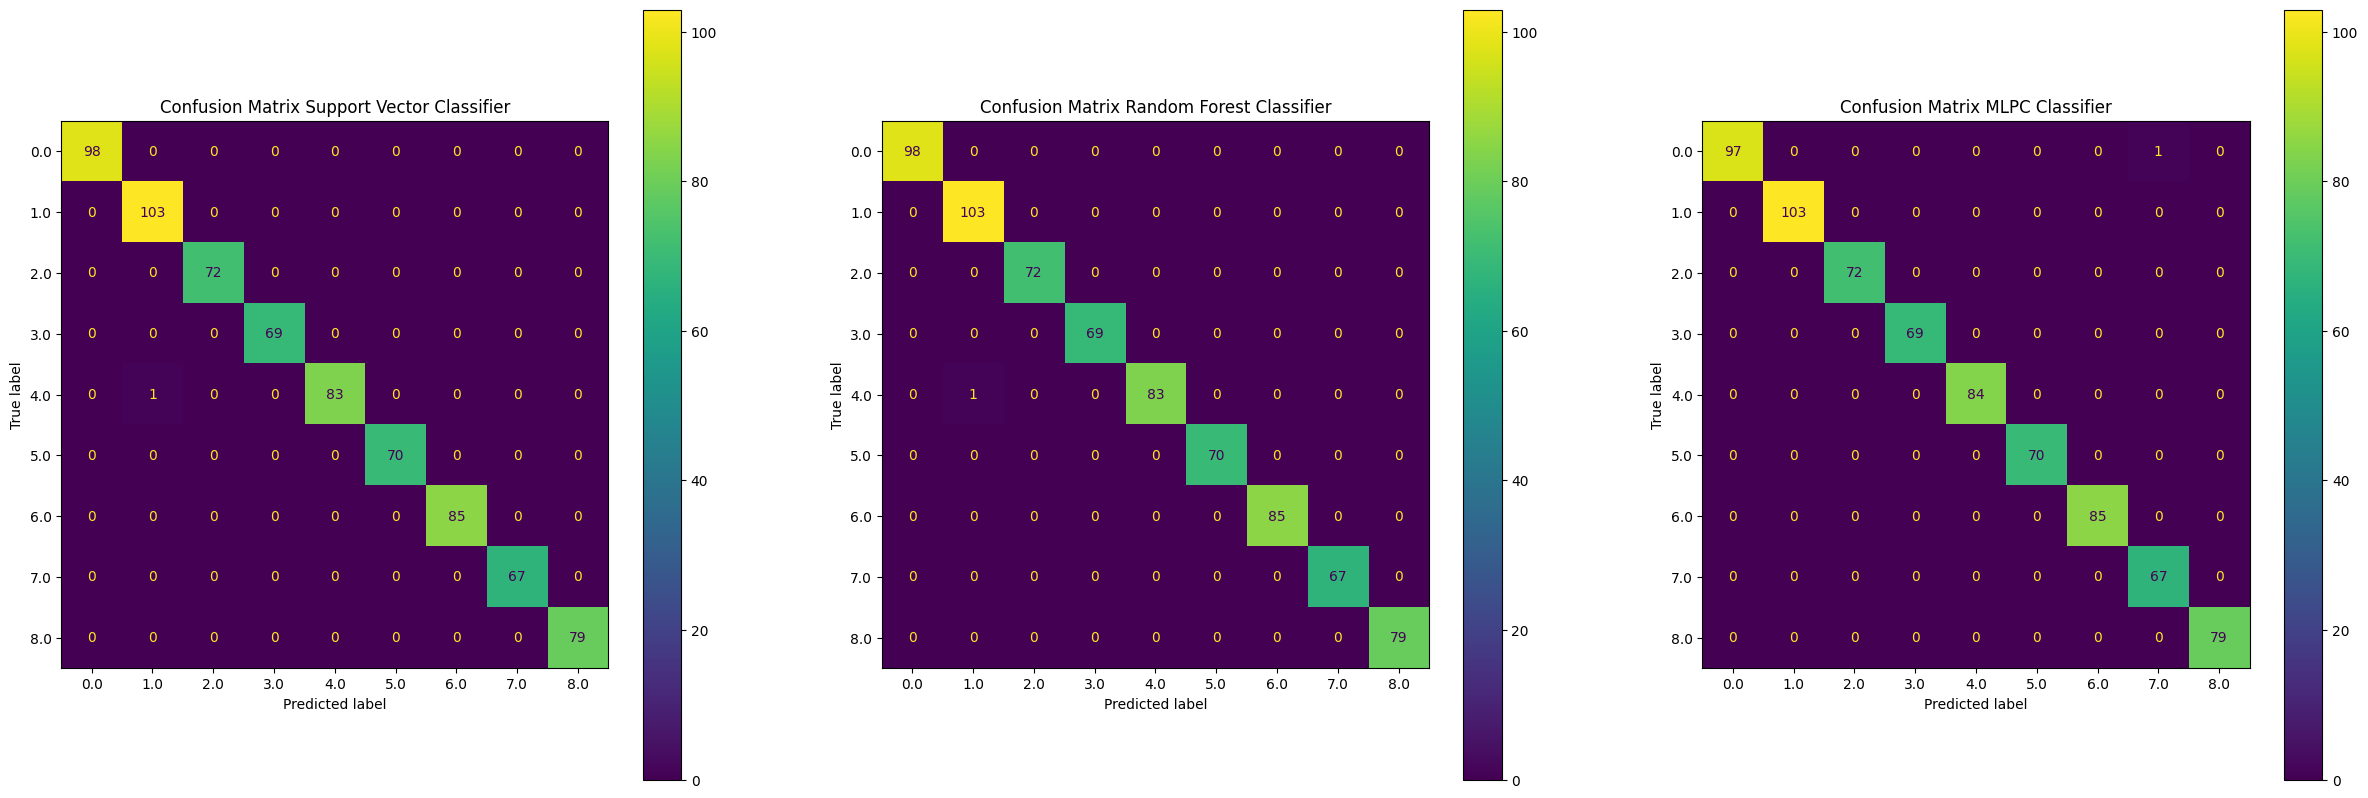

Accuracy SVC: 0.9986244841815681
Accuracy RandomForestClassifier: 0.9986244841815681
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       6.023243      2.360896         0.003913        0.002721   
1       0.910067      0.033911         0.002541        0.000061   
2       1.021814      0.111303         0.002750        0.000450   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.919105   
1                       10  {'hidden_layer_sizes': 10}           0.996558   
2                       15  {'hidden_layer_sizes': 15}           0.994836   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.929432           1.000000                1.0           1.000000   
1           0.998279           1.000000                1.0           1.000000   
2           1.000000           0.998279                1.0           0.996552   

   mean_test

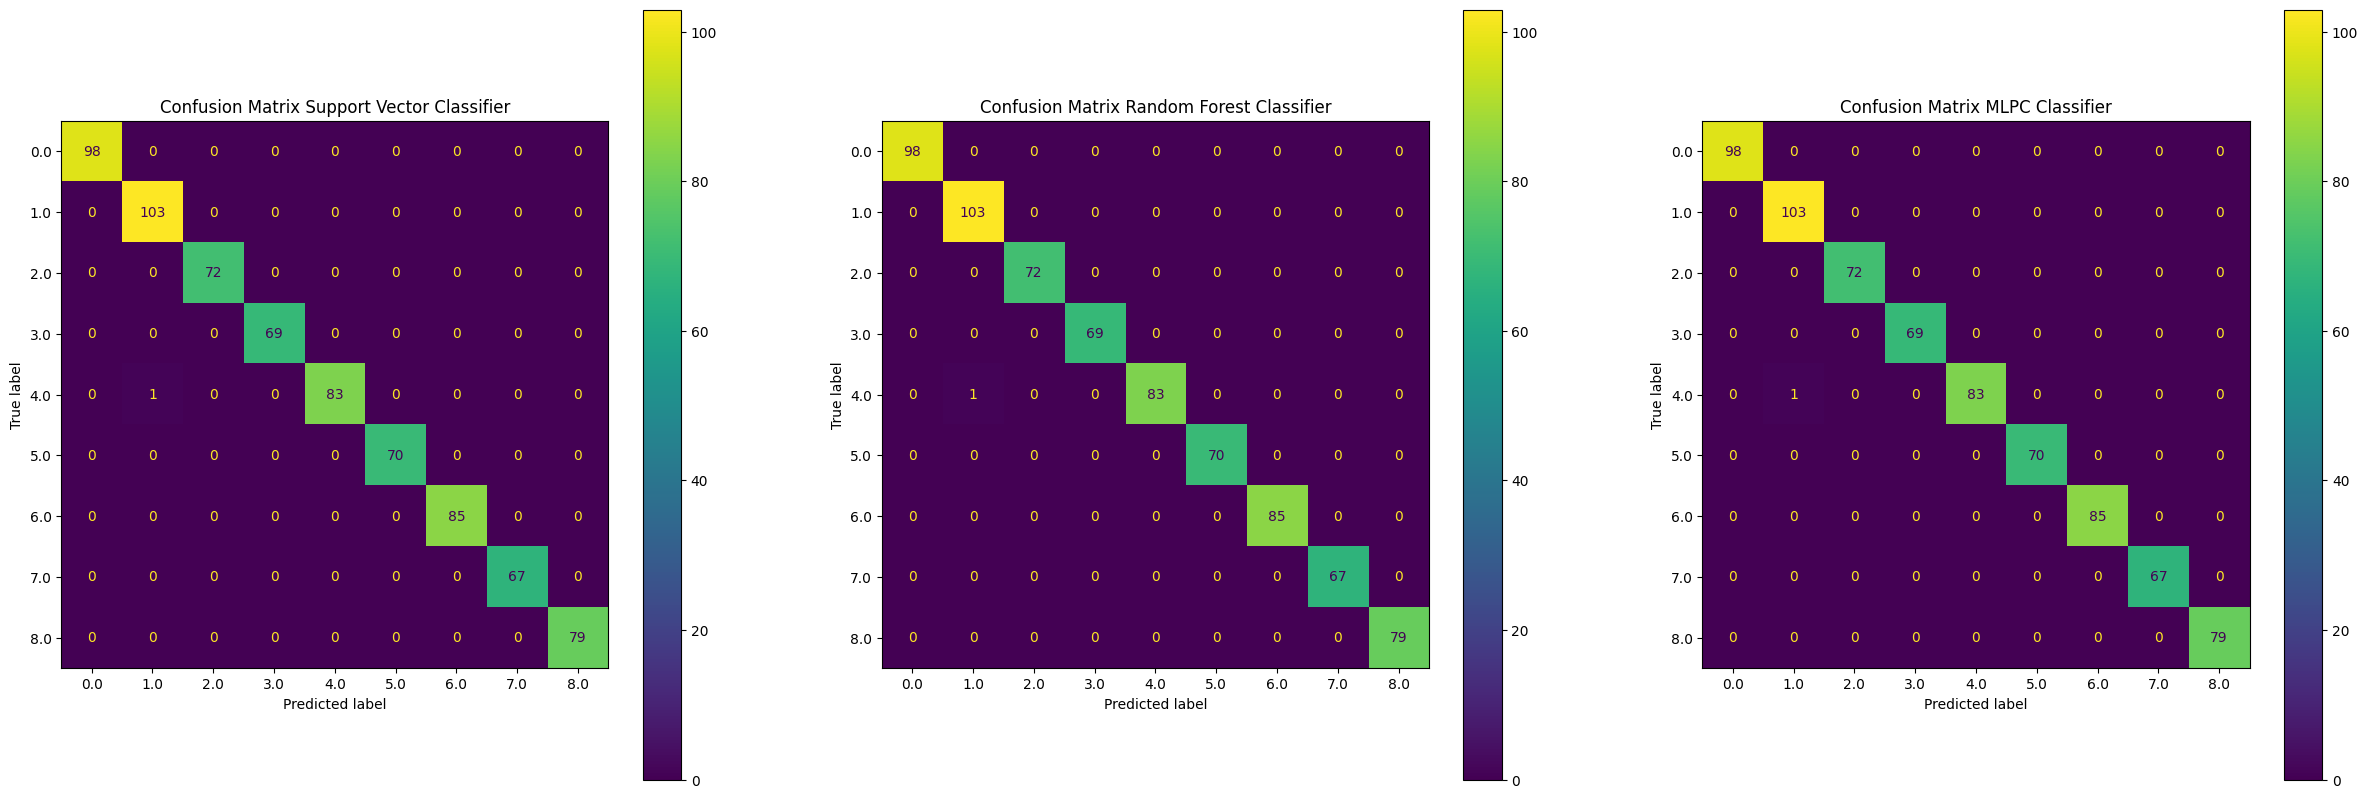

In [ ]:
train_person_classifier(lb_scaled_data, cutting_points)
train_person_classifier(lb_pca_all_data, cutting_points)
train_person_classifier(lb_pca_vector_data, cutting_points)
train_person_classifier(lb_pca_per_variable_data, cutting_points)

In [ ]:
lb_svc_0, lb_rfc_0, lb_mlpc_0 = leave_one_out(lb_scaled_data, speed_labels, person_labels)
lb_svc_1, lb_rfc_1, lb_mlpc_1 = leave_one_out(lb_pca_all_data, speed_labels, person_labels)
lb_svc_2, lb_rfc_2, lb_mlpc_2 = leave_one_out(lb_pca_vector_data, speed_labels, person_labels)
lb_svc_3, lb_rfc_3, lb_mlpc_3 = leave_one_out(lb_pca_per_variable_data, speed_labels, person_labels)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_kernel  \
0       8.218258      1.698388         1.413514        0.424766          rbf   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'kernel': 'rbf'}                1.0           0.997849                1.0   

   split3_test_score  split4_test_score  split5_test_score  split6_test_score  \
0                1.0                1.0           0.997319           0.979798   

   split7_test_score  split8_test_score  mean_test_score  std_test_score  \
0           0.997368                1.0         0.996926        0.006163   

   rank_test_score  
0                1  
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      15.480010      0.413330         0.022348        0.001645   
1      30.021977      1.366993         0.050455        0.017531   
2      15.773099      0.375890         0.021962        0.001863   
3      29.294867      3.441410         0.044047   

In [ ]:
upper_body_angles, uba_positions= extract_scenario((["SHOULDER_ANGLE", "ELBOW_ANGLE", "TORSO_ANGLE_wrt_PELVIS"]), results, column_names)
uba_labels = np.take(angle_labels, uba_positions)
uba_scaled_data = normal_data(upper_body_angles)
uba_pca_all_data, uba_pca_all = pca_all(upper_body_angles)
uba_pca_vector_data,uba_pca_vector = pca_vector(upper_body_angles)
uba_pca_per_variable_data, uba_pca_per_feature_names, uba_pca_per_components = pca_per_variable(upper_body_angles, uba_labels)
#feature_names, result_components

(3631, 1500)
(3631, 1500)
(15, 3631, 100)
(3631, 135)
['_L_SHOULDER_ANGLE_X_Component_0', '_L_SHOULDER_ANGLE_X_Component_1', '_L_SHOULDER_ANGLE_X_Component_2', '_L_SHOULDER_ANGLE_X_Component_3', '_L_SHOULDER_ANGLE_X_Component_4', '_L_SHOULDER_ANGLE_X_Component_5', '_L_SHOULDER_ANGLE_X_Component_6', '_L_SHOULDER_ANGLE_X_Component_7', '_L_SHOULDER_ANGLE_X_Component_8', '_L_SHOULDER_ANGLE_Y_Component_0', '_L_SHOULDER_ANGLE_Y_Component_1', '_L_SHOULDER_ANGLE_Y_Component_2', '_L_SHOULDER_ANGLE_Y_Component_3', '_L_SHOULDER_ANGLE_Y_Component_4', '_L_SHOULDER_ANGLE_Y_Component_5', '_L_SHOULDER_ANGLE_Y_Component_6', '_L_SHOULDER_ANGLE_Y_Component_7', '_L_SHOULDER_ANGLE_Y_Component_8', '_L_SHOULDER_ANGLE_Z_Component_0', '_L_SHOULDER_ANGLE_Z_Component_1', '_L_SHOULDER_ANGLE_Z_Component_2', '_L_SHOULDER_ANGLE_Z_Component_3', '_L_SHOULDER_ANGLE_Z_Component_4', '_L_SHOULDER_ANGLE_Z_Component_5', '_L_SHOULDER_ANGLE_Z_Component_6', '_L_SHOULDER_ANGLE_Z_Component_7', '_L_SHOULDER_ANGLE_Z_Component_8', 

Accuracy SVC: 0.9931224209078404
Accuracy RandomForestClassifier: 0.9986244841815681
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      25.133098      1.213967         0.006817        0.001666   
1       6.723261      1.742808         0.007682        0.002455   
2       6.708333      1.010910         0.007107        0.000835   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.994836   
1                       10  {'hidden_layer_sizes': 10}           0.998279   
2                       15  {'hidden_layer_sizes': 15}           0.996558   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.996558           0.998279           0.987952           0.996552   
1           1.000000           0.994836           0.993115           0.996552   
2           1.000000           0.996558           0.991394           0.996552   

   mean_test

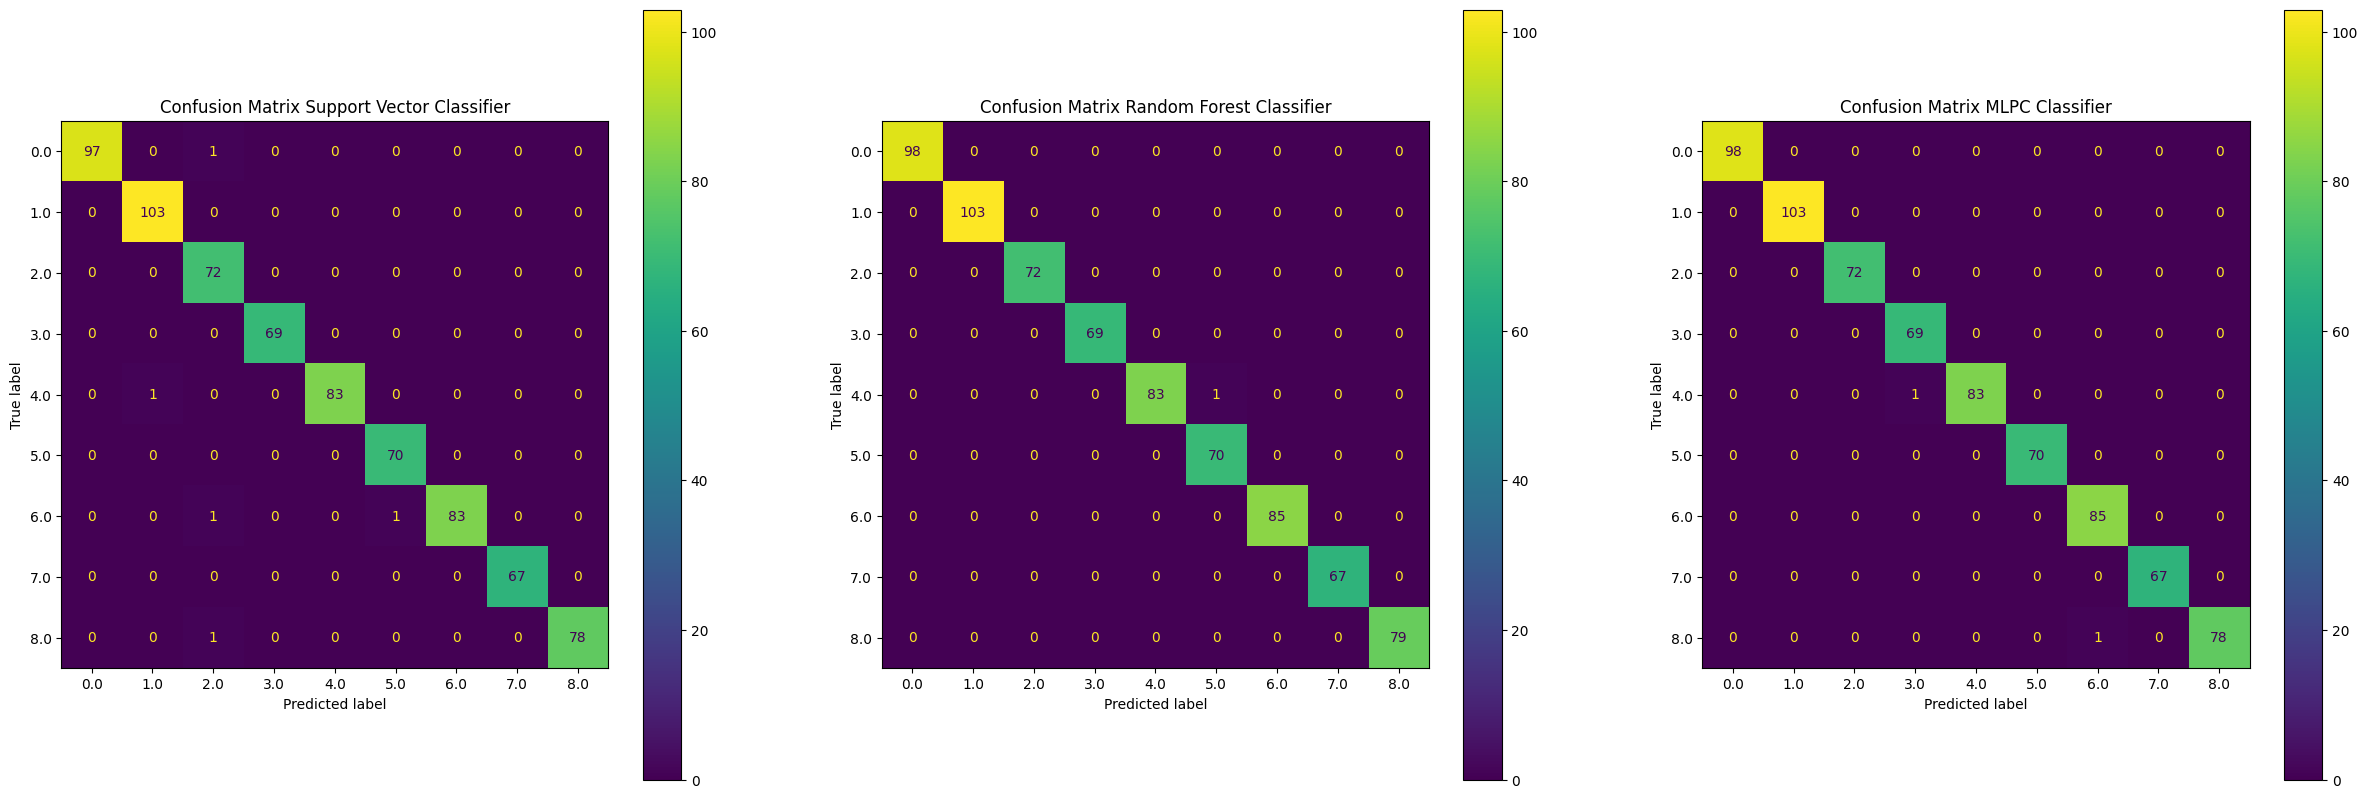

Accuracy SVC: 0.9944979367262724
Accuracy RandomForestClassifier: 0.9972489683631361
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      18.201449      1.286542         0.005898        0.002773   
1       5.215345      0.915816         0.006192        0.002838   
2       5.082531      0.848980         0.007218        0.003150   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.989673   
1                       10  {'hidden_layer_sizes': 10}           0.994836   
2                       15  {'hidden_layer_sizes': 15}           0.996558   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.989673           0.991394           0.993115           0.991379   
1           0.994836           0.996558           1.000000           0.996552   
2           0.998279           0.994836           0.998279           0.994828   

   mean_test

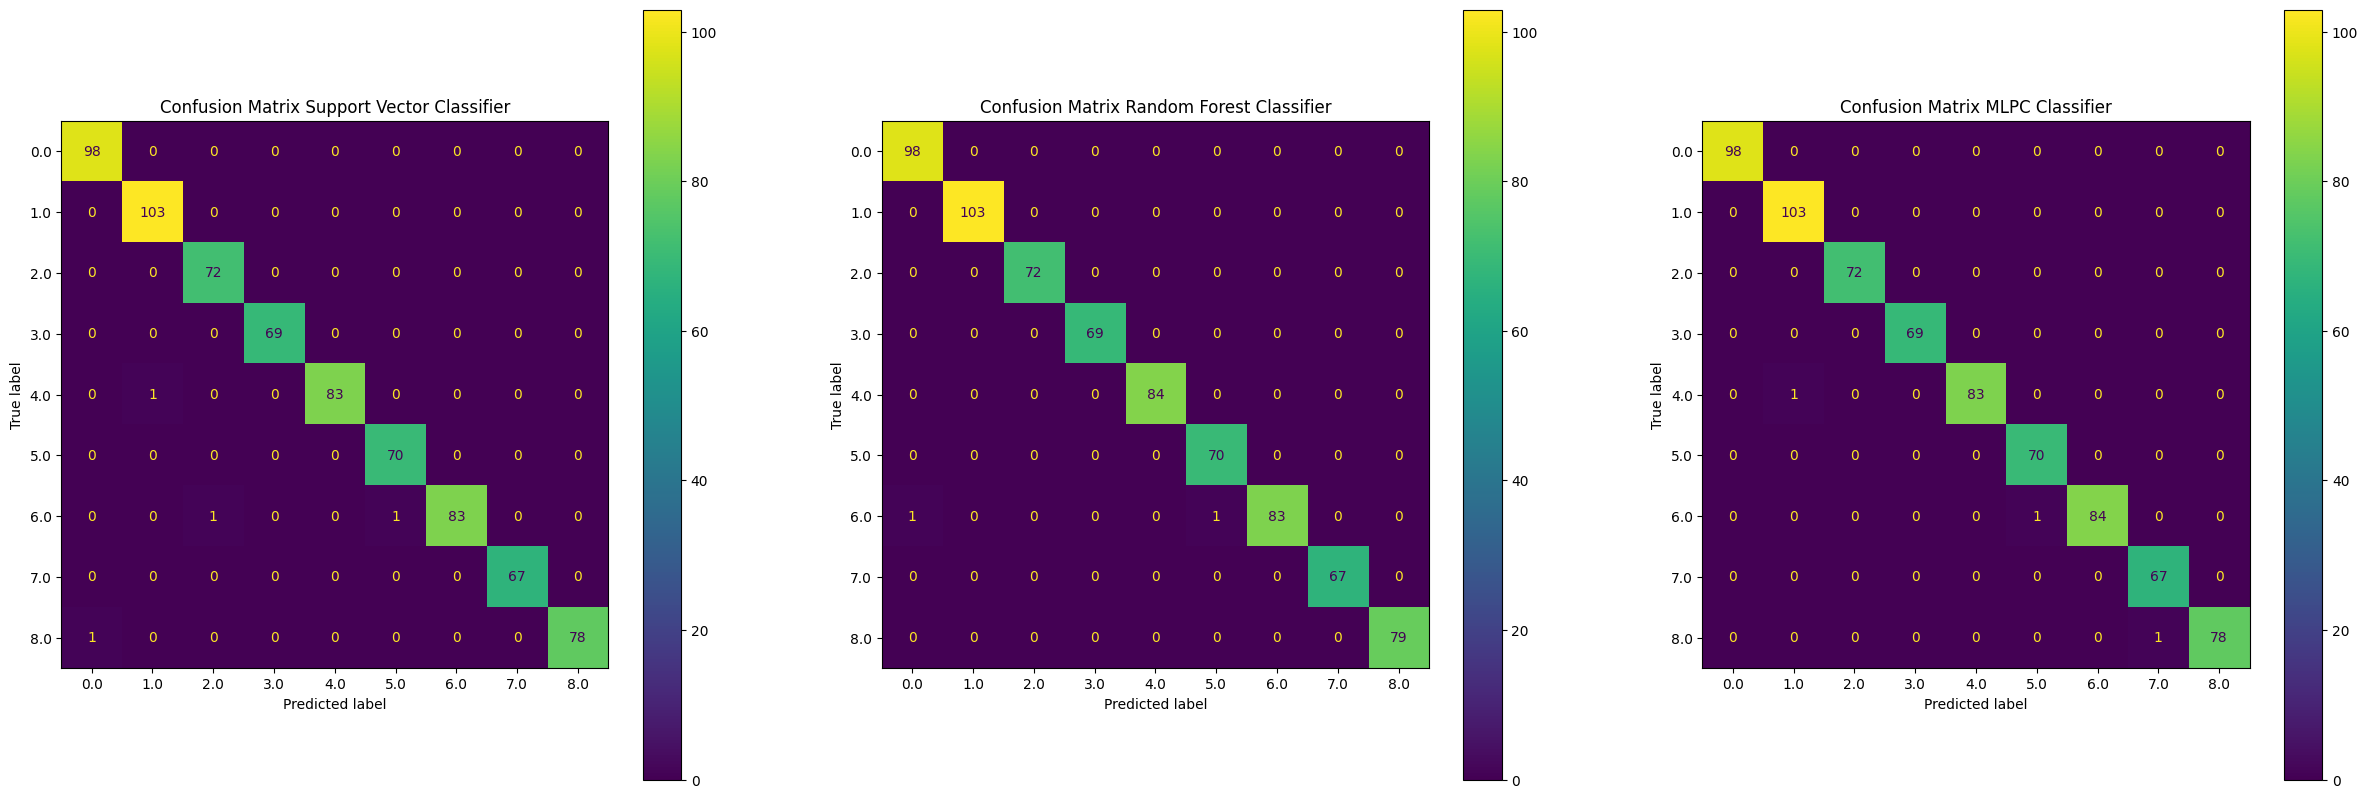

Accuracy SVC: 0.9944979367262724
Accuracy RandomForestClassifier: 0.9958734525447043
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       3.446635      0.650496         0.002221        0.000089   
1       1.557838      0.425710         0.003294        0.002230   
2       1.240496      0.029000         0.002024        0.000284   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.993115   
1                       10  {'hidden_layer_sizes': 10}           0.989673   
2                       15  {'hidden_layer_sizes': 15}           0.996558   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.991394           0.993115           0.996558           0.993103   
1           0.996558           0.996558           0.998279           0.994828   
2           0.993115           0.996558           0.996558           0.993103   

   mean_test

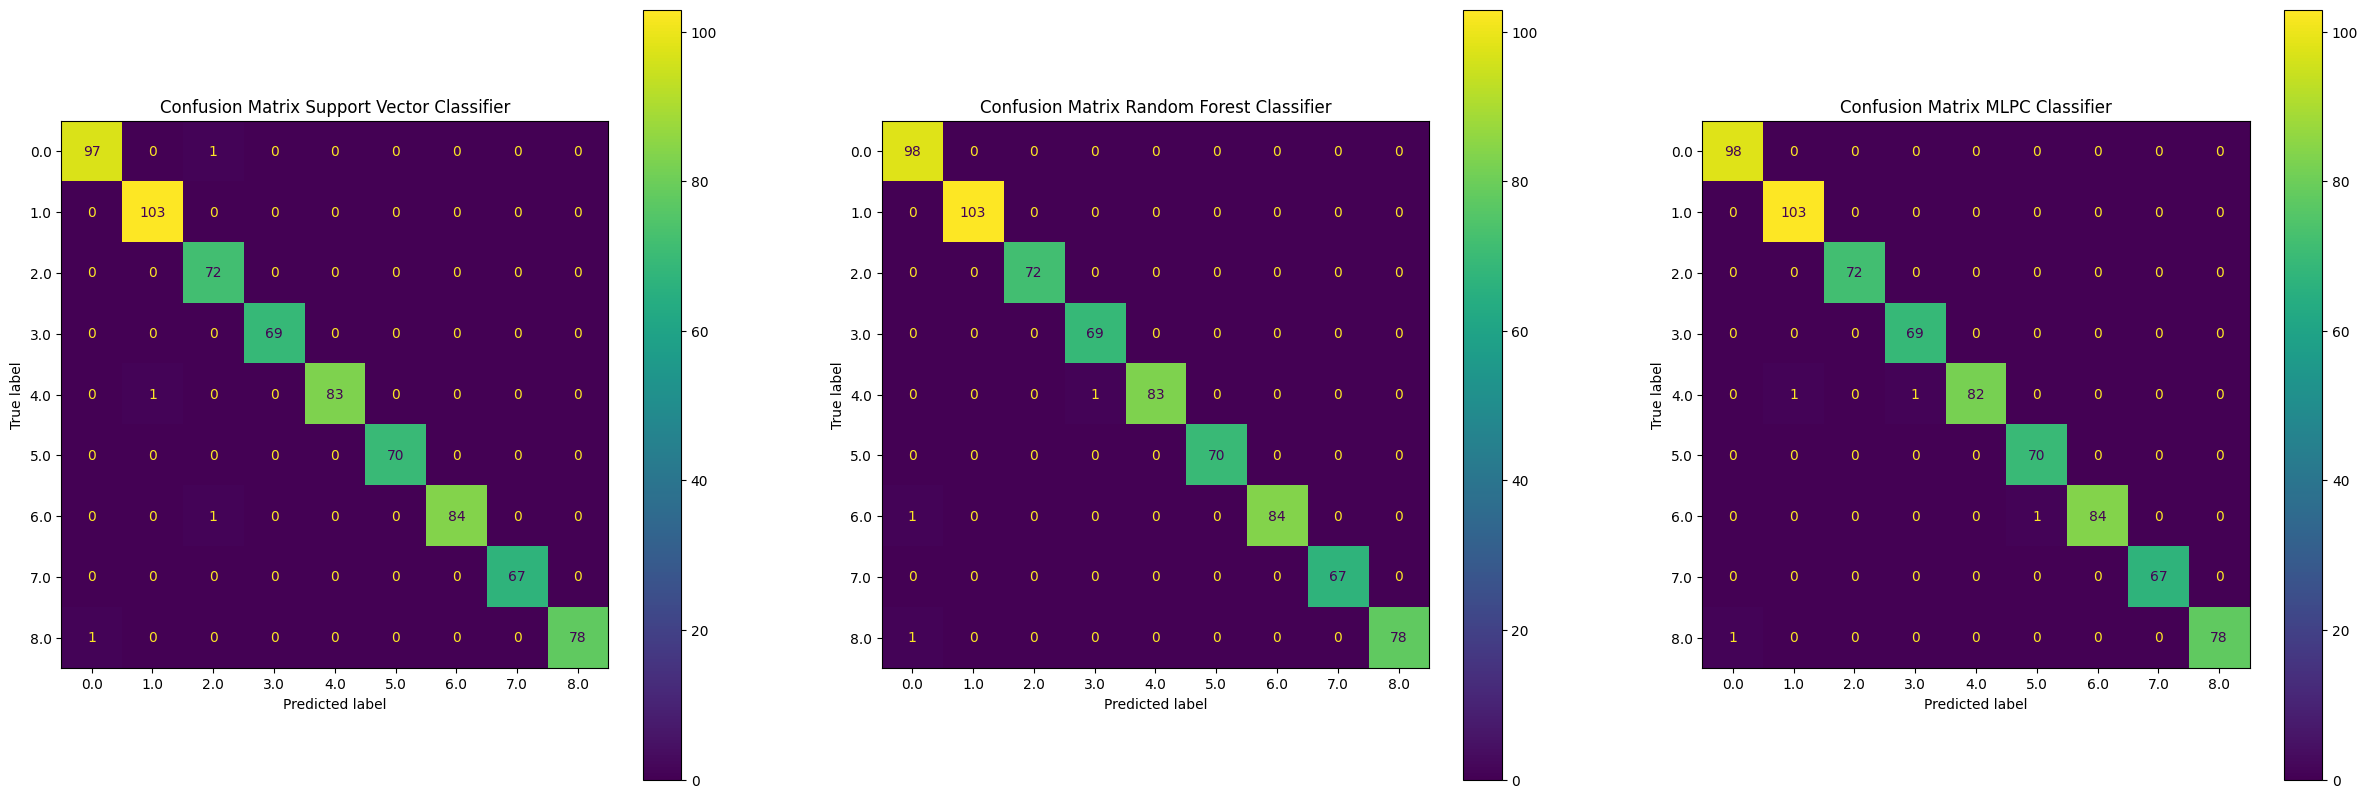

Accuracy SVC: 0.9944979367262724
Accuracy RandomForestClassifier: 0.9986244841815681
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       5.618022      1.287009         0.002239        0.000104   
1       1.495297      0.294863         0.004191        0.004036   
2       2.271582      0.564085         0.003486        0.001736   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.993115   
1                       10  {'hidden_layer_sizes': 10}           0.996558   
2                       15  {'hidden_layer_sizes': 15}           1.000000   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.994836           0.994836           0.996558           0.996552   
1           0.994836           0.991394           0.993115           0.994828   
2           0.996558           0.994836           0.993115           0.998276   

   mean_test

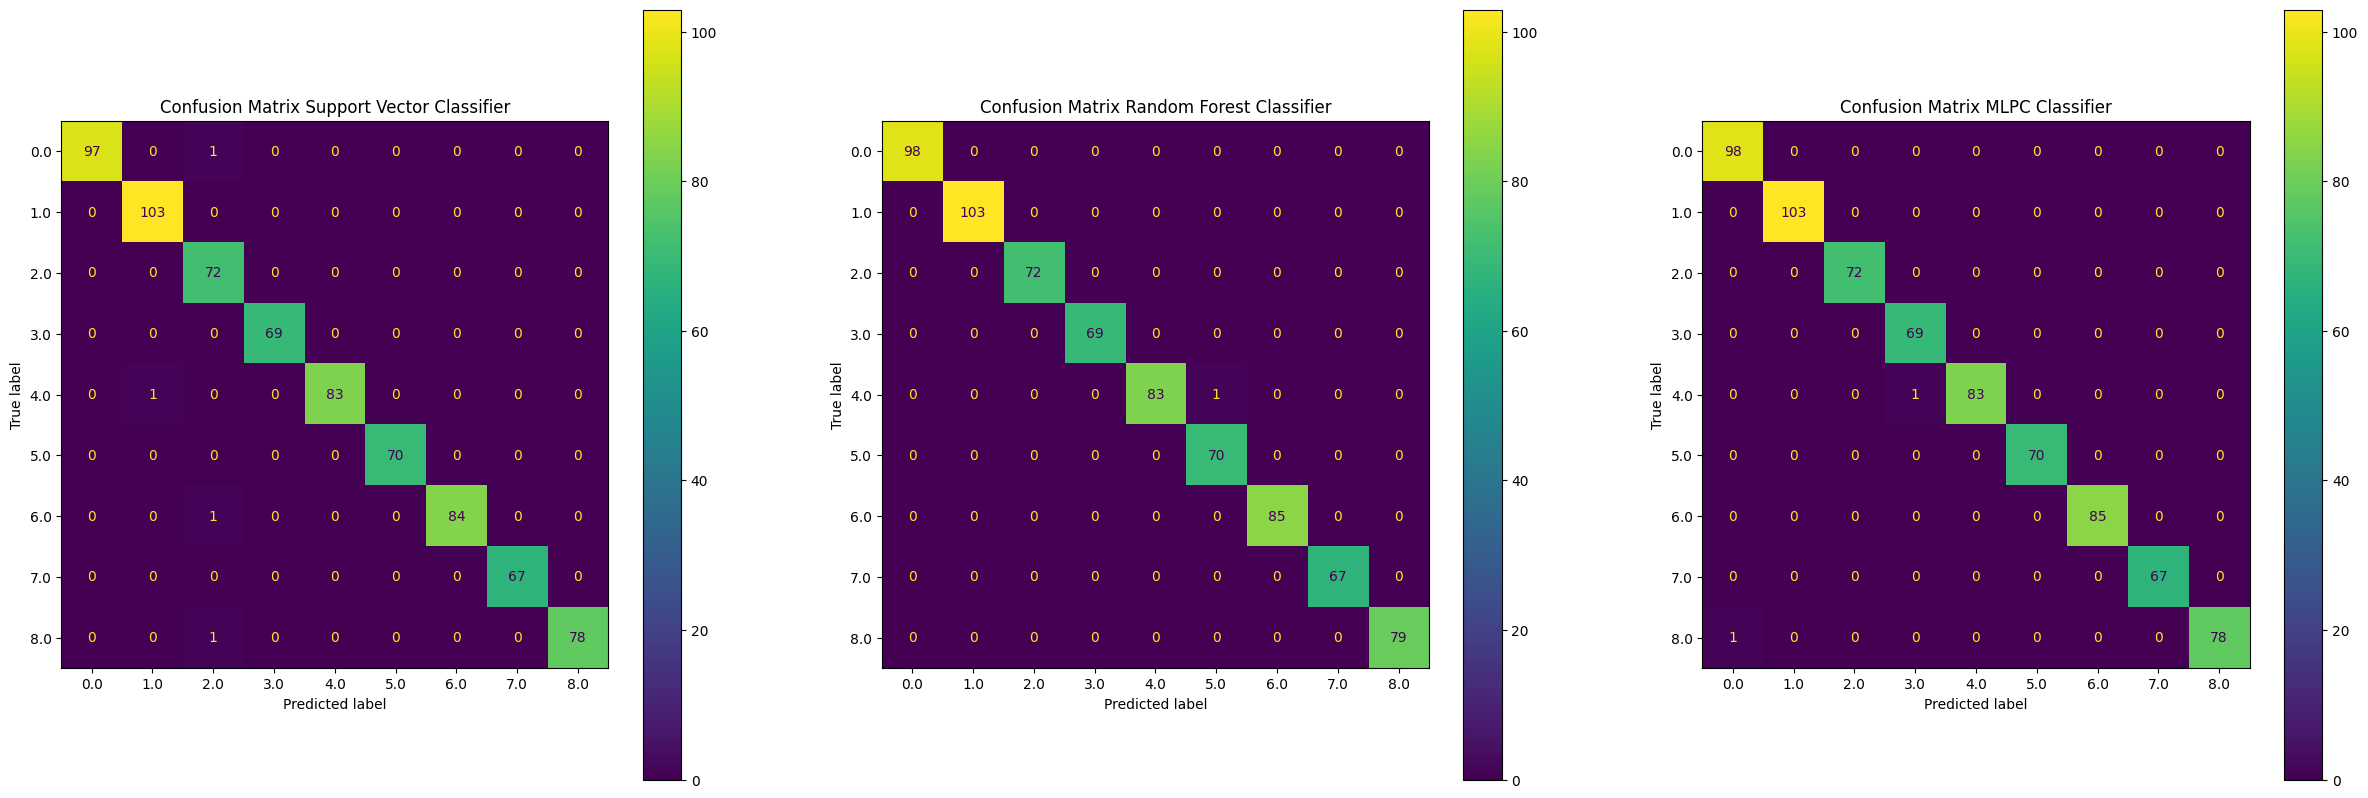

In [ ]:
train_person_classifier(uba_scaled_data, cutting_points)
train_person_classifier(uba_pca_all_data, cutting_points)
train_person_classifier(uba_pca_vector_data, cutting_points)
train_person_classifier(uba_pca_per_variable_data, cutting_points)

In [ ]:
uba_svc_0, uba_rfc_0, uba_mlpc_0 = leave_one_out(uba_scaled_data, speed_labels, person_labels)
uba_svc_1, uba_rfc_1, uba_mlpc_1 = leave_one_out(uba_pca_all_data, speed_labels, person_labels)
uba_svc_2, uba_rfc_2, uba_mlpc_2 = leave_one_out(uba_pca_vector_data, speed_labels, person_labels)
uba_svc_3, uba_rfc_3, uba_mlpc_3 = leave_one_out(uba_pca_per_variable_data, speed_labels, person_labels)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_kernel  \
0       4.459402      1.166354         0.700813        0.163185          rbf   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'kernel': 'rbf'}           0.483801           0.935484           0.860825   

   split3_test_score  split4_test_score  split5_test_score  split6_test_score  \
0           0.952909                1.0           0.997319            0.95202   

   split7_test_score  split8_test_score  mean_test_score  std_test_score  \
0           0.928947           0.782946         0.877139        0.153053   

   rank_test_score  
0                1  
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      12.200042      0.750347         0.025949        0.009363   
1      24.889932      1.394797         0.036685        0.002653   
2      18.415217      0.543092         0.030644        0.013541   
3      35.026188      3.140670         0.047532   

In [ ]:
upper_body_positions, ubp_positions= extract_scenario((["SHOULDER_POSITION", "ELBOW_POSITION", "WRIST_POSITION"]), results, column_names)
ubp_labels = np.take(angle_labels, ubp_positions)
ubp_scaled_data = normal_data(upper_body_positions)
ubp_pca_all_data, ubp_pca_all = pca_all(upper_body_positions)
ubp_pca_vector_data,ubp_pca_vector = pca_vector(upper_body_positions)
ubp_pca_per_variable_data, ubp_pca_per_feature_names, ubp_pca_per_components = pca_per_variable(upper_body_positions, ubp_labels)
#feature_names, result_components

(3631, 1800)
(3631, 1800)
(18, 3631, 100)
(3631, 54)
['_L_SHOULDER_POSITION_X_Component_0', '_L_SHOULDER_POSITION_X_Component_1', '_L_SHOULDER_POSITION_X_Component_2', '_L_SHOULDER_POSITION_Y_Component_0', '_L_SHOULDER_POSITION_Y_Component_1', '_L_SHOULDER_POSITION_Y_Component_2', '_L_SHOULDER_POSITION_Z_Component_0', '_L_SHOULDER_POSITION_Z_Component_1', '_L_SHOULDER_POSITION_Z_Component_2', '_R_SHOULDER_POSITION_X_Component_0', '_R_SHOULDER_POSITION_X_Component_1', '_R_SHOULDER_POSITION_X_Component_2', '_R_SHOULDER_POSITION_Y_Component_0', '_R_SHOULDER_POSITION_Y_Component_1', '_R_SHOULDER_POSITION_Y_Component_2', '_R_SHOULDER_POSITION_Z_Component_0', '_R_SHOULDER_POSITION_Z_Component_1', '_R_SHOULDER_POSITION_Z_Component_2', '_L_ELBOW_POSITION_X_Component_0', '_L_ELBOW_POSITION_X_Component_1', '_L_ELBOW_POSITION_X_Component_2', '_L_ELBOW_POSITION_Y_Component_0', '_L_ELBOW_POSITION_Y_Component_1', '_L_ELBOW_POSITION_Y_Component_2', '_L_ELBOW_POSITION_Z_Component_0', '_L_ELBOW_POSITIO

Accuracy SVC: 0.9958734525447043
Accuracy RandomForestClassifier: 1.0
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      15.561390      1.702207         0.012155        0.003385   
1       6.771148      1.581992         0.006929        0.000257   
2       8.450466      1.652586         0.010258        0.003929   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.993115   
1                       10  {'hidden_layer_sizes': 10}           0.994836   
2                       15  {'hidden_layer_sizes': 15}           0.993115   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.998279           0.996558           0.993115           0.998276   
1           0.996558           0.996558           0.993115           0.998276   
2           0.998279           0.994836           0.991394           1.000000   

   mean_test_score  std_tes

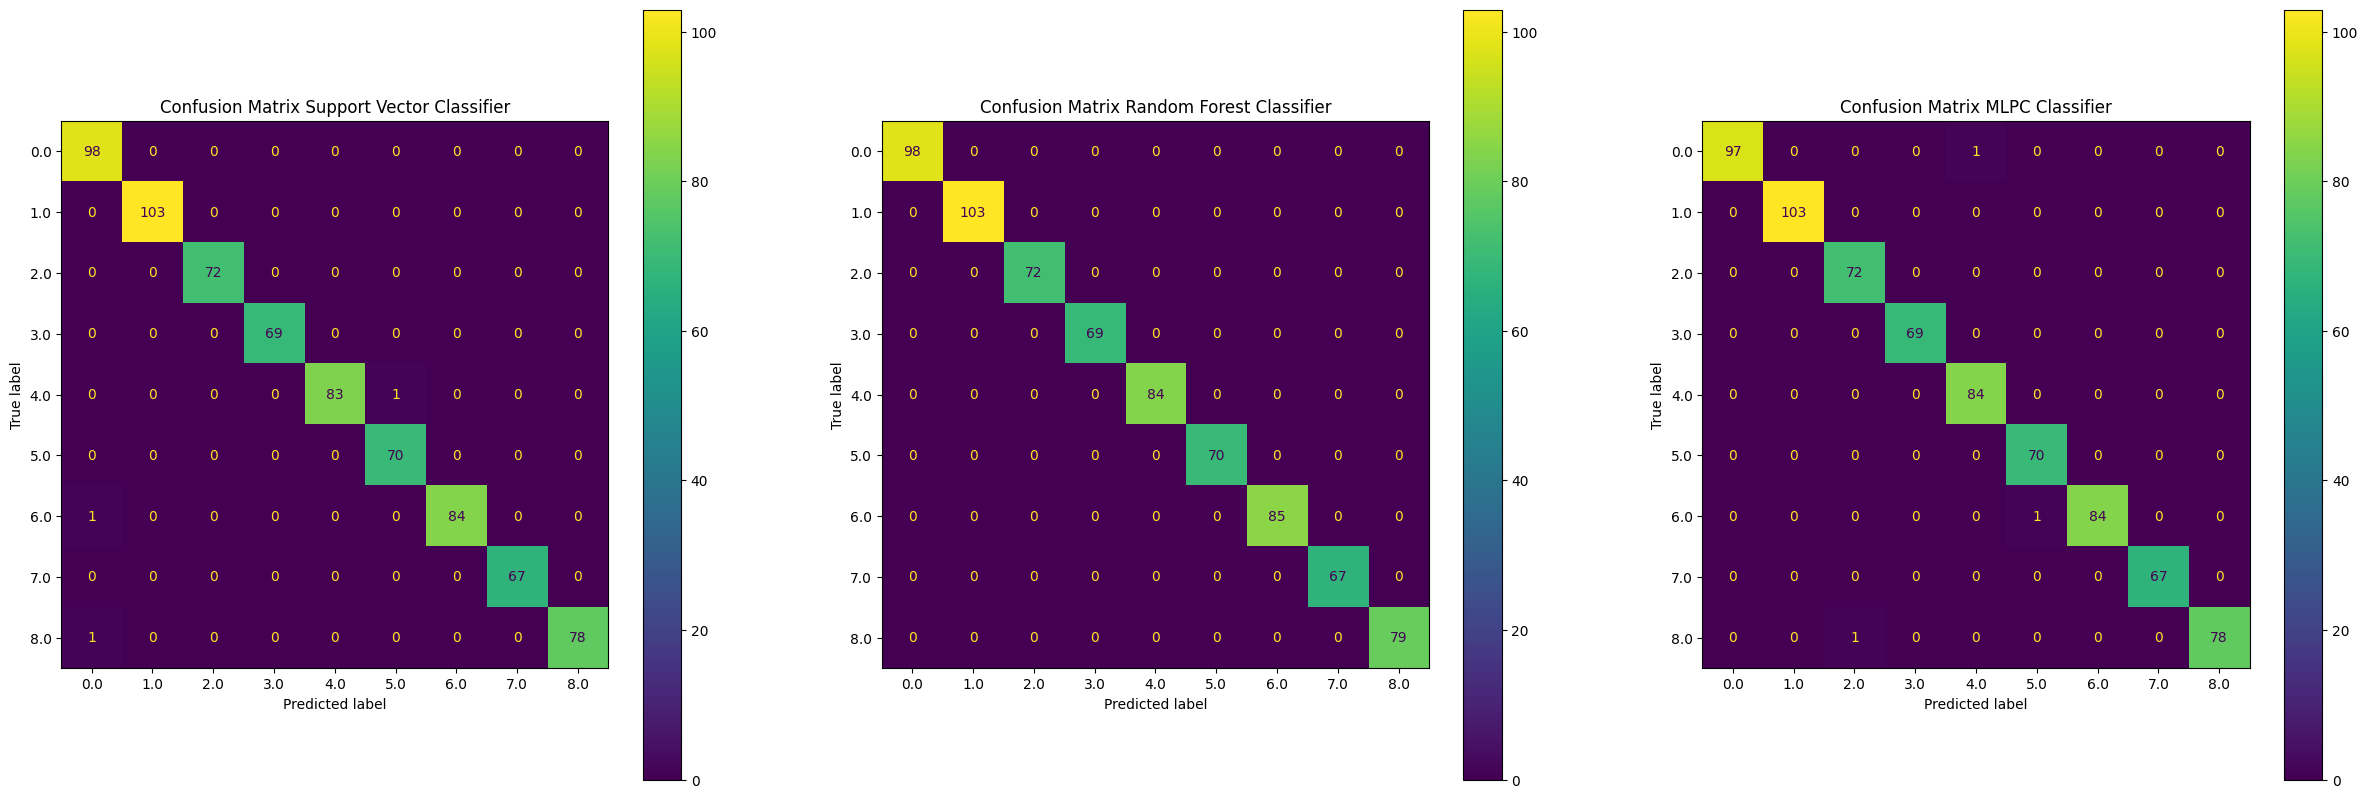

Accuracy SVC: 0.9972489683631361
Accuracy RandomForestClassifier: 0.9931224209078404
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      12.843853      1.508027         0.004116        0.001480   
1      10.590783      2.955273         0.006769        0.003632   
2       4.005218      0.801714         0.003857        0.000063   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.991394   
1                       10  {'hidden_layer_sizes': 10}           0.987952   
2                       15  {'hidden_layer_sizes': 15}           0.996558   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.984509           0.977625           0.989673           0.989655   
1           0.993115           0.991394           0.993115           0.996552   
2           0.994836           0.993115           0.993115           1.000000   

   mean_test

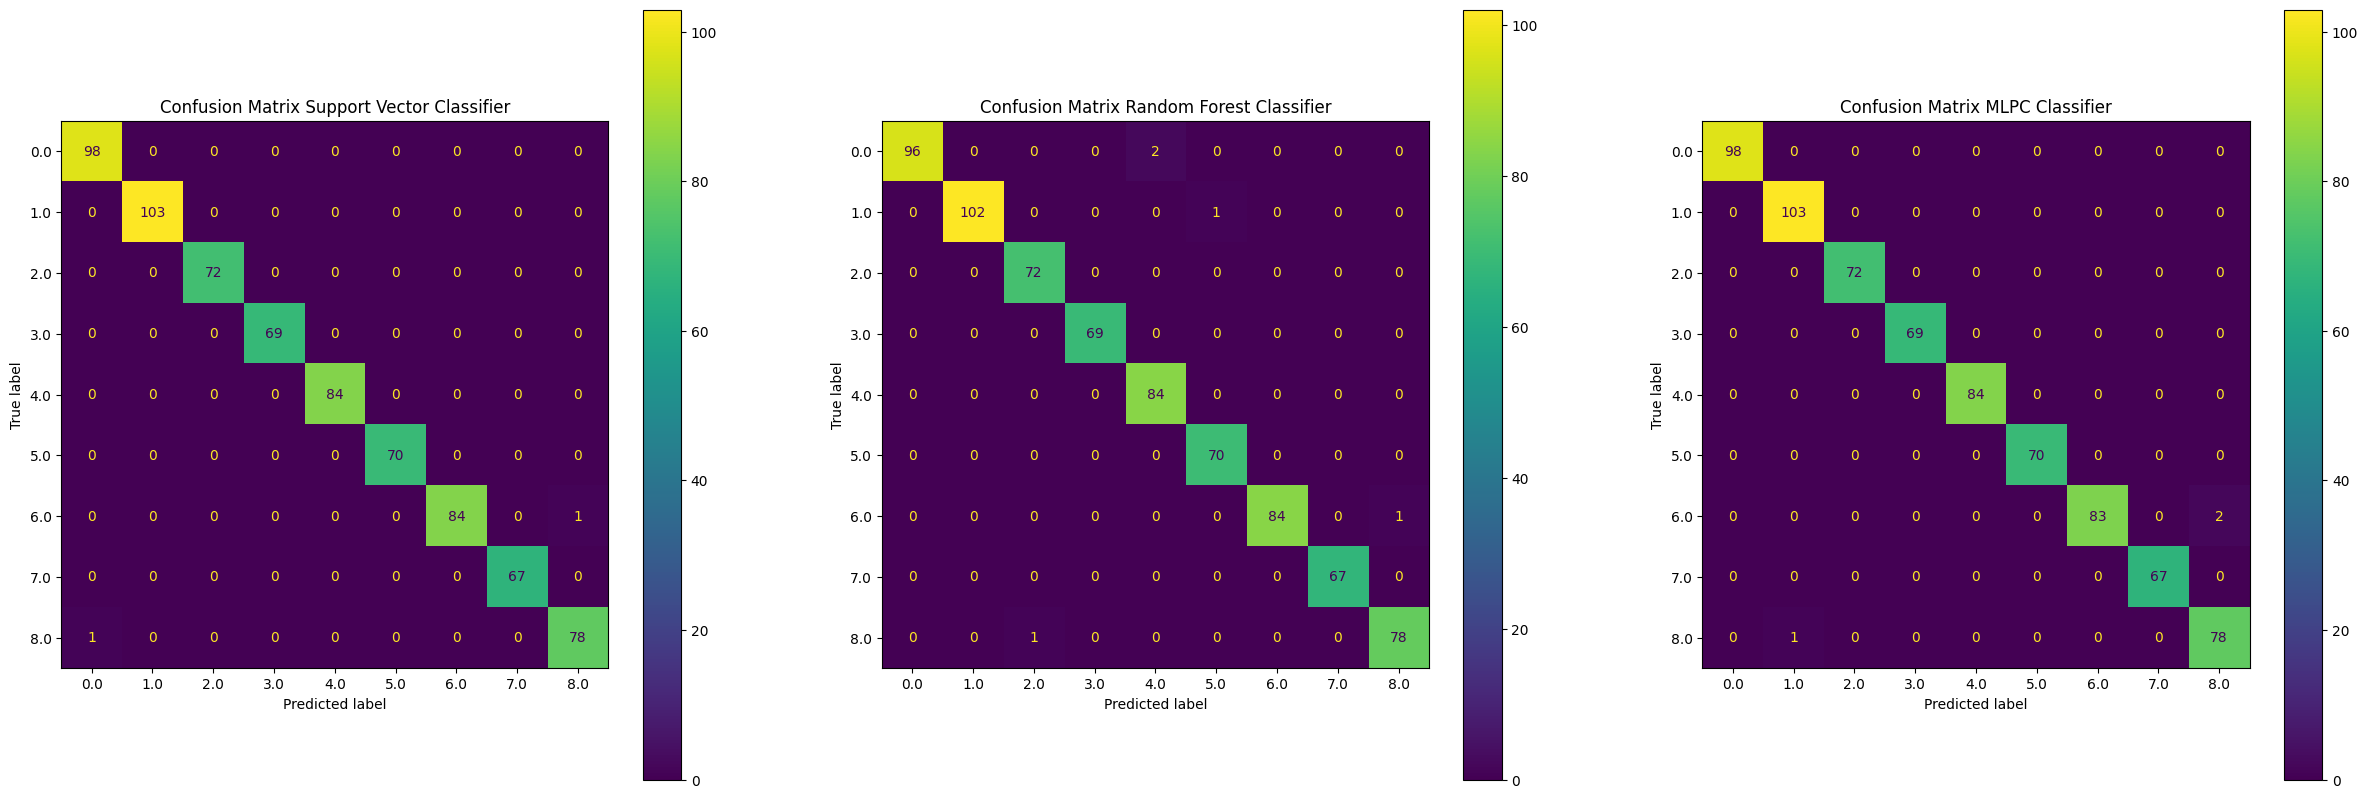

Accuracy SVC: 0.9972489683631361
Accuracy RandomForestClassifier: 0.9972489683631361
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       5.316593      1.139958         0.001954        0.000159   
1       1.373205      0.283151         0.002631        0.001271   
2       1.167268      0.117394         0.002660        0.001739   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.991394   
1                       10  {'hidden_layer_sizes': 10}           0.993115   
2                       15  {'hidden_layer_sizes': 15}           0.991394   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.993115           0.996558           0.993115           0.989655   
1           0.998279           0.996558           0.996558           0.994828   
2           0.994836           0.993115           0.993115           0.993103   

   mean_test

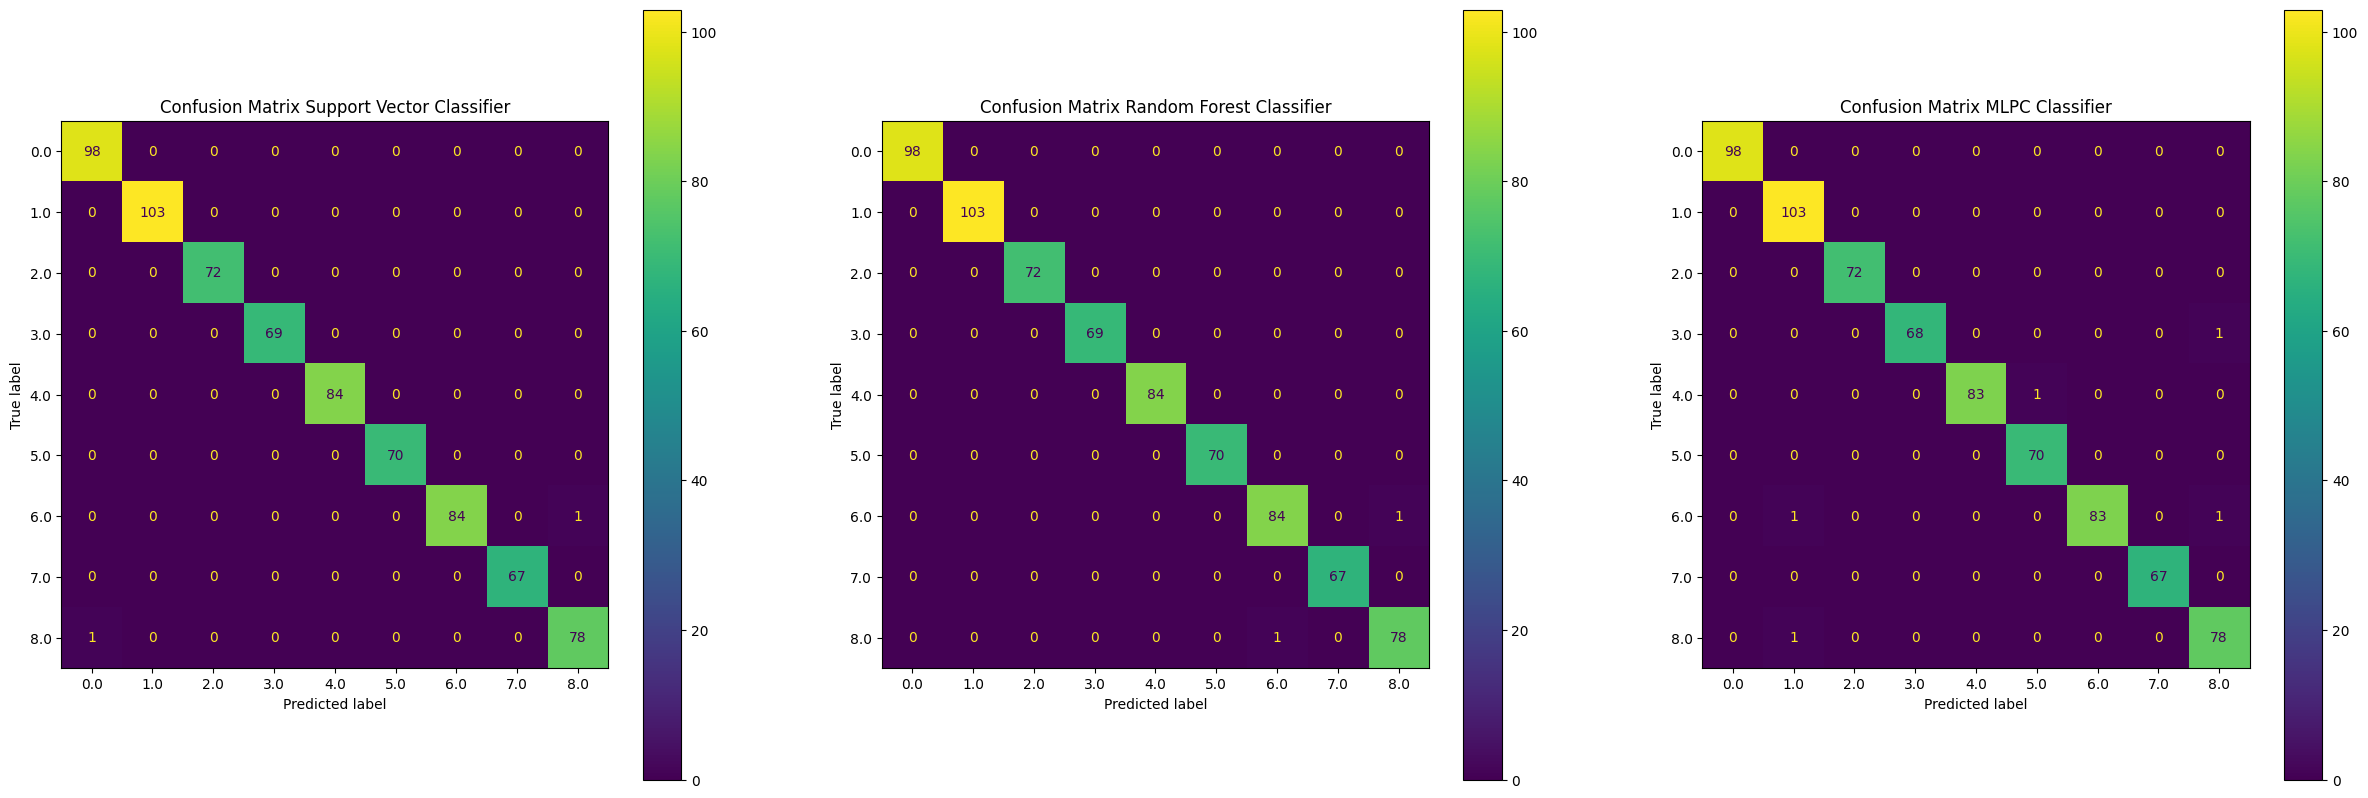

Accuracy SVC: 0.9958734525447043
Accuracy RandomForestClassifier: 1.0
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       5.129132      1.275631         0.002472        0.000293   
1       1.170716      0.050505         0.002015        0.000042   
2       1.873054      0.653463         0.003143        0.002045   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.993115   
1                       10  {'hidden_layer_sizes': 10}           0.998279   
2                       15  {'hidden_layer_sizes': 15}           0.994836   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.991394           0.989673           0.994836           0.998276   
1           0.991394           0.996558           0.991394           0.996552   
2           1.000000           0.994836           0.994836           0.996552   

   mean_test_score  std_tes

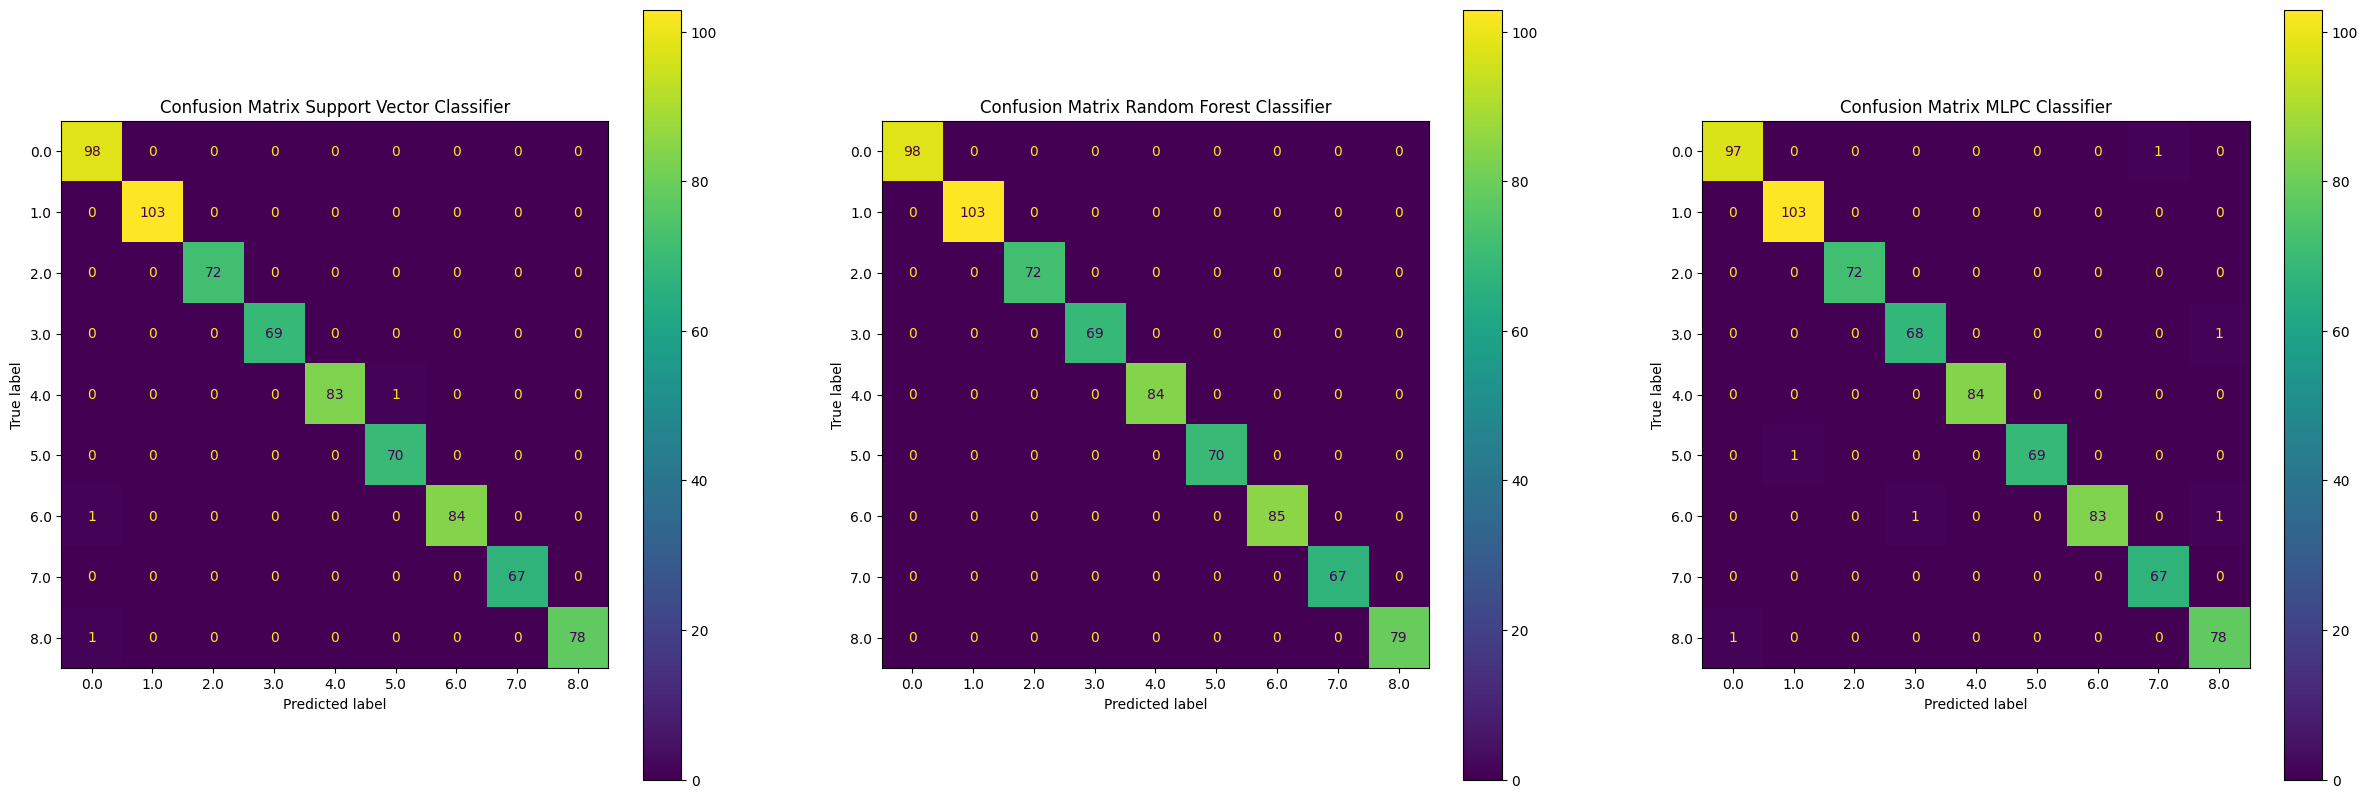

In [ ]:
train_person_classifier(ubp_scaled_data, cutting_points)
train_person_classifier(ubp_pca_all_data, cutting_points)
train_person_classifier(ubp_pca_vector_data, cutting_points)
train_person_classifier(ubp_pca_per_variable_data, cutting_points)

In [ ]:
ubp_svc_0, ubp_rfc_0, ubp_mlpc_0 = leave_one_out(ubp_scaled_data, speed_labels, person_labels)
ubp_svc_1, ubp_rfc_1, ubp_mlpc_1 = leave_one_out(ubp_pca_all_data, speed_labels, person_labels)
ubp_svc_2, ubp_rfc_2, ubp_mlpc_2 = leave_one_out(ubp_pca_vector_data, speed_labels, person_labels)
ubp_svc_3, ubp_rfc_3, ubp_mlpc_3 = leave_one_out(ubp_pca_per_variable_data, speed_labels, person_labels)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_kernel  \
0       2.924728       0.31908         0.420793        0.130527          rbf   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'kernel': 'rbf'}           0.952484           0.997849           0.404639   

   split3_test_score  split4_test_score  split5_test_score  split6_test_score  \
0           0.972299                1.0           0.997319           0.989899   

   split7_test_score  split8_test_score  mean_test_score  std_test_score  \
0           0.981579                1.0         0.921785        0.183447   

   rank_test_score  
0                1  
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      13.723273      0.900191         0.028945        0.006224   
1      27.122979      1.097975         0.056305        0.027151   
2      20.118109      0.780886         0.029711        0.015435   
3      39.260358      3.760290         0.060133   

In [ ]:
upper_body, ub_positions= extract_scenario((["SHOULDER_ANGLE", "ELBOW_ANGLE", "TORSO_ANGLE_wrt_PELVIS","SHOULDER_POSITION", "ELBOW_POSITION", "WRIST_POSITION"]), results, column_names)
ub_labels = np.take(angle_labels, ub_positions)
ub_scaled_data = normal_data(upper_body)
ub_pca_all_data, ub_pca_all = pca_all(upper_body)
ub_pca_vector_data,ub_pca_vector = pca_vector(upper_body)
ub_pca_per_variable_data, ub_pca_per_feature_names, ub_pca_per_components = pca_per_variable(upper_body, ub_labels)
#feature_names, result_components

(3631, 3300)
(3631, 3300)
(33, 3631, 100)
(3631, 132)
['_L_SHOULDER_ANGLE_X_Component_0', '_L_SHOULDER_ANGLE_X_Component_1', '_L_SHOULDER_ANGLE_X_Component_2', '_L_SHOULDER_ANGLE_X_Component_3', '_L_SHOULDER_ANGLE_Y_Component_0', '_L_SHOULDER_ANGLE_Y_Component_1', '_L_SHOULDER_ANGLE_Y_Component_2', '_L_SHOULDER_ANGLE_Y_Component_3', '_L_SHOULDER_ANGLE_Z_Component_0', '_L_SHOULDER_ANGLE_Z_Component_1', '_L_SHOULDER_ANGLE_Z_Component_2', '_L_SHOULDER_ANGLE_Z_Component_3', '_R_SHOULDER_ANGLE_X_Component_0', '_R_SHOULDER_ANGLE_X_Component_1', '_R_SHOULDER_ANGLE_X_Component_2', '_R_SHOULDER_ANGLE_X_Component_3', '_R_SHOULDER_ANGLE_Y_Component_0', '_R_SHOULDER_ANGLE_Y_Component_1', '_R_SHOULDER_ANGLE_Y_Component_2', '_R_SHOULDER_ANGLE_Y_Component_3', '_R_SHOULDER_ANGLE_Z_Component_0', '_R_SHOULDER_ANGLE_Z_Component_1', '_R_SHOULDER_ANGLE_Z_Component_2', '_R_SHOULDER_ANGLE_Z_Component_3', '_L_ELBOW_ANGLE_X_Component_0', '_L_ELBOW_ANGLE_X_Component_1', '_L_ELBOW_ANGLE_X_Component_2', '_L_ELBOW

Accuracy SVC: 0.9944979367262724
Accuracy RandomForestClassifier: 1.0
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      13.771149      0.578882         0.023113        0.010386   
1       9.567549      1.228682         0.013486        0.002435   
2       9.092066      2.190593         0.016599        0.004311   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.993115   
1                       10  {'hidden_layer_sizes': 10}           0.998279   
2                       15  {'hidden_layer_sizes': 15}           0.998279   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.996558                1.0                1.0           0.996552   
1           1.000000                1.0                1.0           0.998276   
2           1.000000                1.0                1.0           0.998276   

   mean_test_score  std_tes

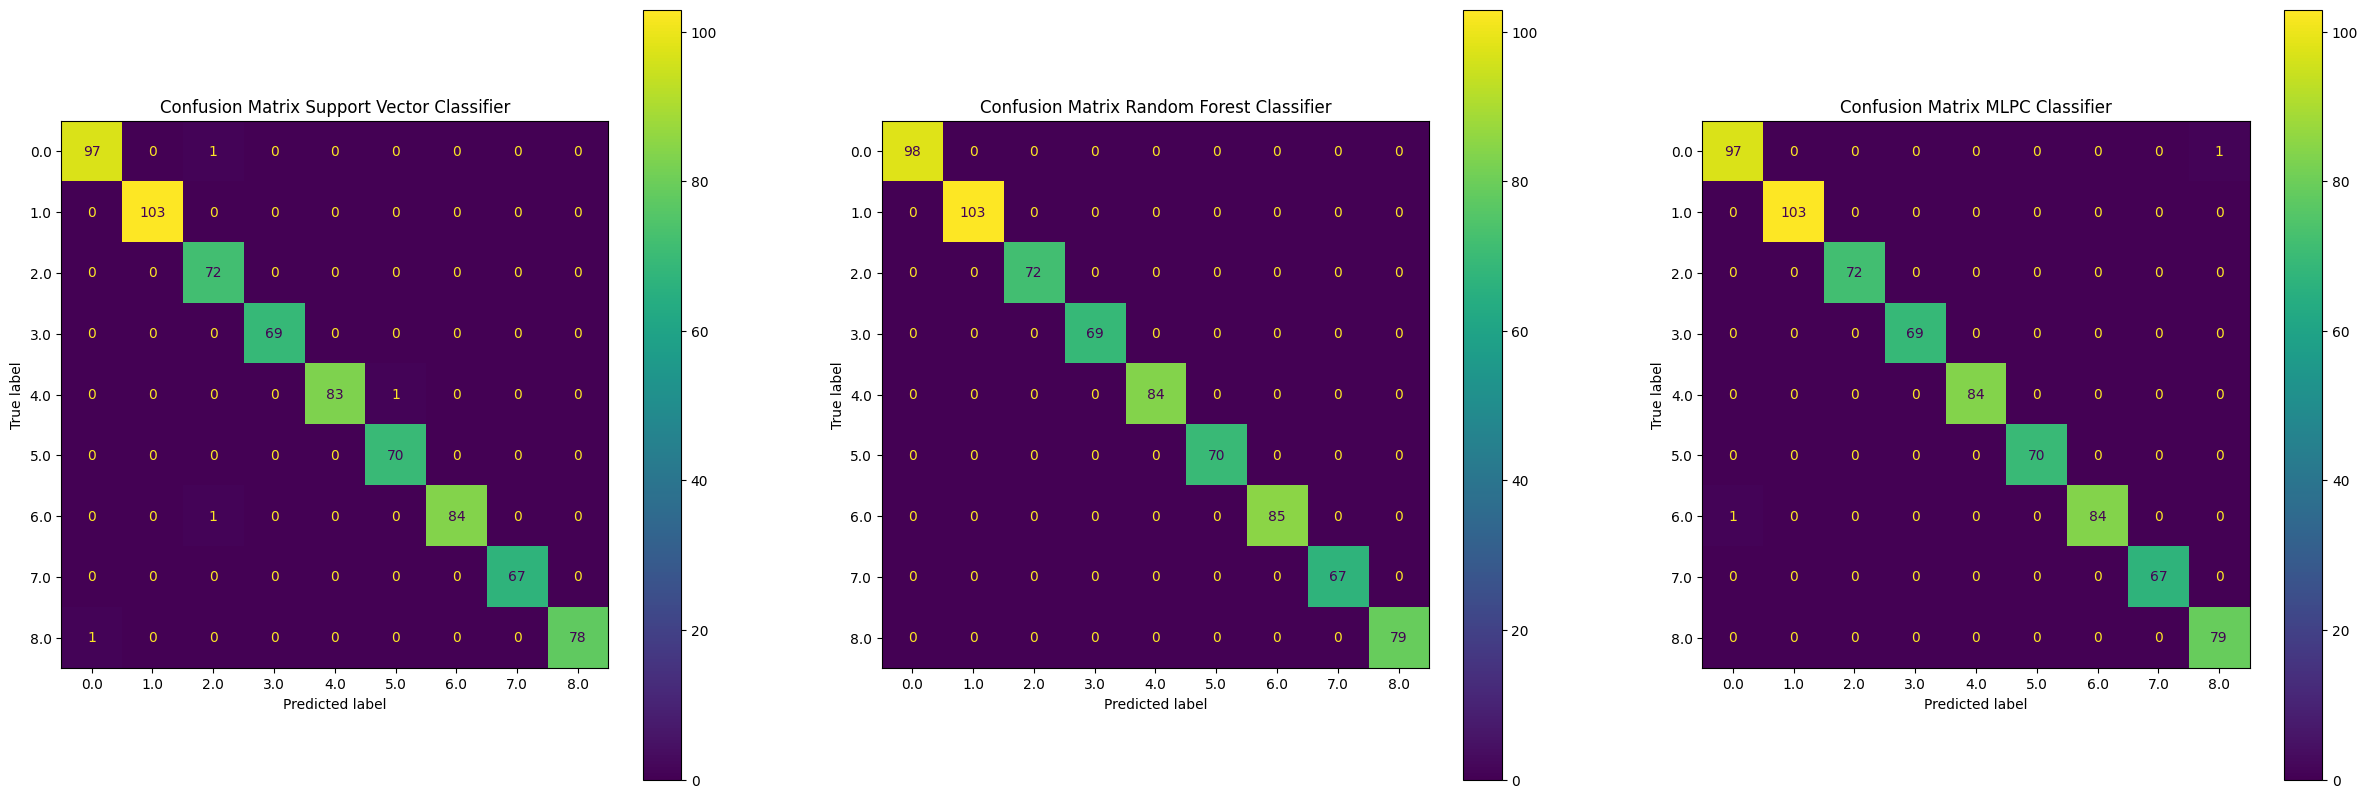

Accuracy SVC: 0.9958734525447043
Accuracy RandomForestClassifier: 0.9972489683631361
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      22.740680      4.389596         0.006645        0.002124   
1       3.805924      0.275525         0.006449        0.001325   
2       4.775287      1.639453         0.008199        0.004086   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.996558   
1                       10  {'hidden_layer_sizes': 10}           0.994836   
2                       15  {'hidden_layer_sizes': 15}           0.998279   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.998279           0.998279           0.998279           0.996552   
1           1.000000           0.996558           1.000000           0.996552   
2           0.996558           1.000000           1.000000           0.998276   

   mean_test

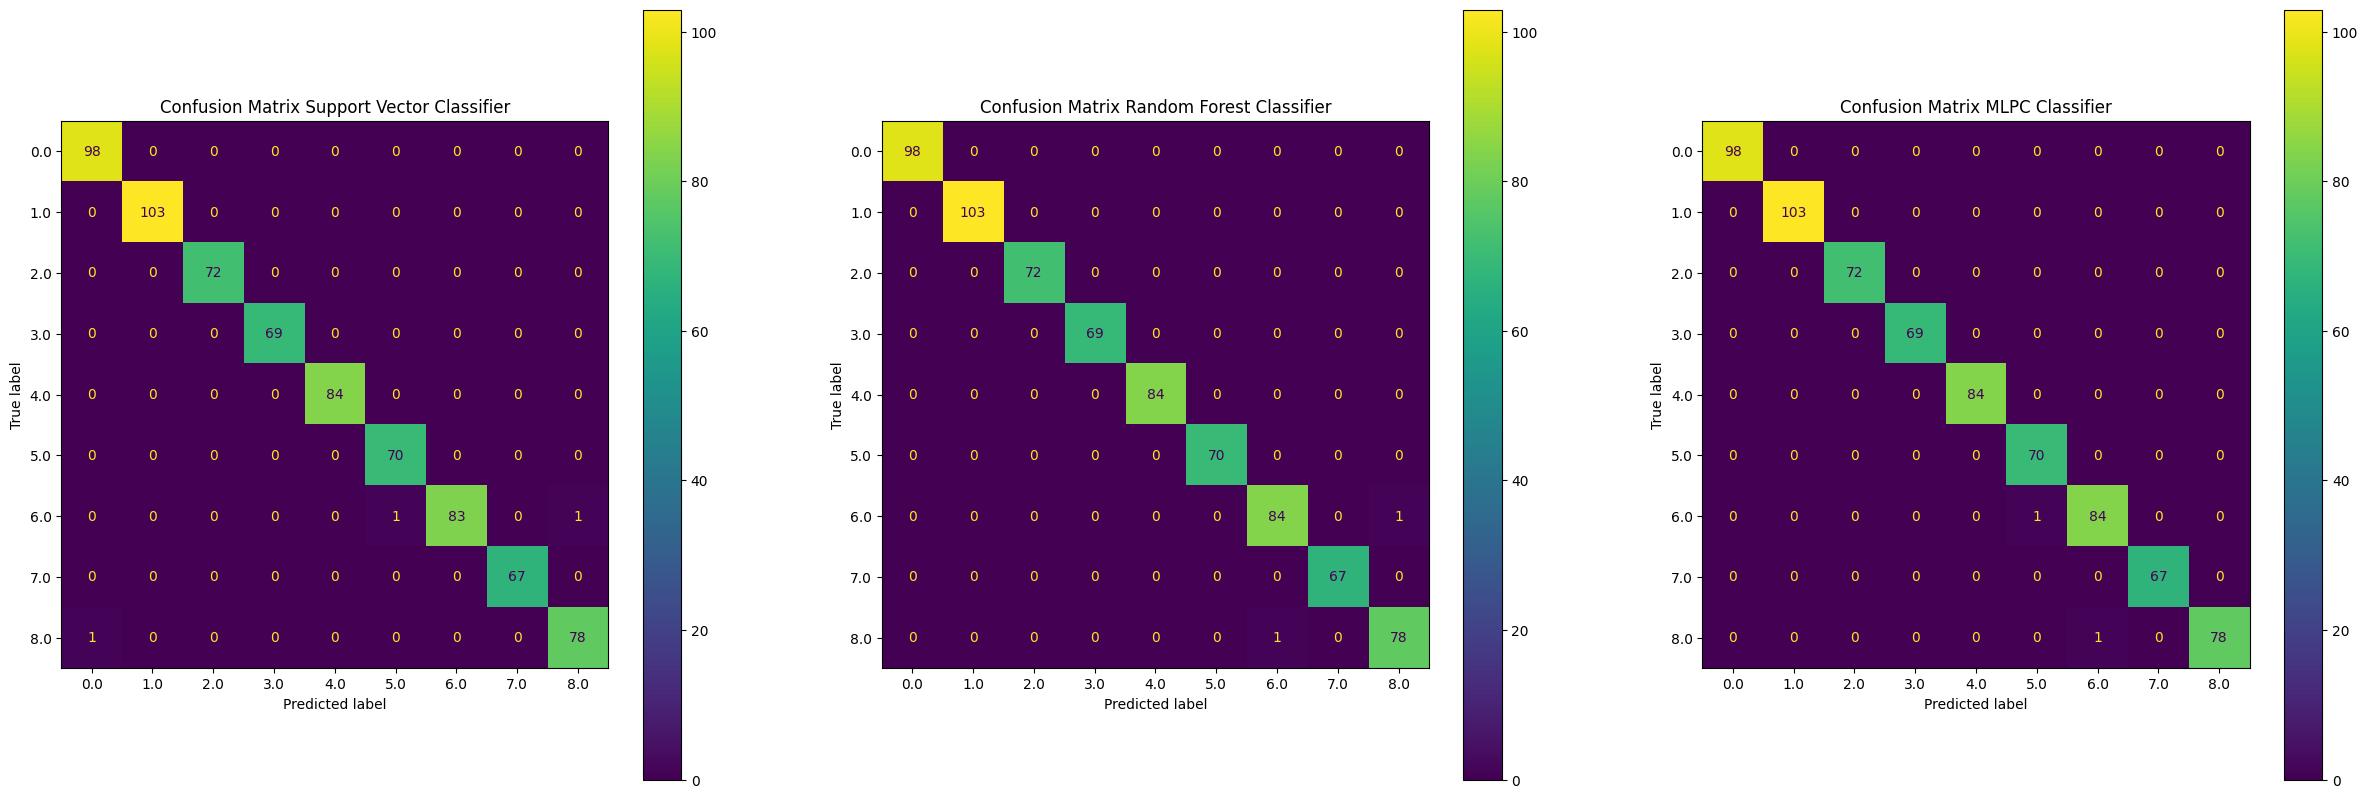

Accuracy SVC: 0.9958734525447043
Accuracy RandomForestClassifier: 0.9986244841815681
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.310662      0.058544         0.003084        0.001662   
1       1.028719      0.081949         0.002085        0.000112   
2       0.657331      0.054606         0.001999        0.000072   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.998279   
1                       10  {'hidden_layer_sizes': 10}           0.996558   
2                       15  {'hidden_layer_sizes': 15}           1.000000   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.991394           0.994836           0.994836           0.993103   
1           0.991394           0.998279           0.994836           0.996552   
2           0.996558           0.991394           0.987952           0.996552   

   mean_test

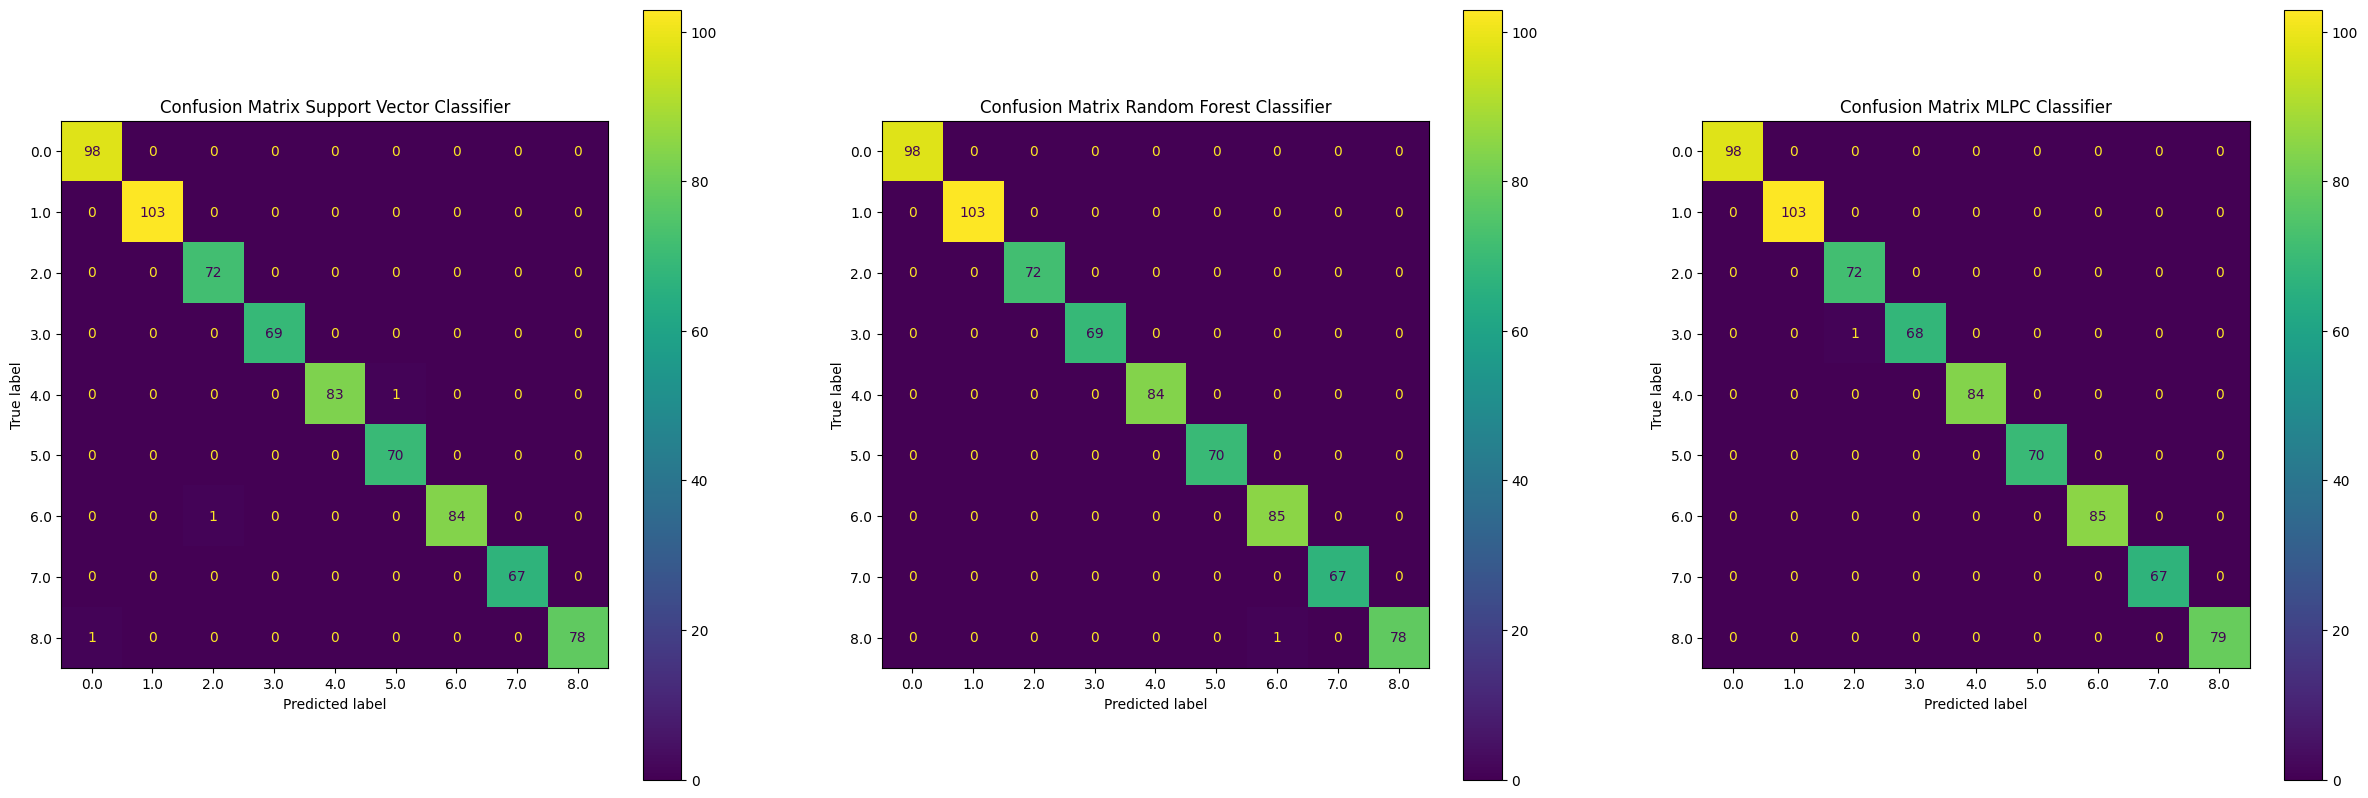

Accuracy SVC: 0.9958734525447043
Accuracy RandomForestClassifier: 1.0
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       6.916192      1.399397         0.002294        0.000172   
1       1.739296      0.224700         0.006840        0.005035   
2       0.872568      0.066221         0.002241        0.000381   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.870912   
1                       10  {'hidden_layer_sizes': 10}           0.994836   
2                       15  {'hidden_layer_sizes': 15}           0.994836   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.888124           0.881239           0.907057           0.881034   
1           0.998279           0.994836           0.996558           0.996552   
2           0.996558           0.996558           0.998279           0.996552   

   mean_test_score  std_tes

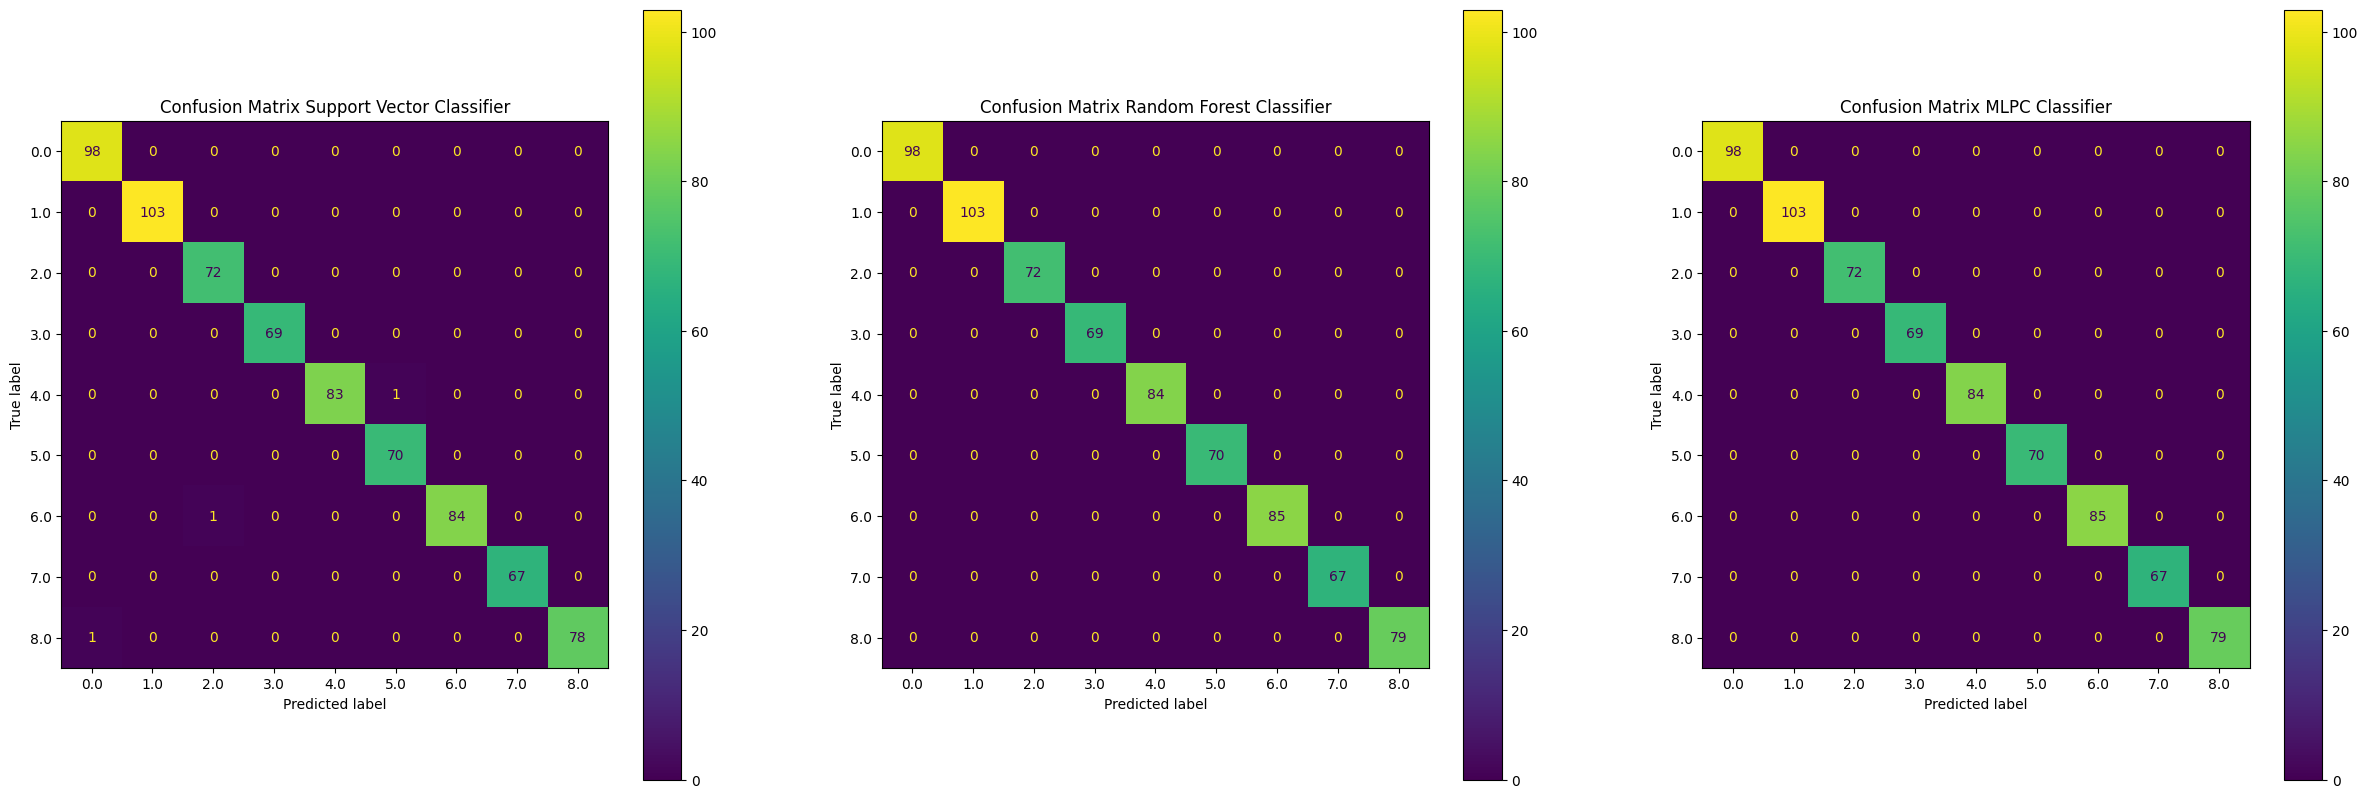

In [ ]:
train_person_classifier(ub_scaled_data, cutting_points)
train_person_classifier(ub_pca_all_data, cutting_points)
train_person_classifier(ub_pca_vector_data, cutting_points)
train_person_classifier(ub_pca_per_variable_data, cutting_points)


In [ ]:
ub_svc_0, ub_rfc_0, ub_mlpc_0 = leave_one_out(ub_scaled_data, speed_labels, person_labels)
ub_svc_1, ub_rfc_1, ub_mlpc_1 = leave_one_out(ub_pca_all_data, speed_labels, person_labels)
ub_svc_2, ub_rfc_2, ub_mlpc_2 = leave_one_out(ub_pca_vector_data, speed_labels, person_labels)
ub_svc_3, ub_rfc_3, ub_mlpc_3 = leave_one_out(ub_pca_per_variable_data, speed_labels, person_labels)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_kernel  \
0       7.443277      1.291639          1.54435        0.525273          rbf   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'kernel': 'rbf'}           0.803456           0.995699           0.809278   

   split3_test_score  split4_test_score  split5_test_score  split6_test_score  \
0            0.99723                1.0           0.994638           0.969697   

   split7_test_score  split8_test_score  mean_test_score  std_test_score  \
0           0.997368           0.992248         0.951068        0.077814   

   rank_test_score  
0                1  
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      18.513865      0.224295         0.025778        0.002318   
1      37.326071      0.710584         0.058285        0.020377   
2      27.154530      1.360196         0.038096        0.018594   
3      52.466309      4.394946         0.062503   

In [ ]:
whole_body, wb_positions= extract_scenario((["ANKLE_ANGLE", "KNEE_ANGLE", "HIP_ANGLE", "SHOULDER_ANGLE", "ELBOW_ANGLE", "TORSO_ANGLE_wrt_PELVIS", "MTP_POSITION", "ANKLE_POSITION", "KNEE_POSITION", "HIP_POSITION", "SHOULDER_POSITION", "ELBOW_POSITION", "WRIST_POSITION"]), results, column_names)
wb_labels = np.take(angle_labels, wb_positions)
wb_scaled_data = normal_data(whole_body)
wb_pca_all_data, wb_pca_all = pca_all(whole_body)
wb_pca_vector_data, wb_pca_vector = pca_vector(whole_body)
wb_pca_per_variable_data, wb_pca_per_feature_names, wb_pca_per_components = pca_per_variable(whole_body, wb_labels)
#feature_names, result_components

(3631, 7500)
(3631, 7500)
(75, 3631, 100)
(3631, 300)
['_L_ANKLE_ANGLE_X_Component_0', '_L_ANKLE_ANGLE_X_Component_1', '_L_ANKLE_ANGLE_X_Component_2', '_L_ANKLE_ANGLE_X_Component_3', '_L_ANKLE_ANGLE_Y_Component_0', '_L_ANKLE_ANGLE_Y_Component_1', '_L_ANKLE_ANGLE_Y_Component_2', '_L_ANKLE_ANGLE_Y_Component_3', '_L_ANKLE_ANGLE_Z_Component_0', '_L_ANKLE_ANGLE_Z_Component_1', '_L_ANKLE_ANGLE_Z_Component_2', '_L_ANKLE_ANGLE_Z_Component_3', '_R_ANKLE_ANGLE_X_Component_0', '_R_ANKLE_ANGLE_X_Component_1', '_R_ANKLE_ANGLE_X_Component_2', '_R_ANKLE_ANGLE_X_Component_3', '_R_ANKLE_ANGLE_Y_Component_0', '_R_ANKLE_ANGLE_Y_Component_1', '_R_ANKLE_ANGLE_Y_Component_2', '_R_ANKLE_ANGLE_Y_Component_3', '_R_ANKLE_ANGLE_Z_Component_0', '_R_ANKLE_ANGLE_Z_Component_1', '_R_ANKLE_ANGLE_Z_Component_2', '_R_ANKLE_ANGLE_Z_Component_3', '_L_KNEE_ANGLE_X_Component_0', '_L_KNEE_ANGLE_X_Component_1', '_L_KNEE_ANGLE_X_Component_2', '_L_KNEE_ANGLE_X_Component_3', '_L_KNEE_ANGLE_Y_Component_0', '_L_KNEE_ANGLE_Y_Compo

Accuracy SVC: 0.9958734525447043
Accuracy RandomForestClassifier: 1.0
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0     144.152335      4.638774         0.030108        0.010984   
1      14.173639      1.962224         0.027170        0.005846   
2      13.757101      0.794862         0.035028        0.011161   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}                1.0   
1                       10  {'hidden_layer_sizes': 10}                1.0   
2                       15  {'hidden_layer_sizes': 15}                1.0   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.998279           0.870912           0.998279           0.994828   
1           1.000000           0.998279           1.000000           0.998276   
2           1.000000           1.000000           1.000000           1.000000   

   mean_test_score  std_tes

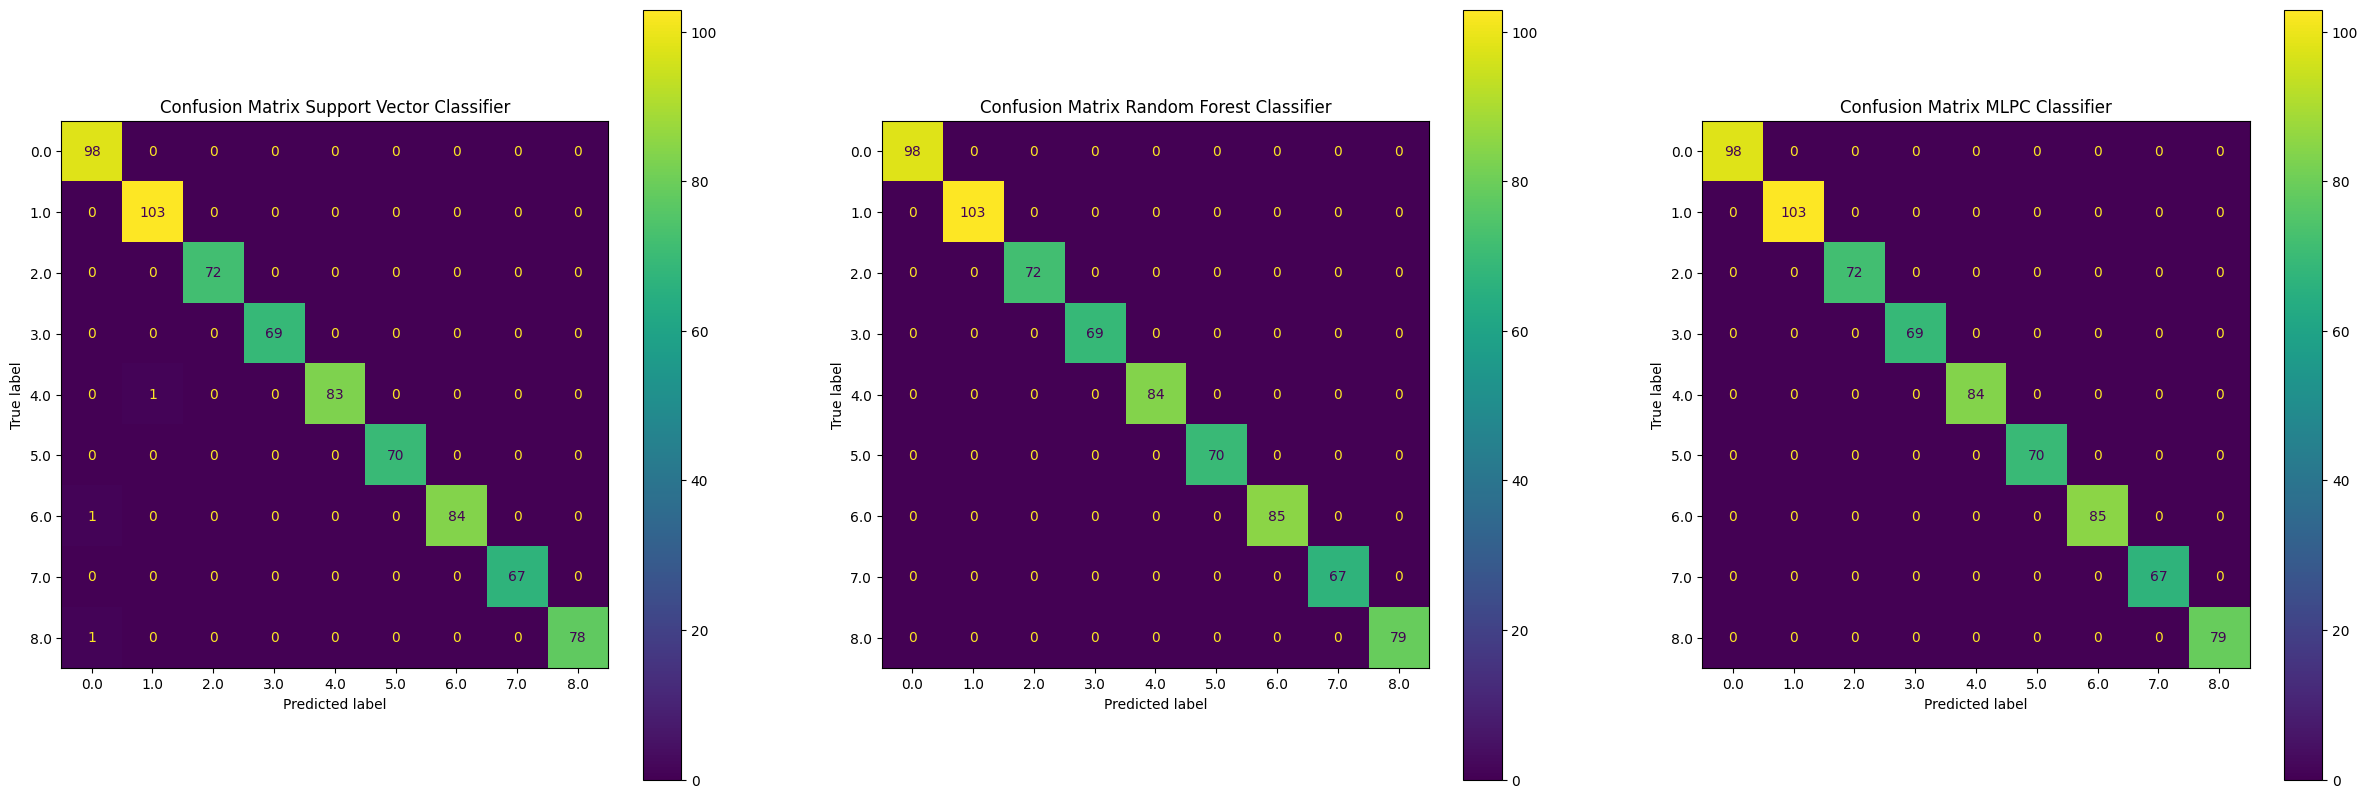

Accuracy SVC: 0.9972489683631361
Accuracy RandomForestClassifier: 1.0
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      30.500974     10.529768         0.011145        0.004561   
1      10.181143      0.901959         0.015680        0.006705   
2       3.830891      0.923392         0.008751        0.002066   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}                1.0   
1                       10  {'hidden_layer_sizes': 10}                1.0   
2                       15  {'hidden_layer_sizes': 15}                1.0   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.996558           0.998279           0.998279           0.998276   
1           0.996558           0.998279           1.000000           1.000000   
2           0.996558           0.998279           1.000000           0.998276   

   mean_test_score  std_tes

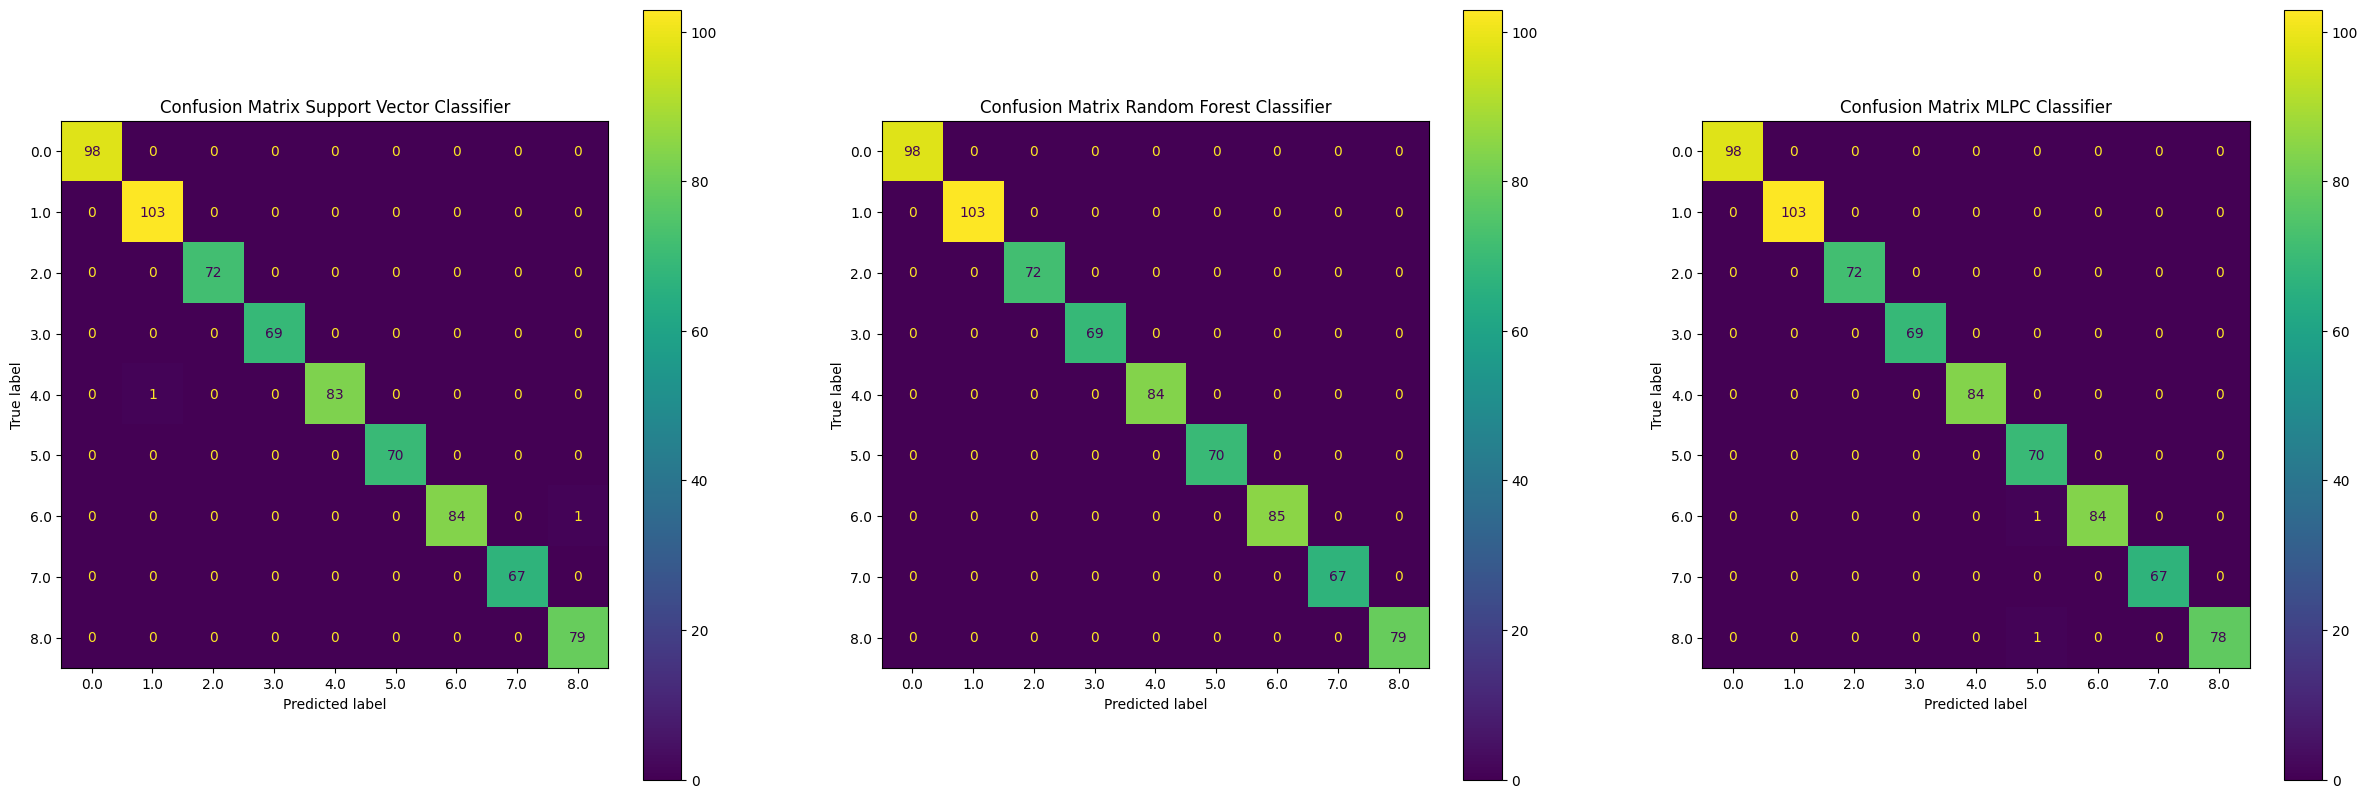

Accuracy SVC: 0.9958734525447043
Accuracy RandomForestClassifier: 0.9986244841815681
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       6.923109      1.289263         0.003201        0.002461   
1       0.746305      0.198325         0.002070        0.000158   
2       0.486962      0.084902         0.002392        0.000808   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           0.994836   
1                       10  {'hidden_layer_sizes': 10}           0.993115   
2                       15  {'hidden_layer_sizes': 15}           0.996558   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.998279           0.994836           1.000000           1.000000   
1           0.996558           0.994836           0.989673           0.998276   
2           0.994836           0.996558           0.994836           0.998276   

   mean_test

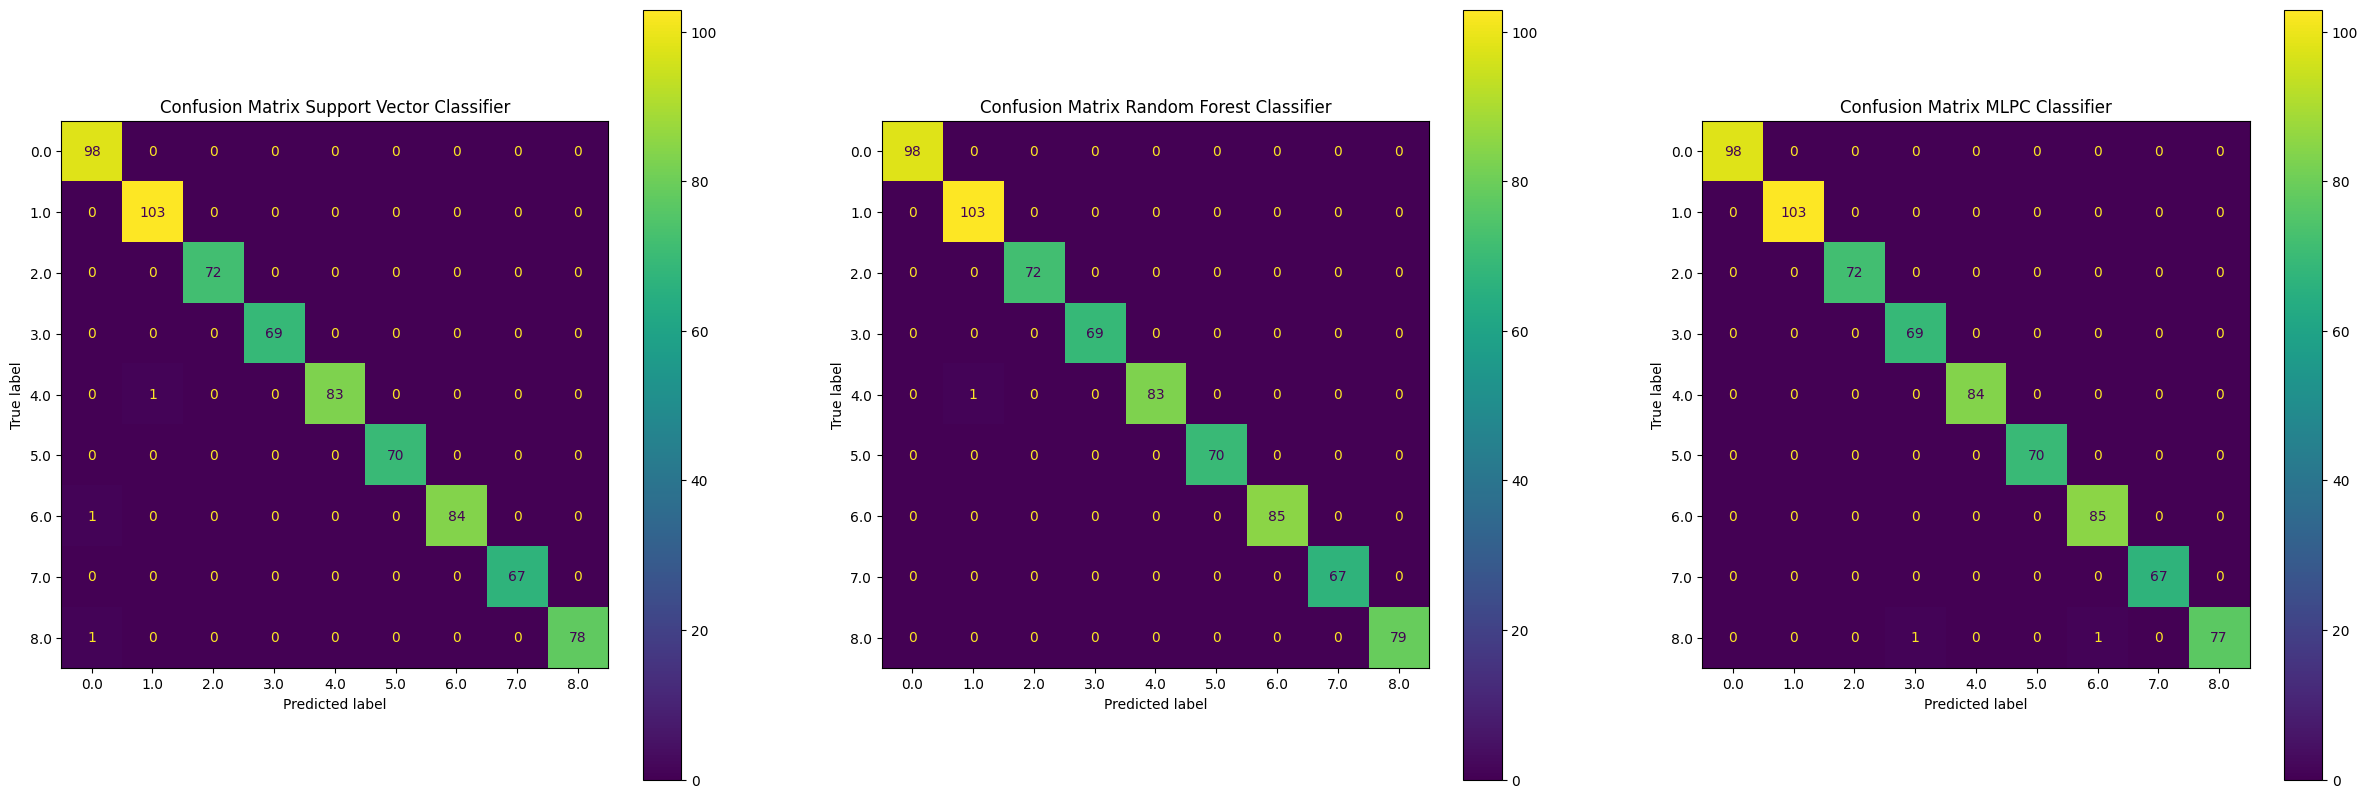

Accuracy SVC: 0.9958734525447043
Accuracy RandomForestClassifier: 1.0
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       3.021161      1.787492         0.002791        0.000165   
1       0.697405      0.027709         0.002904        0.000161   
2       1.075796      0.229963         0.003526        0.001338   

  param_hidden_layer_sizes                      params  split0_test_score  \
0                        5   {'hidden_layer_sizes': 5}           1.000000   
1                       10  {'hidden_layer_sizes': 10}           0.996558   
2                       15  {'hidden_layer_sizes': 15}           0.994836   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.989673           0.994836           0.998279           1.000000   
1           0.996558           0.994836           0.998279           1.000000   
2           0.991394           0.994836           0.996558           0.996552   

   mean_test_score  std_tes

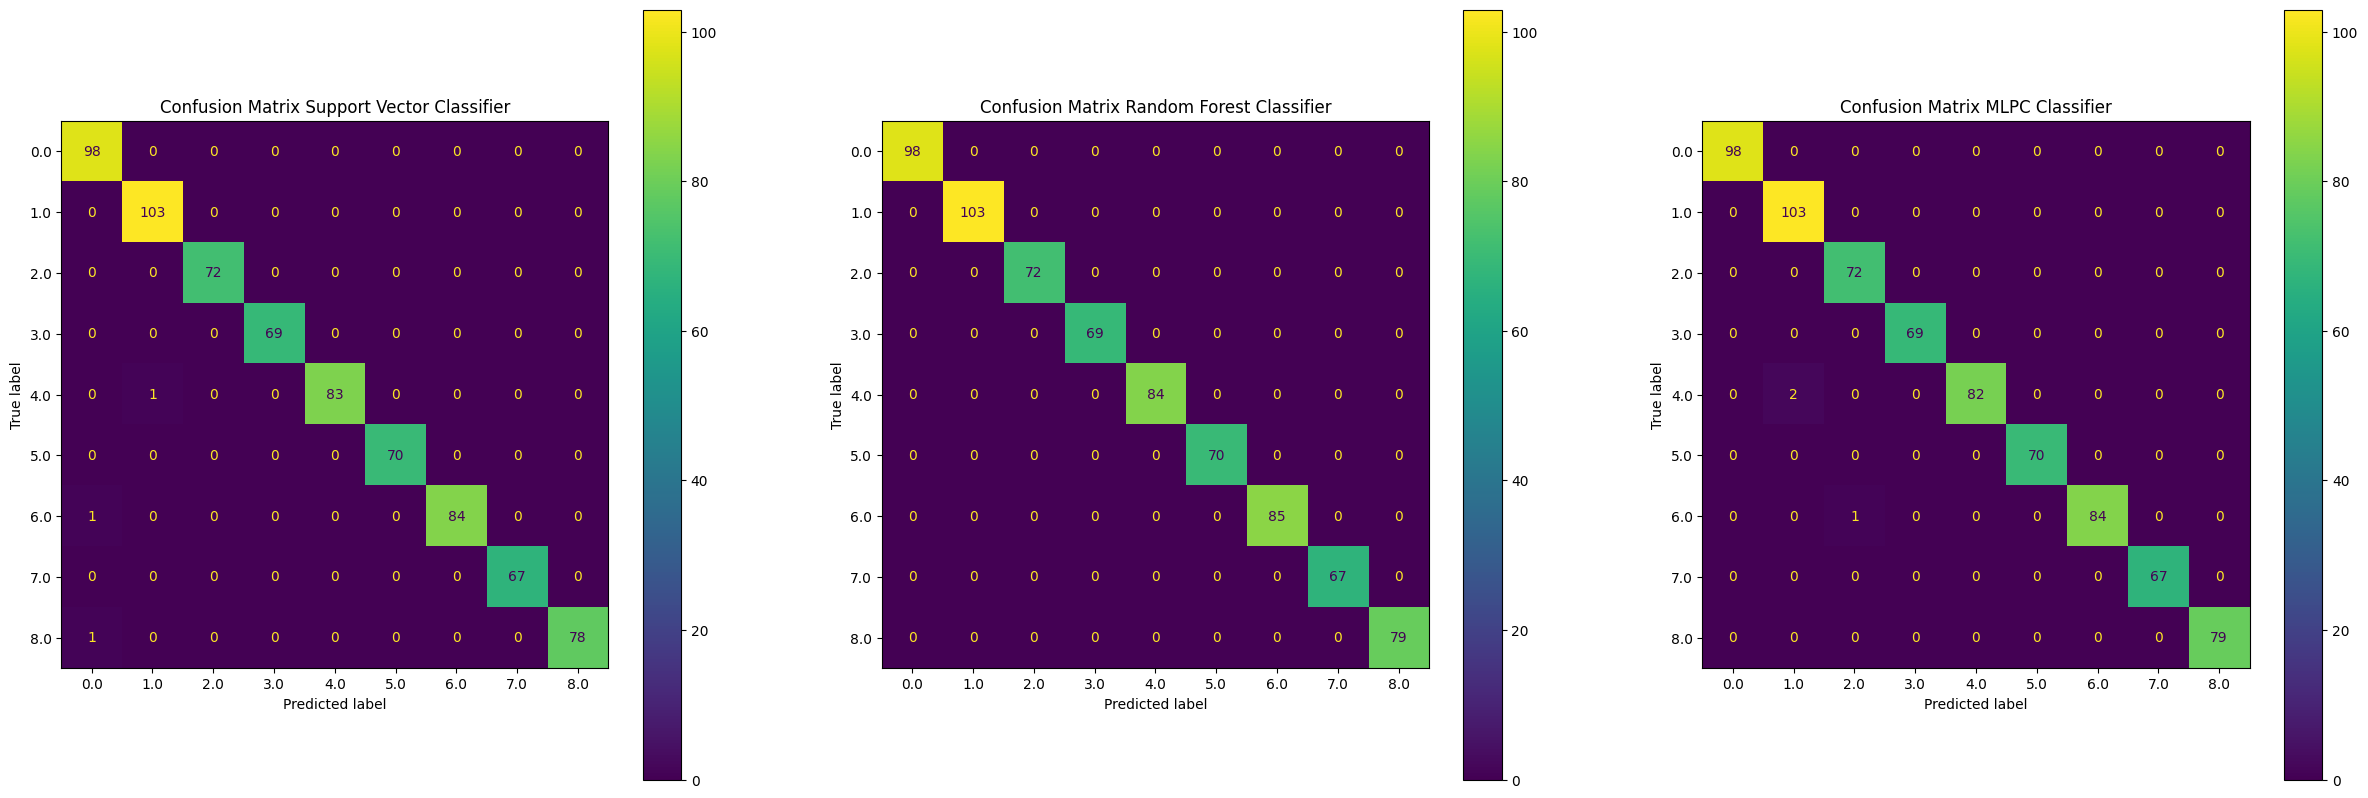

In [ ]:
train_person_classifier(wb_scaled_data, cutting_points)
train_person_classifier(wb_pca_all_data, cutting_points)
train_person_classifier(wb_pca_vector_data, cutting_points)
train_person_classifier(wb_pca_per_variable_data, cutting_points)


In [ ]:
wb_svc_0, wb_rfc_0, wb_mlpc_0 = leave_one_out(wb_scaled_data, speed_labels, person_labels)
wb_svc_1, wb_rfc_1, wb_mlpc_1 = leave_one_out(wb_pca_all_data, speed_labels, person_labels)
wb_svc_2, wb_rfc_2, wb_mlpc_2 = leave_one_out(wb_pca_vector_data, speed_labels, person_labels)
wb_svc_3, wb_rfc_3, wb_mlpc_3 = leave_one_out(wb_pca_per_variable_data, speed_labels, person_labels)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_kernel  \
0      17.161619      2.504993         2.801219        0.643993          rbf   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'kernel': 'rbf'}            0.99784           0.997849           0.994845   

   split3_test_score  split4_test_score  split5_test_score  split6_test_score  \
0                1.0                1.0                1.0           0.989899   

   split7_test_score  split8_test_score  mean_test_score  std_test_score  \
0           0.997368                1.0         0.997534        0.003163   

   rank_test_score  
0                1  
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      21.225079      1.654575         0.027750        0.006518   
1      43.905771      1.749626         0.073811        0.030573   
2      21.897159      1.527964         0.030752        0.011160   
3      42.100795      4.633775         0.051621   

A Heatmap of the Random Forest. Using the contribution to the pca component over time. Ordered by feature importance to the random forest. Only 90% of the feature importance are plotted. The pca in question is the individual pca


In [ ]:
def plot_pca_per_variable_rf(gridsearch, pca_components, feature_names):
  estimator = gridsearch.best_estimator_
  importance = estimator.feature_importances_
  argsort = np.flip(np.argsort(importance))
  sorted_importance = np.flip(np.sort(importance))

  importance_sum = 1

  for i in range(1,len(sorted_importance)+1):
    if np.sum(sorted_importance[0:i]) >= 0.9:
      relevant_features = i
      break

  plt.bar(range(len(importance)), importance)
  plt.show()
  pca_components = pca_components
  used_components = int(importance.shape[0] / pca_components.shape[0])
  heat = np.zeros((relevant_features, pca_components.shape[2]))

  tick_labels = []
  i = 0
  for a in argsort[0:relevant_features]:
    print(feature_names[a])
    print(importance[a])
    component_number = int(a/used_components)
    component_number_inside = (int(a%used_components))
    component= pca_components[component_number,component_number_inside]
    heat[i] = component
    tick_labels.append(feature_names[a])
    i +=1


  print(heat.shape)

  ax = sns.heatmap(np.abs(heat))


  ax.set_yticks(range(0,relevant_features), labels=tick_labels)
  for tick in ax.get_yticklabels():
    tick.set_rotation(0)
    tick.set_fontsize(5)
  plt.show()


A heatmap of the timepoints which are relevant to the random forest.

In [ ]:
def plot_scaled_data_rf(gridsearch, labels):
  estimator = gridsearch.best_estimator_
  importance = estimator.feature_importances_
  argsort = np.flip(np.argsort(importance))
  sorted_importance = np.flip(np.sort(importance))

  shape_0 = int(importance.shape[0] / 100)
  print(shape_0)

  importance_sum = 1
  heat = np.reshape(importance,(shape_0,100))
  test = np.sum(heat, axis = 1)
  print(sum(test))
  argsort = np.flip(np.argsort(test))
  sorted_importance = np.flip(np.sort(test))

  tick_labels = []
  relevant_features = 0
  for i in range(1,len(test) + 1):
    if np.sum(sorted_importance[0:i]) >= 0.9:
      relevant_features = i
      break

  heatmap = np.zeros((relevant_features, 100))
  print(test)
  i=0
  for a in argsort[0:relevant_features]:
    print(labels[a])
    print(test[a])
    tick_labels.append(labels[a])
    heatmap[i] = heat[a]
    i +=1


  ax = sns.heatmap(heatmap)

  ax.set_yticks(range(0,i), labels=tick_labels)
  for tick in ax.get_yticklabels():
    tick.set_rotation(0)
    tick.set_fontsize(5)
  plt.show()
#plot_scaled_data_rf(uba_rfc_0, uba_labels)


18
1.0000000000000002
[0.03660317 0.08776843 0.08337892 0.05027579 0.04761626 0.06843962
 0.06037857 0.09848384 0.09261809 0.06098766 0.01819699 0.00865147
 0.01012492 0.0502334  0.06966417 0.07384051 0.04758725 0.03515095]
_L_KNEE_ANGLE_Y
0.09848384466138774
_L_KNEE_ANGLE_Z
0.09261808641186778
_L_ANKLE_ANGLE_Y
0.08776843391912911
_L_ANKLE_ANGLE_Z
0.0833789153417095
_R_HIP_ANGLE_X
0.073840507059292
_L_HIP_ANGLE_Z
0.06966417230001638
_R_ANKLE_ANGLE_Z
0.06843961644668548
_R_KNEE_ANGLE_X
0.06098765784537261
_L_KNEE_ANGLE_X
0.0603785732400723
_R_ANKLE_ANGLE_X
0.050275791571422576
_L_HIP_ANGLE_Y
0.05023339990126649
_R_ANKLE_ANGLE_Y
0.04761625744362968
_R_HIP_ANGLE_Y
0.047587252997945445
_L_ANKLE_ANGLE_X
0.036603169553198596


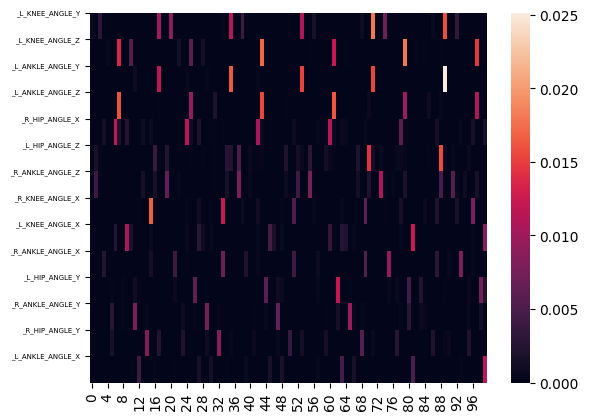

24
0.9999999999999999
[0.00026642 0.0007749  0.00087493 0.00068355 0.00488787 0.00128794
 0.07564115 0.13744131 0.16761363 0.09418526 0.07920753 0.01571049
 0.00227525 0.00083314 0.00086027 0.00097312 0.00856147 0.00231144
 0.04976688 0.10988781 0.11321137 0.06196767 0.04966564 0.02111096]
_L_ANKLE_POSITION_Z
0.16761363258521061
_L_ANKLE_POSITION_Y
0.13744130529755083
_L_HIP_POSITION_Z
0.11321136904668055
_L_HIP_POSITION_Y
0.10988781320137984
_R_ANKLE_POSITION_X
0.09418526344494885
_R_ANKLE_POSITION_Y
0.07920753154810284
_L_ANKLE_POSITION_X
0.0756411461159115
_R_HIP_POSITION_X
0.0619676674664683
_L_HIP_POSITION_X
0.04976688275240653
_R_HIP_POSITION_Y
0.04966564110685944


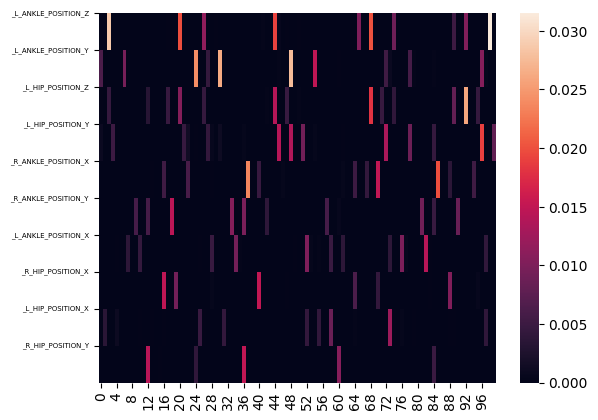

42
0.9999999999999999
[0.00040145 0.00362222 0.00529457 0.01432043 0.00944431 0.00104859
 0.00416335 0.00875348 0.00034348 0.0005784  0.00996513 0.03802613
 0.05667408 0.06590931 0.11063262 0.06246503 0.08245763 0.06391646
 0.0414229  0.03900813 0.00705501 0.00050536 0.00105429 0.00043967
 0.00036292 0.00088366 0.00382612 0.0013601  0.00119421 0.00132953
 0.00450177 0.00791288 0.0113811  0.07295213 0.05582312 0.07579343
 0.02914465 0.03708099 0.05310637 0.00855073 0.00257411 0.00472015]
_L_HIP_ANGLE_Z
0.11063262473517019
_R_HIP_ANGLE_Y
0.08245763293201125
_R_KNEE_POSITION_Z
0.07579343481991742
_R_KNEE_POSITION_X
0.07295212848970736
_L_HIP_ANGLE_Y
0.06590930676768028
_R_HIP_ANGLE_Z
0.06391646402084243
_R_HIP_ANGLE_X
0.0624650342847899
_L_HIP_ANGLE_X
0.05667407772227721
_R_KNEE_POSITION_Y
0.05582311834449955
_L_HIP_POSITION_Z
0.05310636608962544
_L_MTP_POSITION_X
0.041422900065139226
_L_MTP_POSITION_Y
0.03900812581416672
_R_KNEE_ANGLE_Z
0.03802612930630551
_L_HIP_POSITION_Y
0.03708098674

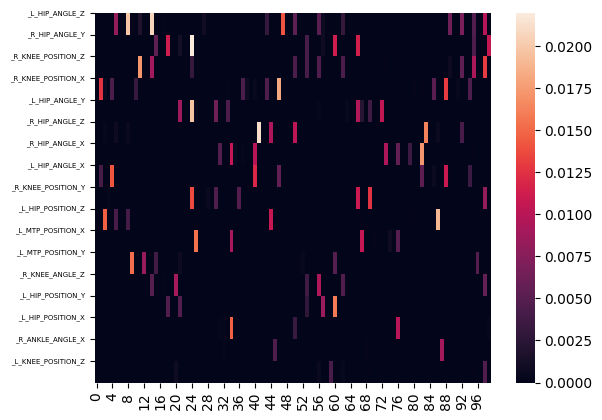

15
1.0
[0.04321632 0.01993562 0.01313424 0.03007403 0.07225746 0.13527417
 0.14725336 0.07969296 0.01386055 0.01055583 0.03198842 0.06829739
 0.12225564 0.10976606 0.10243794]
_L_ELBOW_ANGLE_X
0.14725336305888395
_R_SHOULDER_ANGLE_Z
0.13527416906495018
_TORSO_ANGLE_wrt_PELVIS_X
0.1222556447419657
_TORSO_ANGLE_wrt_PELVIS_Y
0.10976605973295828
_TORSO_ANGLE_wrt_PELVIS_Z
0.10243793575383102
_L_ELBOW_ANGLE_Y
0.07969296197401468
_R_SHOULDER_ANGLE_Y
0.0722574641340909
_R_ELBOW_ANGLE_Z
0.06829738782385593
_L_SHOULDER_ANGLE_X
0.0432163207059788
_R_ELBOW_ANGLE_Y
0.03198842386007267


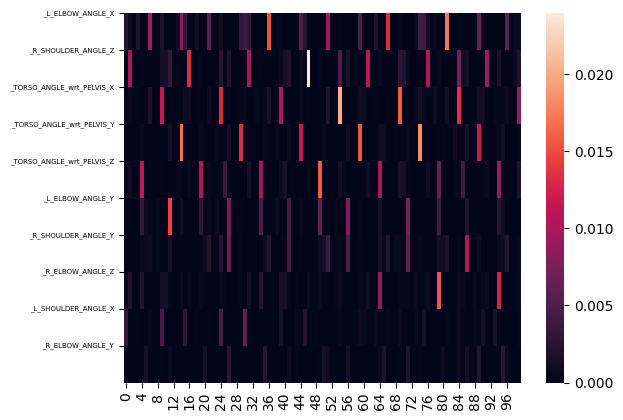

18
1.0
[0.0879169  0.07203194 0.0380151  0.02904067 0.0317028  0.05663249
 0.11433935 0.08229211 0.07515069 0.05776463 0.04140673 0.04270068
 0.02734465 0.02331693 0.0318016  0.04298851 0.05815969 0.08739454]
_L_ELBOW_POSITION_X
0.11433935105095212
_L_SHOULDER_POSITION_X
0.08791689982286172
_R_WRIST_POSITION_Z
0.08739453788528394
_L_ELBOW_POSITION_Y
0.08229210626367864
_L_ELBOW_POSITION_Z
0.07515069417200773
_L_SHOULDER_POSITION_Y
0.07203194097620003
_R_WRIST_POSITION_Y
0.058159685767897866
_R_ELBOW_POSITION_X
0.05776463099396514
_R_SHOULDER_POSITION_Z
0.05663249369841519
_R_WRIST_POSITION_X
0.04298850649400655
_R_ELBOW_POSITION_Z
0.0427006789651361
_R_ELBOW_POSITION_Y
0.041406728793991224
_L_SHOULDER_POSITION_Z
0.0380151017635551
_L_WRIST_POSITION_Z
0.0318015953445827
_R_SHOULDER_POSITION_Y
0.03170279922678758


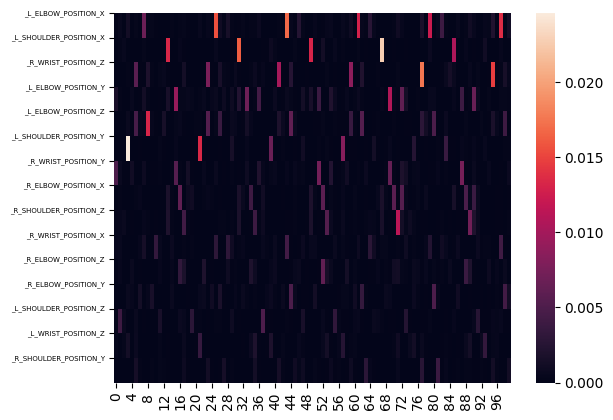

33
0.9999999999999999
[0.02903091 0.04968951 0.03023536 0.01334568 0.01290024 0.01577445
 0.00988247 0.00707802 0.01990844 0.02670473 0.03626591 0.0497682
 0.08094847 0.06963367 0.05483424 0.04347461 0.02794187 0.01695438
 0.01235527 0.01489381 0.01706982 0.00965217 0.00914492 0.01133165
 0.00666135 0.02315662 0.02801188 0.03383956 0.04610114 0.05049535
 0.0523478  0.05582642 0.03474106]
_TORSO_ANGLE_wrt_PELVIS_X
0.08094847382296108
_TORSO_ANGLE_wrt_PELVIS_Y
0.06963367045139959
_R_WRIST_POSITION_Y
0.05582642403294047
_TORSO_ANGLE_wrt_PELVIS_Z
0.054834244365016625
_R_WRIST_POSITION_X
0.052347798712588246
_L_WRIST_POSITION_Z
0.05049534918803024
_R_ELBOW_ANGLE_Z
0.04976820426995673
_L_SHOULDER_ANGLE_Y
0.04968951233808213
_L_WRIST_POSITION_Y
0.046101141262264056
_L_SHOULDER_POSITION_X
0.04347461291533419
_R_ELBOW_ANGLE_Y
0.03626591271678008
_R_WRIST_POSITION_Z
0.03474106414564001
_L_WRIST_POSITION_X
0.0338395640899404
_L_SHOULDER_ANGLE_Z
0.03023535999725964
_L_SHOULDER_ANGLE_X
0.0290309065

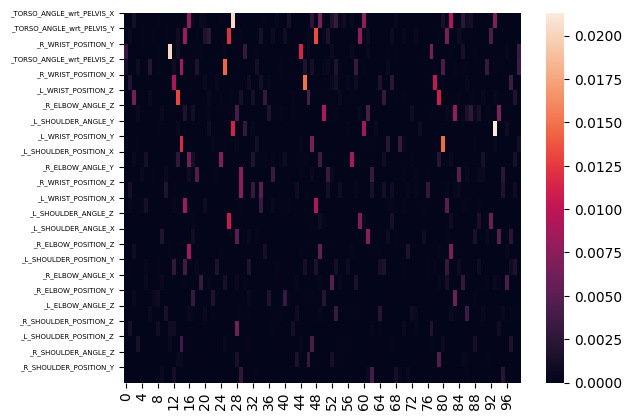

75
1.0000000000000002
[0.00393699 0.00411949 0.00227228 0.00447896 0.00074623 0.00050385
 0.0035913  0.00314464 0.00057664 0.00478342 0.00036169 0.00045924
 0.00109866 0.00039654 0.00074504 0.00046941 0.00251065 0.00186186
 0.01096047 0.010877   0.01683632 0.02810873 0.05786981 0.03007581
 0.0218785  0.03714154 0.03488869 0.02116453 0.05462898 0.03761901
 0.03021455 0.0569798  0.03265712 0.02159691 0.03863835 0.00283809
 0.00580233 0.00860934 0.00214711 0.00243532 0.00103538 0.00083843
 0.00187424 0.00074306 0.0007458  0.0001096  0.00051414 0.00182226
 0.00048582 0.00222734 0.00190822 0.00620957 0.0028726  0.00223147
 0.00940106 0.00284335 0.00641353 0.0109136  0.01954726 0.01780091
 0.02100157 0.04198441 0.01566127 0.02083546 0.05139054 0.02142302
 0.02099138 0.0382938  0.0218787  0.01581169 0.01733018 0.00346071
 0.00338916 0.01070473 0.00528054]
_R_SHOULDER_ANGLE_Y
0.05786981053802007
_TORSO_ANGLE_wrt_PELVIS_Y
0.0569798037550647
_R_ELBOW_ANGLE_Y
0.05462897987854006
_L_ELBOW_POSITION

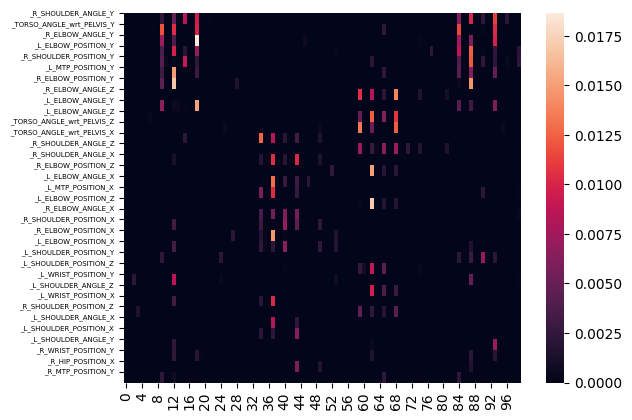

In [ ]:
plot_scaled_data_rf(lba_rfc_0, lba_labels)
plot_scaled_data_rf(lbp_rfc_0, lbp_labels)
plot_scaled_data_rf(lb_rfc_0, lb_labels)
plot_scaled_data_rf(uba_rfc_0, uba_labels)
plot_scaled_data_rf(ubp_rfc_0, ubp_labels)
plot_scaled_data_rf(ub_rfc_0, ub_labels)
plot_scaled_data_rf(wb_rfc_0, wb_labels)

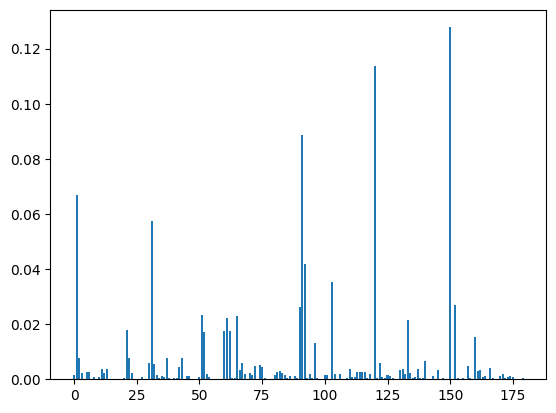

_R_HIP_ANGLE_X_Component_0
0.127755570451852
_L_HIP_ANGLE_X_Component_0
0.11379326273965262
_R_KNEE_ANGLE_X_Component_1
0.08851125911121255
_L_ANKLE_ANGLE_X_Component_1
0.06706166044999384
_R_ANKLE_ANGLE_X_Component_1
0.05752911646493149
_R_KNEE_ANGLE_X_Component_2
0.04177357342438289
_R_KNEE_ANGLE_Y_Component_3
0.035439518851220805
_R_HIP_ANGLE_X_Component_2
0.026830171295962626
_R_KNEE_ANGLE_X_Component_0
0.026338895151256408
_R_ANKLE_ANGLE_Z_Component_1
0.023311618289392724
_L_KNEE_ANGLE_X_Component_5
0.02304488252038737
_L_KNEE_ANGLE_X_Component_1
0.022287683278572678
_L_HIP_ANGLE_Y_Component_3
0.021630695821090836
_L_ANKLE_ANGLE_Z_Component_1
0.017780558839424872
_L_KNEE_ANGLE_X_Component_0
0.01746527084226419
_L_KNEE_ANGLE_X_Component_2
0.017382216188128224
_R_ANKLE_ANGLE_Z_Component_2
0.017187876684529604
_R_HIP_ANGLE_Y_Component_0
0.015517560103302519
_R_KNEE_ANGLE_X_Component_6
0.013145164040004185
_L_ANKLE_ANGLE_Z_Component_2
0.007857146030518061
_L_ANKLE_ANGLE_X_Component_2


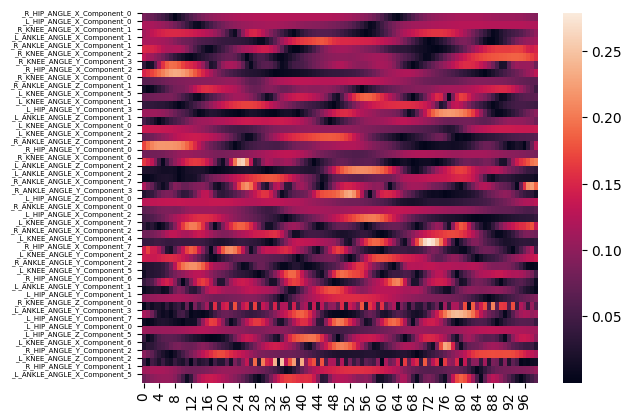

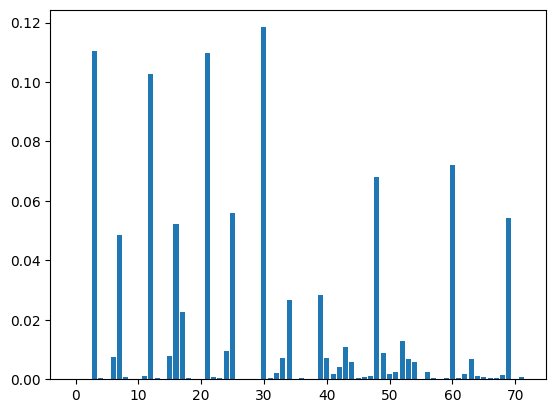

_R_ANKLE_POSITION_Y_Component_0
0.11840536923600636
_L_MTP_POSITION_Y_Component_0
0.11053153410741993
_L_ANKLE_POSITION_Y_Component_0
0.10980496161192992
_R_MTP_POSITION_Y_Component_0
0.10269892121282215
_L_HIP_POSITION_Z_Component_0
0.07203256758870002
_R_KNEE_POSITION_Y_Component_0
0.06796180794581366
_L_ANKLE_POSITION_Z_Component_1
0.05583468584409567
_R_HIP_POSITION_Z_Component_0
0.05431726470556916
_R_MTP_POSITION_Z_Component_1
0.05237472004412915
_L_MTP_POSITION_Z_Component_1
0.048611495695248565
_L_KNEE_POSITION_Y_Component_0
0.028212672543136592
_R_ANKLE_POSITION_Z_Component_1
0.02666300597554979
_R_MTP_POSITION_Z_Component_2
0.022567288154517685
_R_KNEE_POSITION_Z_Component_1
0.012782993860024332
_L_KNEE_POSITION_Z_Component_1
0.010716707941444286
_L_ANKLE_POSITION_Z_Component_0
0.009653245929820422
(16, 100)


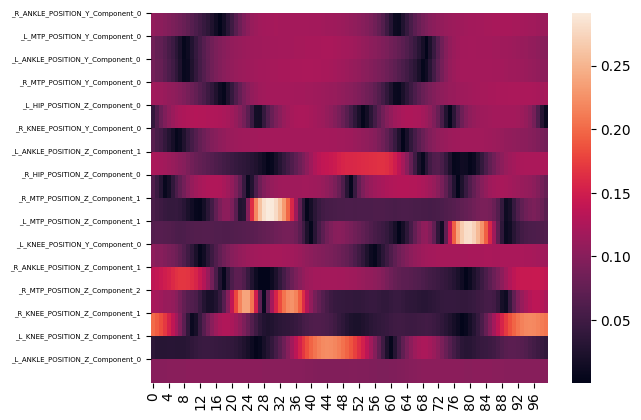

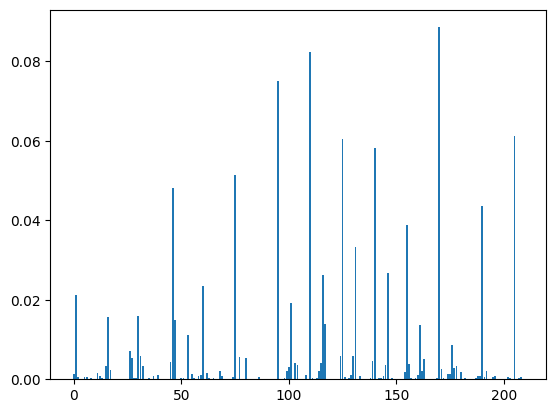

_R_KNEE_POSITION_Y_Component_0
0.08854301886300416
_R_MTP_POSITION_Y_Component_0
0.0823237306967194
_L_MTP_POSITION_Y_Component_0
0.07504834647228723
_R_HIP_POSITION_Z_Component_0
0.06113334002043801
_L_ANKLE_POSITION_Y_Component_0
0.06054693794748423
_R_ANKLE_POSITION_Y_Component_0
0.05821148749524335
_R_HIP_ANGLE_X_Component_0
0.0512768170341329
_R_KNEE_ANGLE_X_Component_1
0.04801258593330106
_L_HIP_POSITION_Z_Component_0
0.04363434795939607
_L_KNEE_POSITION_Y_Component_0
0.038700567207118494
_L_ANKLE_POSITION_Z_Component_1
0.03329591067678936
_R_ANKLE_POSITION_Z_Component_1
0.026770438033824968
_R_MTP_POSITION_Z_Component_1
0.026250307369235937
_L_HIP_ANGLE_X_Component_0
0.02344754202070376
_L_ANKLE_ANGLE_X_Component_1
0.021263220922985212
_L_MTP_POSITION_Z_Component_1
0.019278824157858924
_L_KNEE_ANGLE_X_Component_0
0.015934228862504375
_R_ANKLE_ANGLE_X_Component_1
0.015751741726104482
_R_KNEE_ANGLE_X_Component_2
0.014803004953542065
_R_MTP_POSITION_Z_Component_2
0.0138725639191605

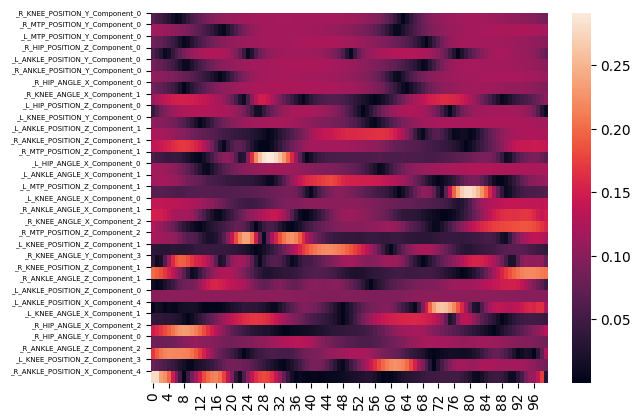

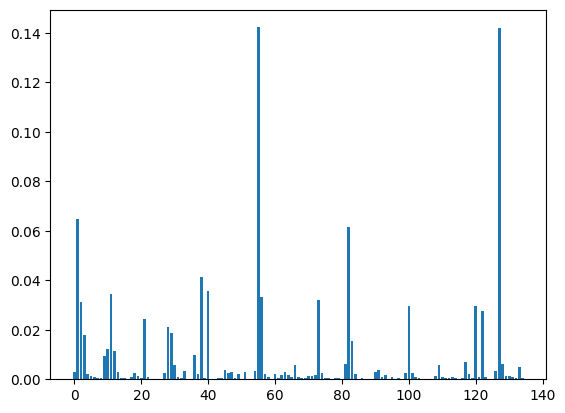

_L_ELBOW_ANGLE_X_Component_1
0.14229045136071386
_TORSO_ANGLE_wrt_PELVIS_Z_Component_1
0.14193915808175347
_L_SHOULDER_ANGLE_X_Component_1
0.06461290373607781
_R_ELBOW_ANGLE_X_Component_1
0.06144275059429187
_R_SHOULDER_ANGLE_Y_Component_2
0.04128354258956531
_R_SHOULDER_ANGLE_Y_Component_4
0.03576732815513764
_L_SHOULDER_ANGLE_Y_Component_2
0.03452603809815448
_L_ELBOW_ANGLE_X_Component_2
0.033204929274755365
_L_ELBOW_ANGLE_Z_Component_1
0.03187144294058881
_L_SHOULDER_ANGLE_X_Component_2
0.031151946732667277
_TORSO_ANGLE_wrt_PELVIS_Y_Component_3
0.029789461525655467
_R_ELBOW_ANGLE_Z_Component_1
0.02971699734742036
_TORSO_ANGLE_wrt_PELVIS_Y_Component_5
0.027491509743826963
_L_SHOULDER_ANGLE_Z_Component_3
0.02454132163300751
_R_SHOULDER_ANGLE_X_Component_1
0.02108094749183755
_R_SHOULDER_ANGLE_X_Component_2
0.018839310117641218
_L_SHOULDER_ANGLE_X_Component_3
0.017802796440886882
_R_ELBOW_ANGLE_X_Component_2
0.015440834641799127
_L_SHOULDER_ANGLE_Y_Component_1
0.01225878259404239
_L_SH

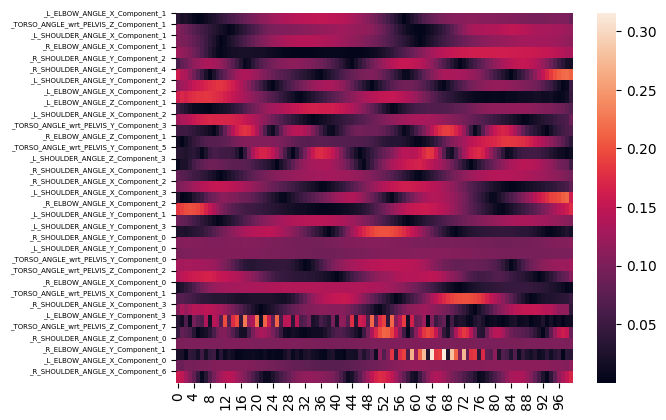

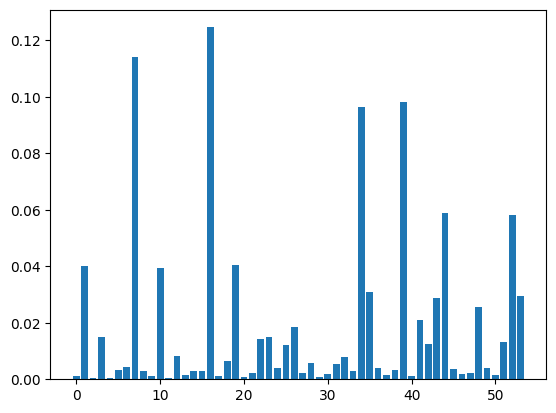

_R_SHOULDER_POSITION_Z_Component_1
0.12461555041369621
_L_SHOULDER_POSITION_Z_Component_1
0.11406382062757901
_L_WRIST_POSITION_Y_Component_0
0.09818062052717982
_R_ELBOW_POSITION_Z_Component_1
0.09630111183883597
_L_WRIST_POSITION_Z_Component_2
0.05881263757723987
_R_WRIST_POSITION_Z_Component_1
0.058151697425281916
_L_ELBOW_POSITION_X_Component_1
0.0405198525066776
_L_SHOULDER_POSITION_X_Component_1
0.04023411982917912
_R_SHOULDER_POSITION_X_Component_1
0.03925561995796651
_R_ELBOW_POSITION_Z_Component_2
0.03105600121907357
_R_WRIST_POSITION_Z_Component_2
0.029527254491543288
_L_WRIST_POSITION_Z_Component_1
0.02871686331838594
_R_WRIST_POSITION_Y_Component_0
0.025651048964203
_L_WRIST_POSITION_Y_Component_2
0.02111816777924622
_L_ELBOW_POSITION_Z_Component_2
0.01865574150641393
_L_ELBOW_POSITION_Y_Component_2
0.015080683763343842
_L_SHOULDER_POSITION_Y_Component_0
0.015009826781010989
_L_ELBOW_POSITION_Y_Component_1
0.014117307642687938
_R_WRIST_POSITION_Z_Component_0
0.0133360249207

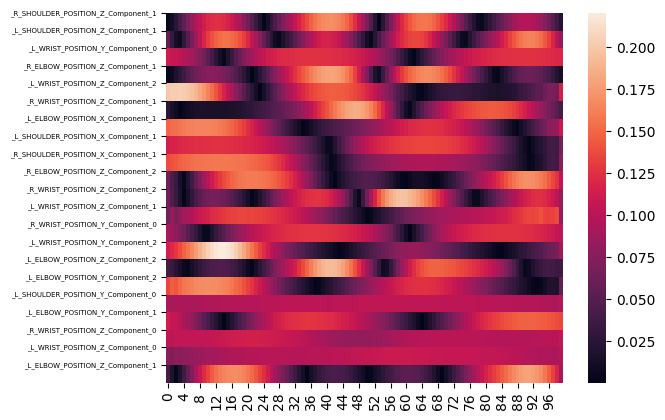

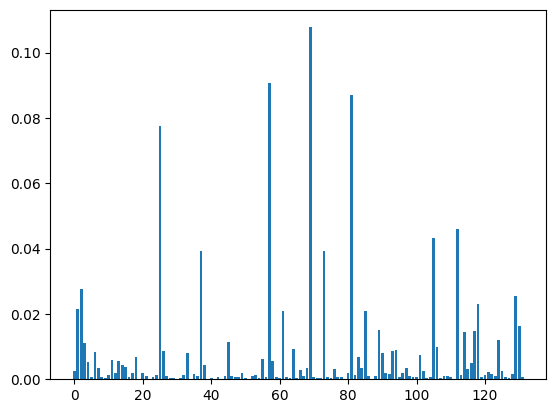

_L_SHOULDER_POSITION_Z_Component_1
0.10774921685097505
_TORSO_ANGLE_wrt_PELVIS_Z_Component_1
0.0908344951458514
_R_SHOULDER_POSITION_Z_Component_1
0.08694026041467326
_L_ELBOW_ANGLE_X_Component_1
0.0773910154454801
_L_WRIST_POSITION_Y_Component_0
0.046102982116046
_R_ELBOW_POSITION_Z_Component_1
0.04310290613974401
_R_ELBOW_ANGLE_X_Component_1
0.03923178464662877
_R_SHOULDER_POSITION_X_Component_1
0.0391424806326471
_L_SHOULDER_ANGLE_X_Component_2
0.027691243514674013
_R_WRIST_POSITION_Z_Component_1
0.025571725098947815
_L_WRIST_POSITION_Z_Component_2
0.023076588392992762
_L_SHOULDER_ANGLE_X_Component_1
0.02151818262247399
_L_SHOULDER_POSITION_X_Component_1
0.021045260016518505
_L_ELBOW_POSITION_X_Component_1
0.020859024918145227
_R_WRIST_POSITION_Z_Component_2
0.016340065452042515
_L_ELBOW_POSITION_Y_Component_1
0.014975479553345092
_L_WRIST_POSITION_Z_Component_1
0.014627345338909338
_L_WRIST_POSITION_Y_Component_2
0.014441753679466363
_R_WRIST_POSITION_Y_Component_0
0.01202790580090

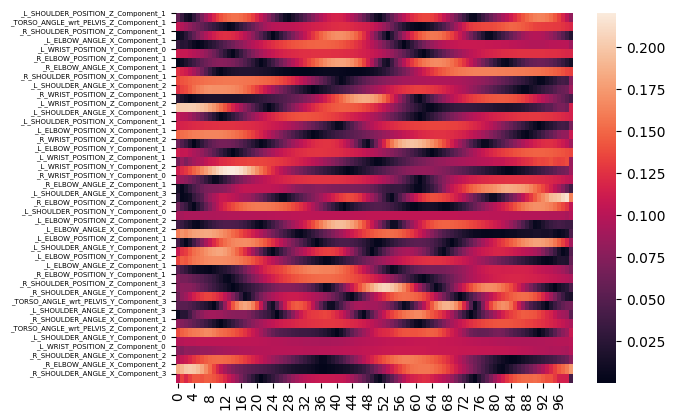

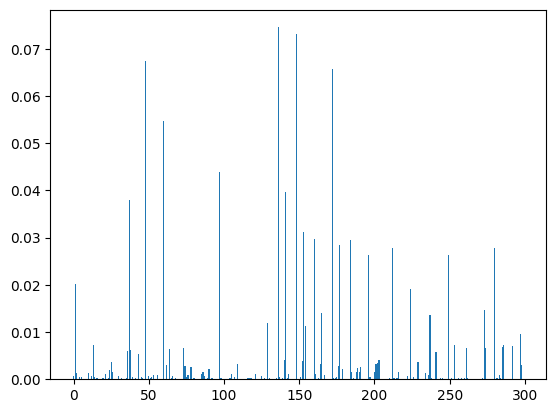

_L_MTP_POSITION_Y_Component_0
0.07454334715612018
_R_MTP_POSITION_Y_Component_0
0.07301920109023599
_L_HIP_ANGLE_X_Component_0
0.06739562133788708
_R_ANKLE_POSITION_Y_Component_0
0.06565968353640281
_R_HIP_ANGLE_X_Component_0
0.0547905576616786
_L_ELBOW_ANGLE_X_Component_1
0.04386940517425804
_L_MTP_POSITION_Z_Component_1
0.039712879350797384
_R_KNEE_ANGLE_X_Component_1
0.038000965297126606
_R_MTP_POSITION_Z_Component_1
0.031112834319897503
_L_ANKLE_POSITION_Y_Component_0
0.029772059601163584
_L_KNEE_POSITION_Y_Component_0
0.029466095860670873
_R_ANKLE_POSITION_Z_Component_1
0.028485336464093892
_L_WRIST_POSITION_Y_Component_0
0.027886064145775866
_L_HIP_POSITION_Z_Component_0
0.02778950272505455
_R_KNEE_POSITION_Y_Component_0
0.026381151880442866
_R_SHOULDER_POSITION_Z_Component_1
0.026217195193139108
_L_ANKLE_ANGLE_X_Component_1
0.020145635078450047
_R_HIP_POSITION_Z_Component_0
0.019170449113334157
_R_ELBOW_POSITION_Z_Component_1
0.014662547889661395
_L_ANKLE_POSITION_Z_Component_1


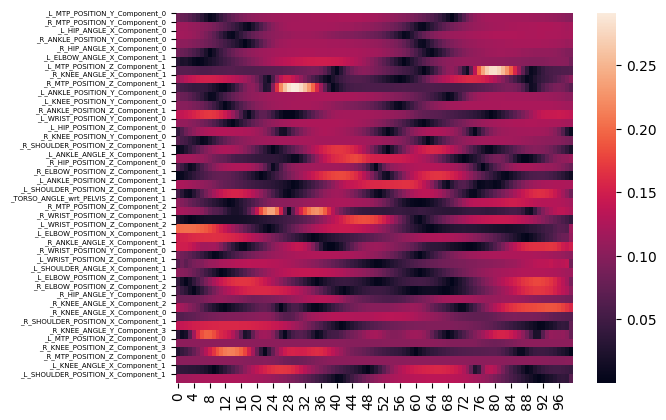

In [ ]:
plot_pca_per_variable_rf(lba_rfc_3, lba_pca_per_components, lba_pca_per_feature_names)
plot_pca_per_variable_rf(lbp_rfc_3, lbp_pca_per_components, lbp_pca_per_feature_names)
plot_pca_per_variable_rf(lb_rfc_3, lb_pca_per_components, lb_pca_per_feature_names)
plot_pca_per_variable_rf(uba_rfc_3, uba_pca_per_components, uba_pca_per_feature_names)
plot_pca_per_variable_rf(ubp_rfc_3, ubp_pca_per_components, ubp_pca_per_feature_names)
plot_pca_per_variable_rf(ub_rfc_3, ub_pca_per_components, ub_pca_per_feature_names)
plot_pca_per_variable_rf(wb_rfc_3,wb_pca_per_components, wb_pca_per_feature_names)